In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import scipy
from pathlib import Path
import pandas as pd

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

In [2]:
!nvidia-smi

Wed Jan 22 23:20:41 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0  On |                  N/A |
| N/A   87C    P0               34W /  N/A|   3534MiB /  4096MiB |     79%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
from CNNModel1d import CNNModel1d
from utils import evaluate, get_desired_freqs_and_classes, prepare_data_subjects


def get_data_for_all_subjects(
    dataset_path, channels, classes, num_windows=5, separate_trials=False
):
    subjects_files = [file for file in dataset_path.glob("*.npy")]
    freq_phase = scipy.io.loadmat("Freq_Phase.mat")
    freqs = np.round(freq_phase["freqs"], 2)  # Frequências de estimulação, arredondadas

    signals = []
    labels = []

    def sort_key(path):
        subject_number = int(path.stem.split("_")[0][1:])
        return subject_number

    sorted_paths = sorted(subjects_files, key=sort_key)

    for subject_file in sorted_paths:
        windows = np.load(subject_file)
        subj_signals, subj_labels = get_desired_freqs_and_classes(
            windows, freqs, channels, classes, number_of_windows=num_windows
        )
        if separate_trials:
            signals.append(subj_signals)
            labels.append(subj_labels)
        else:
            num_samples = num_windows * 6 * len(classes)
            num_channels = len(channels)
            signals.append(subj_signals.reshape([num_samples, num_channels, -1]))
            labels.append(subj_labels.reshape(num_samples))

    signals = np.array(signals)
    labels = np.array(labels)

    return signals, labels

In [4]:
signal = np.load("datasets/sinais_filtrados_6_52_Hz/S1_passa-banda_6_52_Hz.npy")
signal.shape

(64, 1500, 40, 6)

In [5]:
signal = np.load(
    "datasets/sinais_filtrados_6_52_Hz_janelas_1s/S1_passa-banda_6_52_Hz_janelas.npy"
)
signal.shape

(64, 250, 40, 6, 5)

In [22]:
dataset_path = Path("datasets/sinais_filtrados_6_52_Hz_janelas_1s/")
freq_phase = scipy.io.loadmat("Freq_Phase.mat")
freqs = np.round(freq_phase["freqs"], 2)
selected_freqs = freqs[0][0:8]  #  np.array([8, 10, 12, 15])  # Frequências de interesse

channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

signals, labels = get_data_for_all_subjects(
    dataset_path, channels, selected_freqs, 5, False
)
print(signals.shape)
print(labels.shape)

(35, 240, 9, 250)
(35, 240)


In [23]:
print(labels[0])

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7
 7 7 7 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6 6 6 6
 6 7 7 7 7 7 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5 5 5 6
 6 6 6 6 7 7 7 7 7 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 5 5 5
 5 5 6 6 6 6 6 7 7 7 7 7 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4
 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4
 4 4 4 5 5 5 5 5 6 6 6 6 6 7 7 7 7 7]


In [5]:
selected_freqs
sorted_indices = np.argsort(selected_freqs)
print(selected_freqs)
print(sorted_indices)
print(selected_freqs[sorted_indices])

[ 8.  9. 10. 11. 12. 13. 14. 15.]
[0 1 2 3 4 5 6 7]
[ 8.  9. 10. 11. 12. 13. 14. 15.]


In [6]:
def eval_subject(test_subject, signals, labels, classes):
    num_classes = len(classes)
    best_model = CNNModel1d(n_channels=9, n_classes=num_classes)
    best_model_save_path = f"best_trained_raw_models/cross_subject/8freq/{test_subject + 1}_best_model_raw_cross.pth"
    best_model.load_state_dict(torch.load(best_model_save_path))
    best_model.to(device)
    cm_path = (
        f"best_trained_raw_models/cross_subject/8freq/new_cm/{test_subject + 1}.png"
    )
    freq_phase = scipy.io.loadmat("Freq_Phase.mat")
    freqs = np.round(freq_phase["freqs"], 2)  # Frequências de estimulação, arredondadas

    _, test_loader, _ = prepare_data_subjects(
        signals,
        labels,
        test_subject=test_subject,
        train_batch_size=1,
        validation_split=True,
    )

    acc, rcll, f1s = evaluate(
        best_model, test_loader, class_labels=classes, filename=cm_path
    )
    metrics = {
        "accuracy": np.array(acc),
        "recall": np.array(rcll),
        "f1_score": np.array(f1s),
    }
    return metrics

C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

Testing on subject 1.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


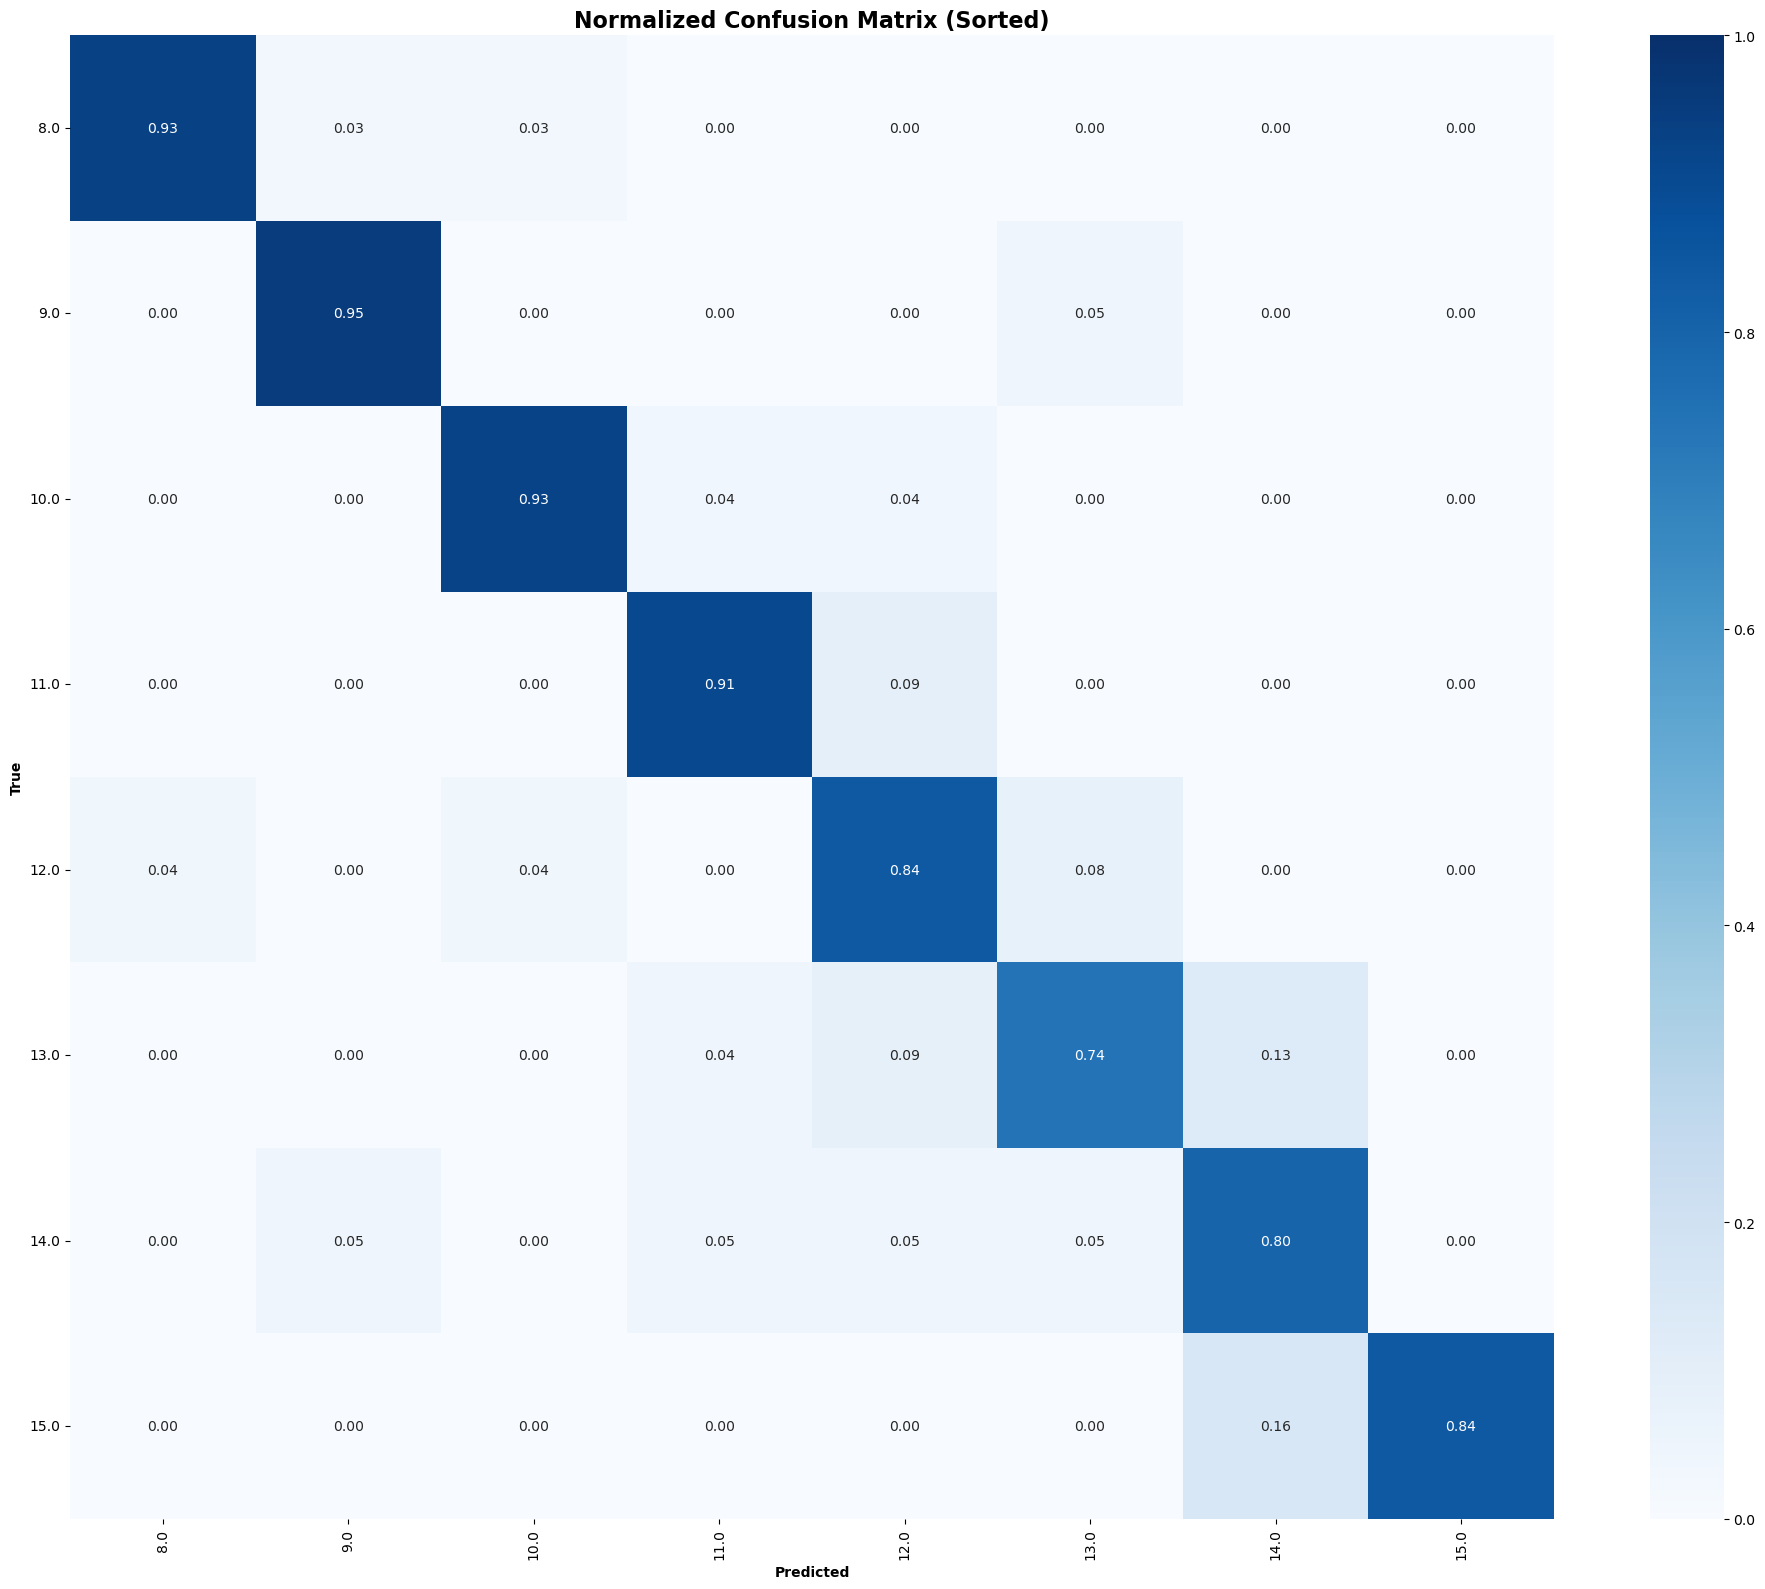

Test set Accuracy: 0.8698
Recall: 0.8698
F1 Score: 0.8710
Confusion Matrix:
[[27  1  1  0  0  0  0  0]
 [ 0 20  0  0  0  1  0  0]
 [ 0  0 25  1  1  0  0  0]
 [ 0  0  0 20  2  0  0  0]
 [ 1  0  1  0 21  2  0  0]
 [ 0  0  0  1  2 17  3  0]
 [ 0  1  0  1  1  1 16  0]
 [ 0  0  0  0  0  0  4 21]]
Testing on subject 2.


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


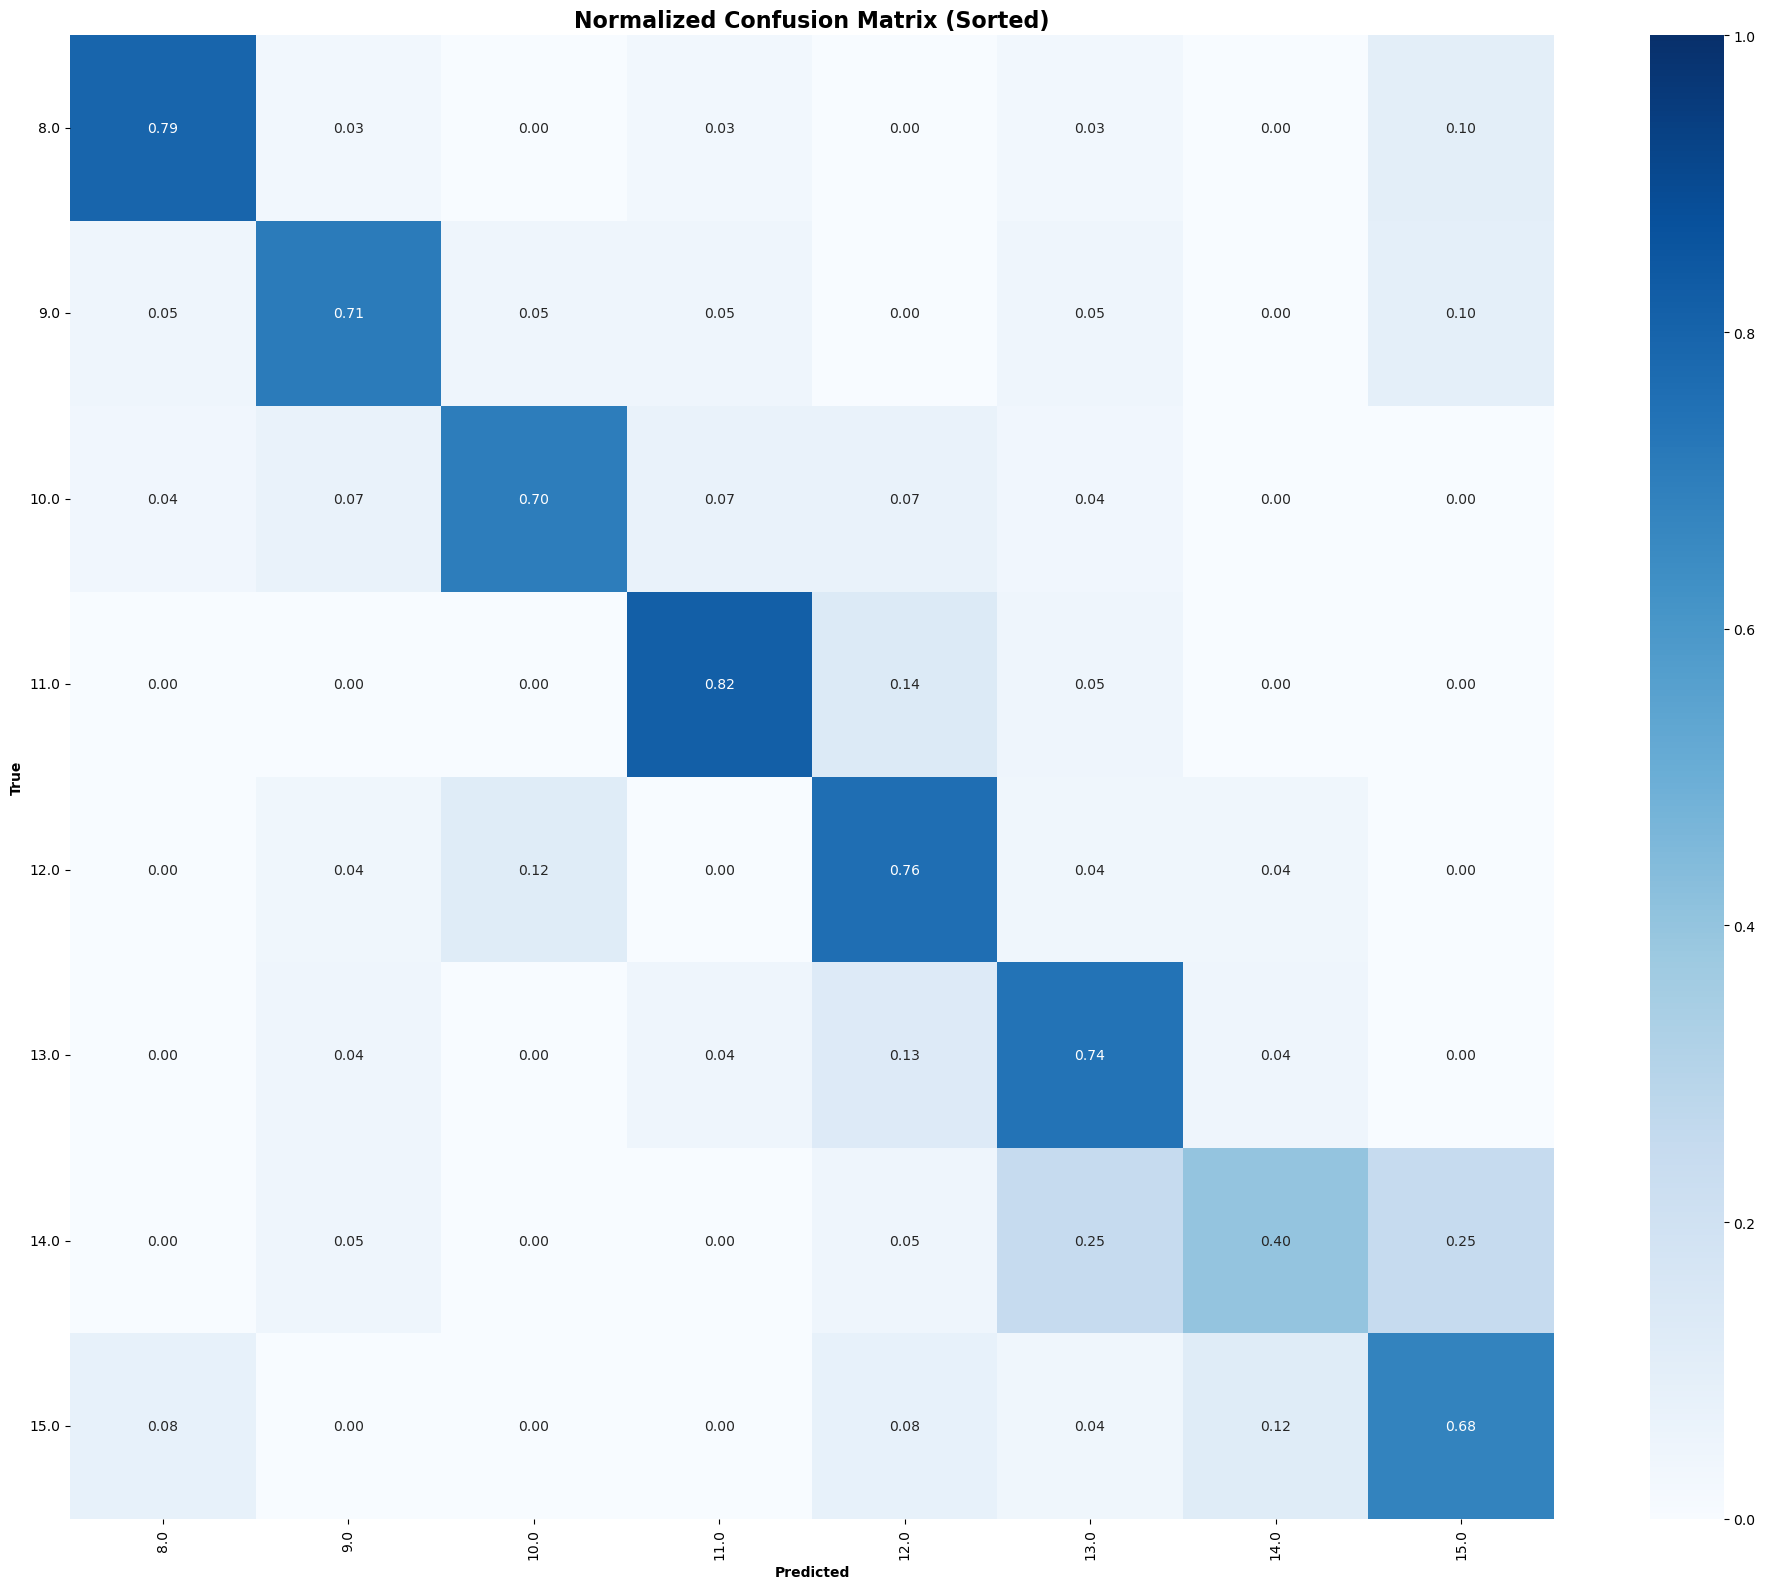

Test set Accuracy: 0.7083
Recall: 0.7083
F1 Score: 0.7062
Confusion Matrix:
[[23  1  0  1  0  1  0  3]
 [ 1 15  1  1  0  1  0  2]
 [ 1  2 19  2  2  1  0  0]
 [ 0  0  0 18  3  1  0  0]
 [ 0  1  3  0 19  1  1  0]
 [ 0  1  0  1  3 17  1  0]
 [ 0  1  0  0  1  5  8  5]
 [ 2  0  0  0  2  1  3 17]]
Testing on subject 3.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

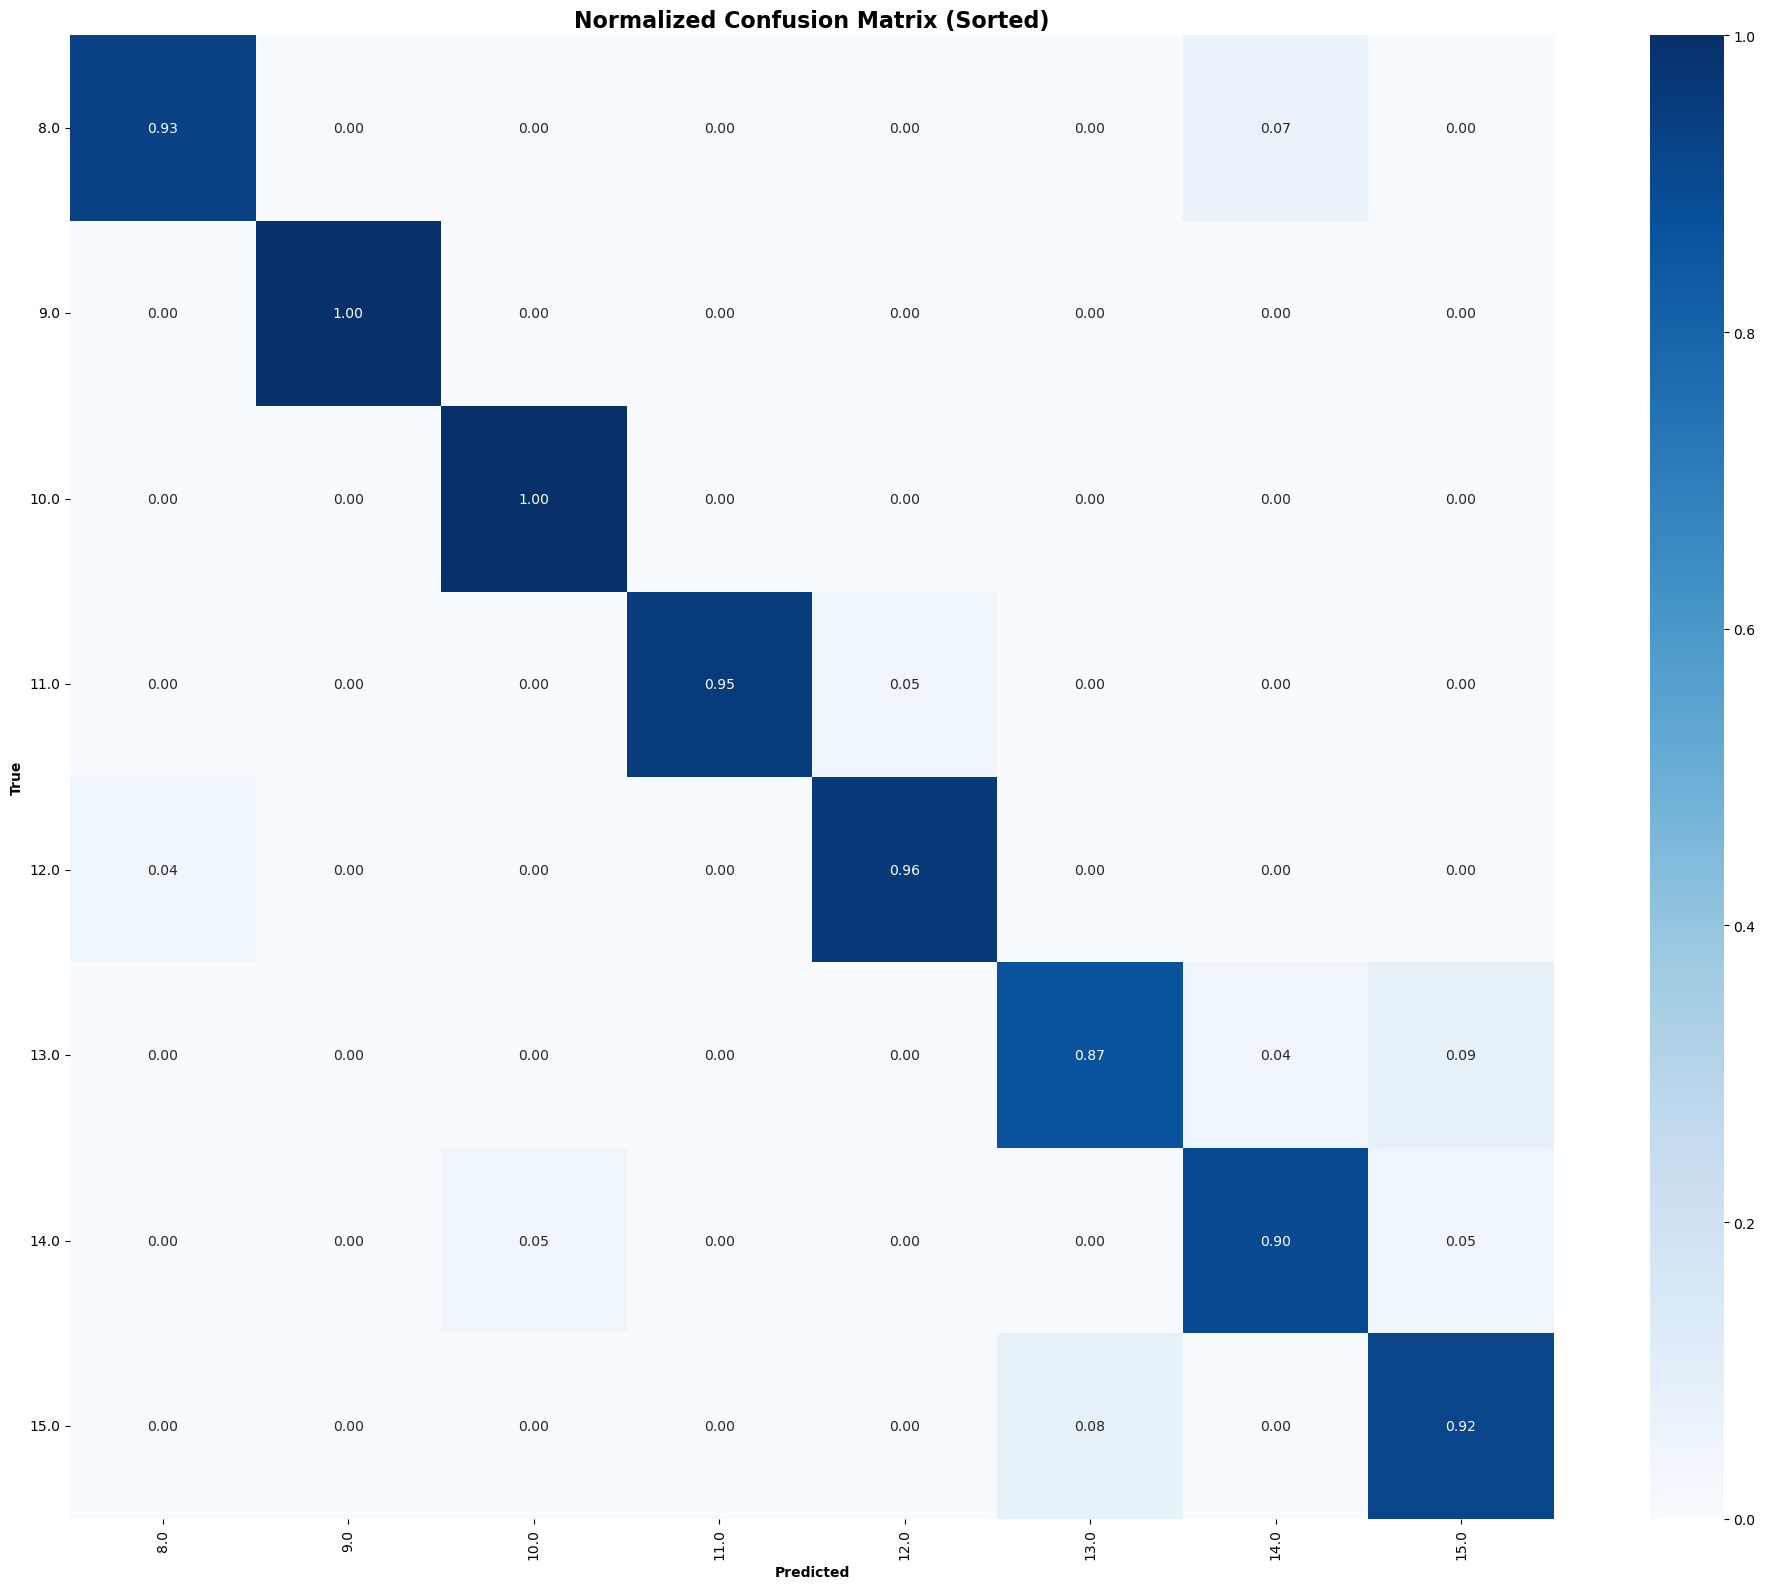

Test set Accuracy: 0.9427
Recall: 0.9427
F1 Score: 0.9428
Confusion Matrix:
[[27  0  0  0  0  0  2  0]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0]
 [ 0  0  0 21  1  0  0  0]
 [ 1  0  0  0 24  0  0  0]
 [ 0  0  0  0  0 20  1  2]
 [ 0  0  1  0  0  0 18  1]
 [ 0  0  0  0  0  2  0 23]]
Testing on subject 4.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

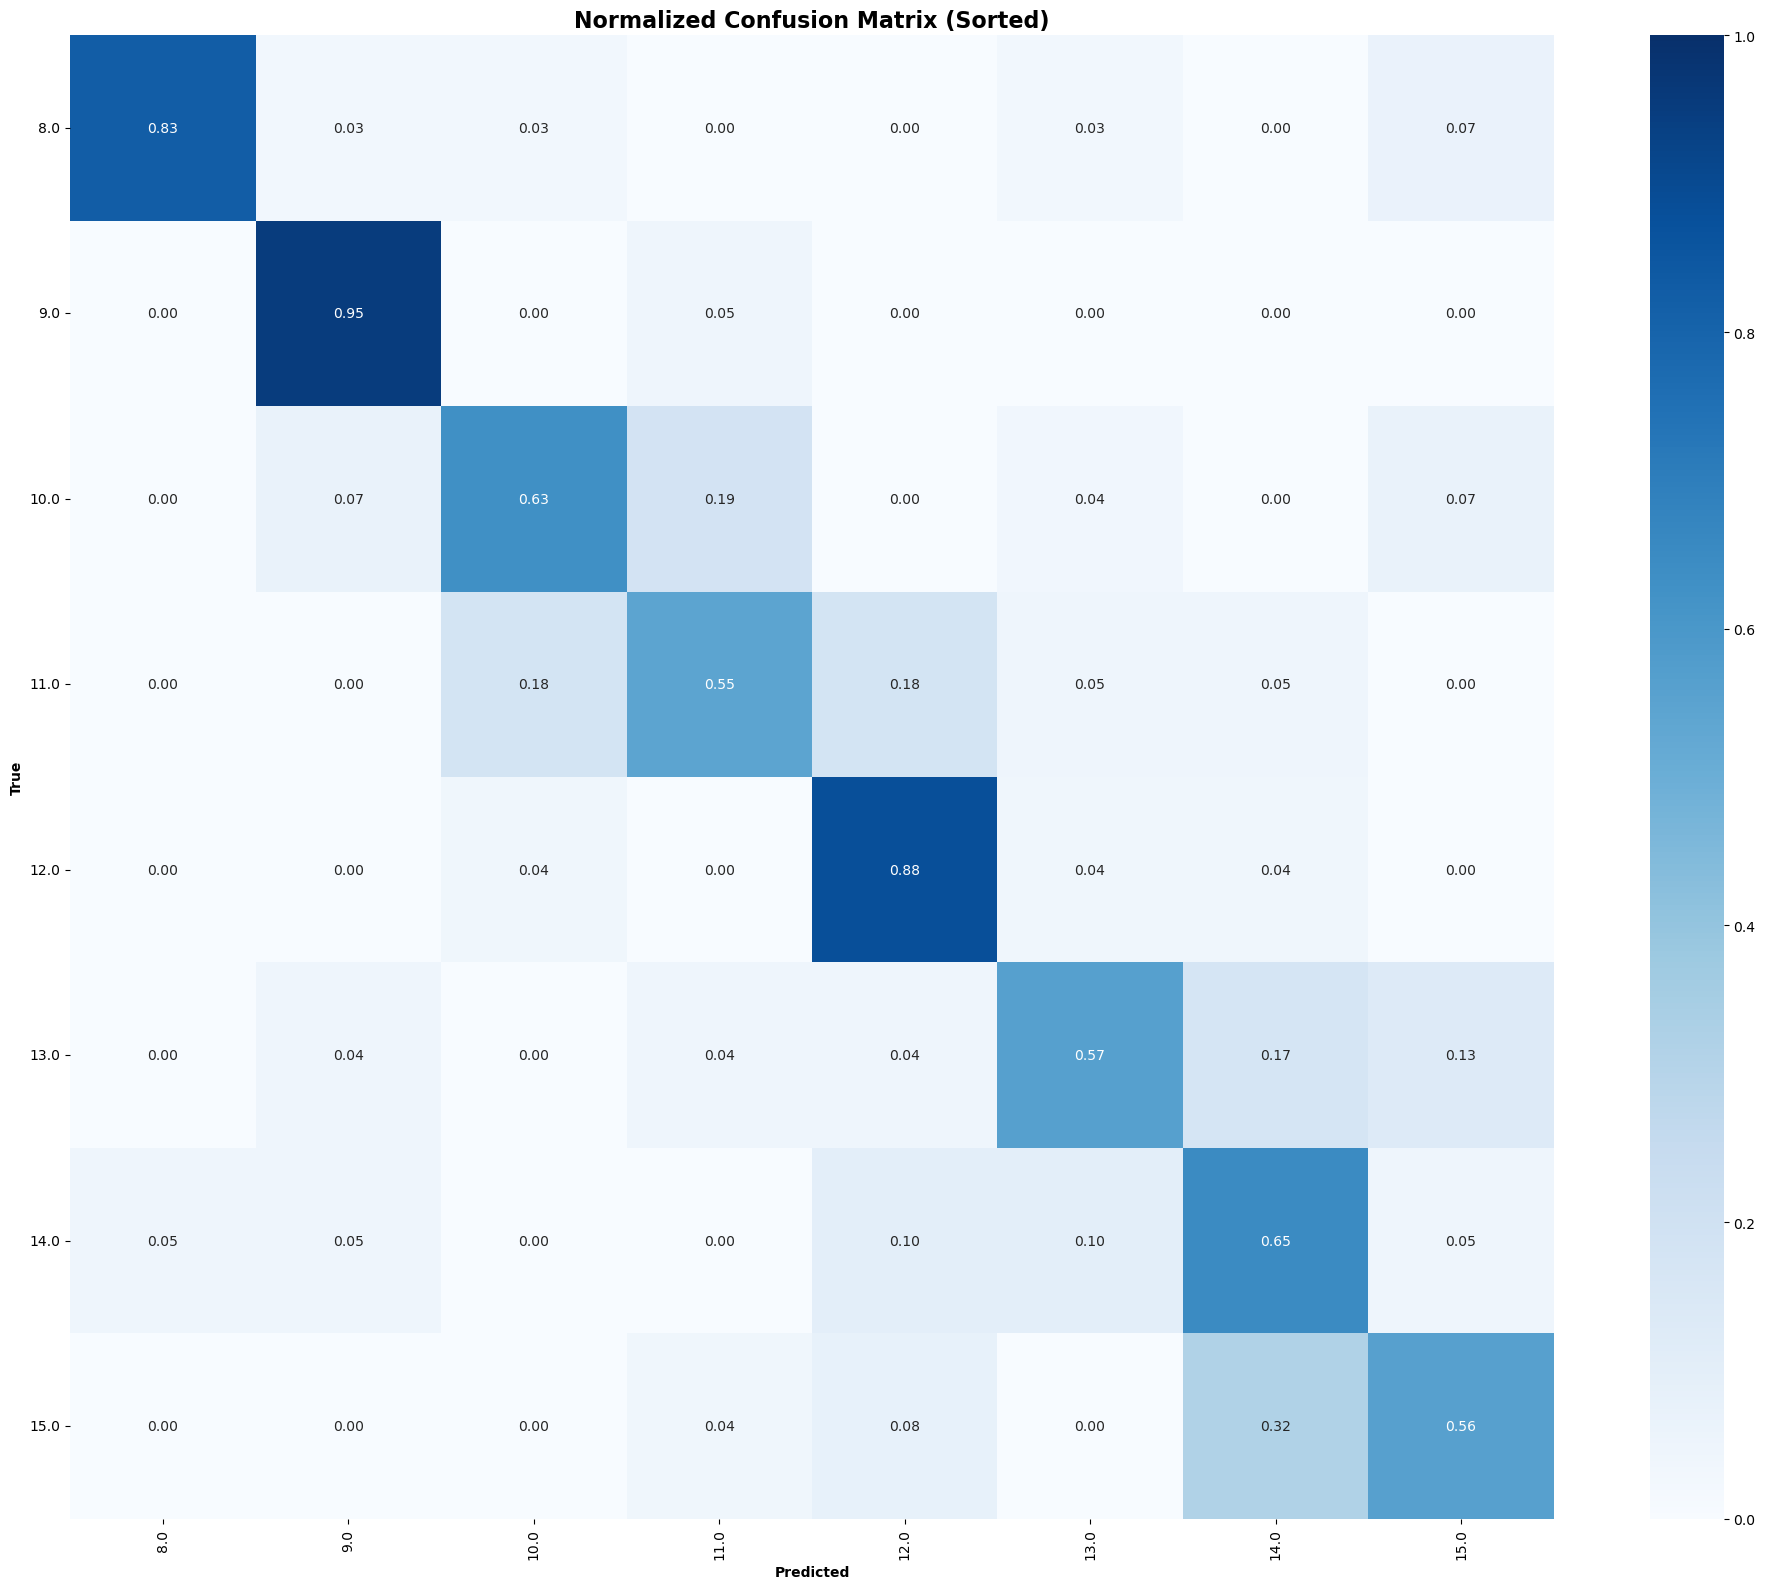

Test set Accuracy: 0.7031
Recall: 0.7031
F1 Score: 0.7021
Confusion Matrix:
[[24  1  1  0  0  1  0  2]
 [ 0 20  0  1  0  0  0  0]
 [ 0  2 17  5  0  1  0  2]
 [ 0  0  4 12  4  1  1  0]
 [ 0  0  1  0 22  1  1  0]
 [ 0  1  0  1  1 13  4  3]
 [ 1  1  0  0  2  2 13  1]
 [ 0  0  0  1  2  0  8 14]]
Testing on subject 5.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

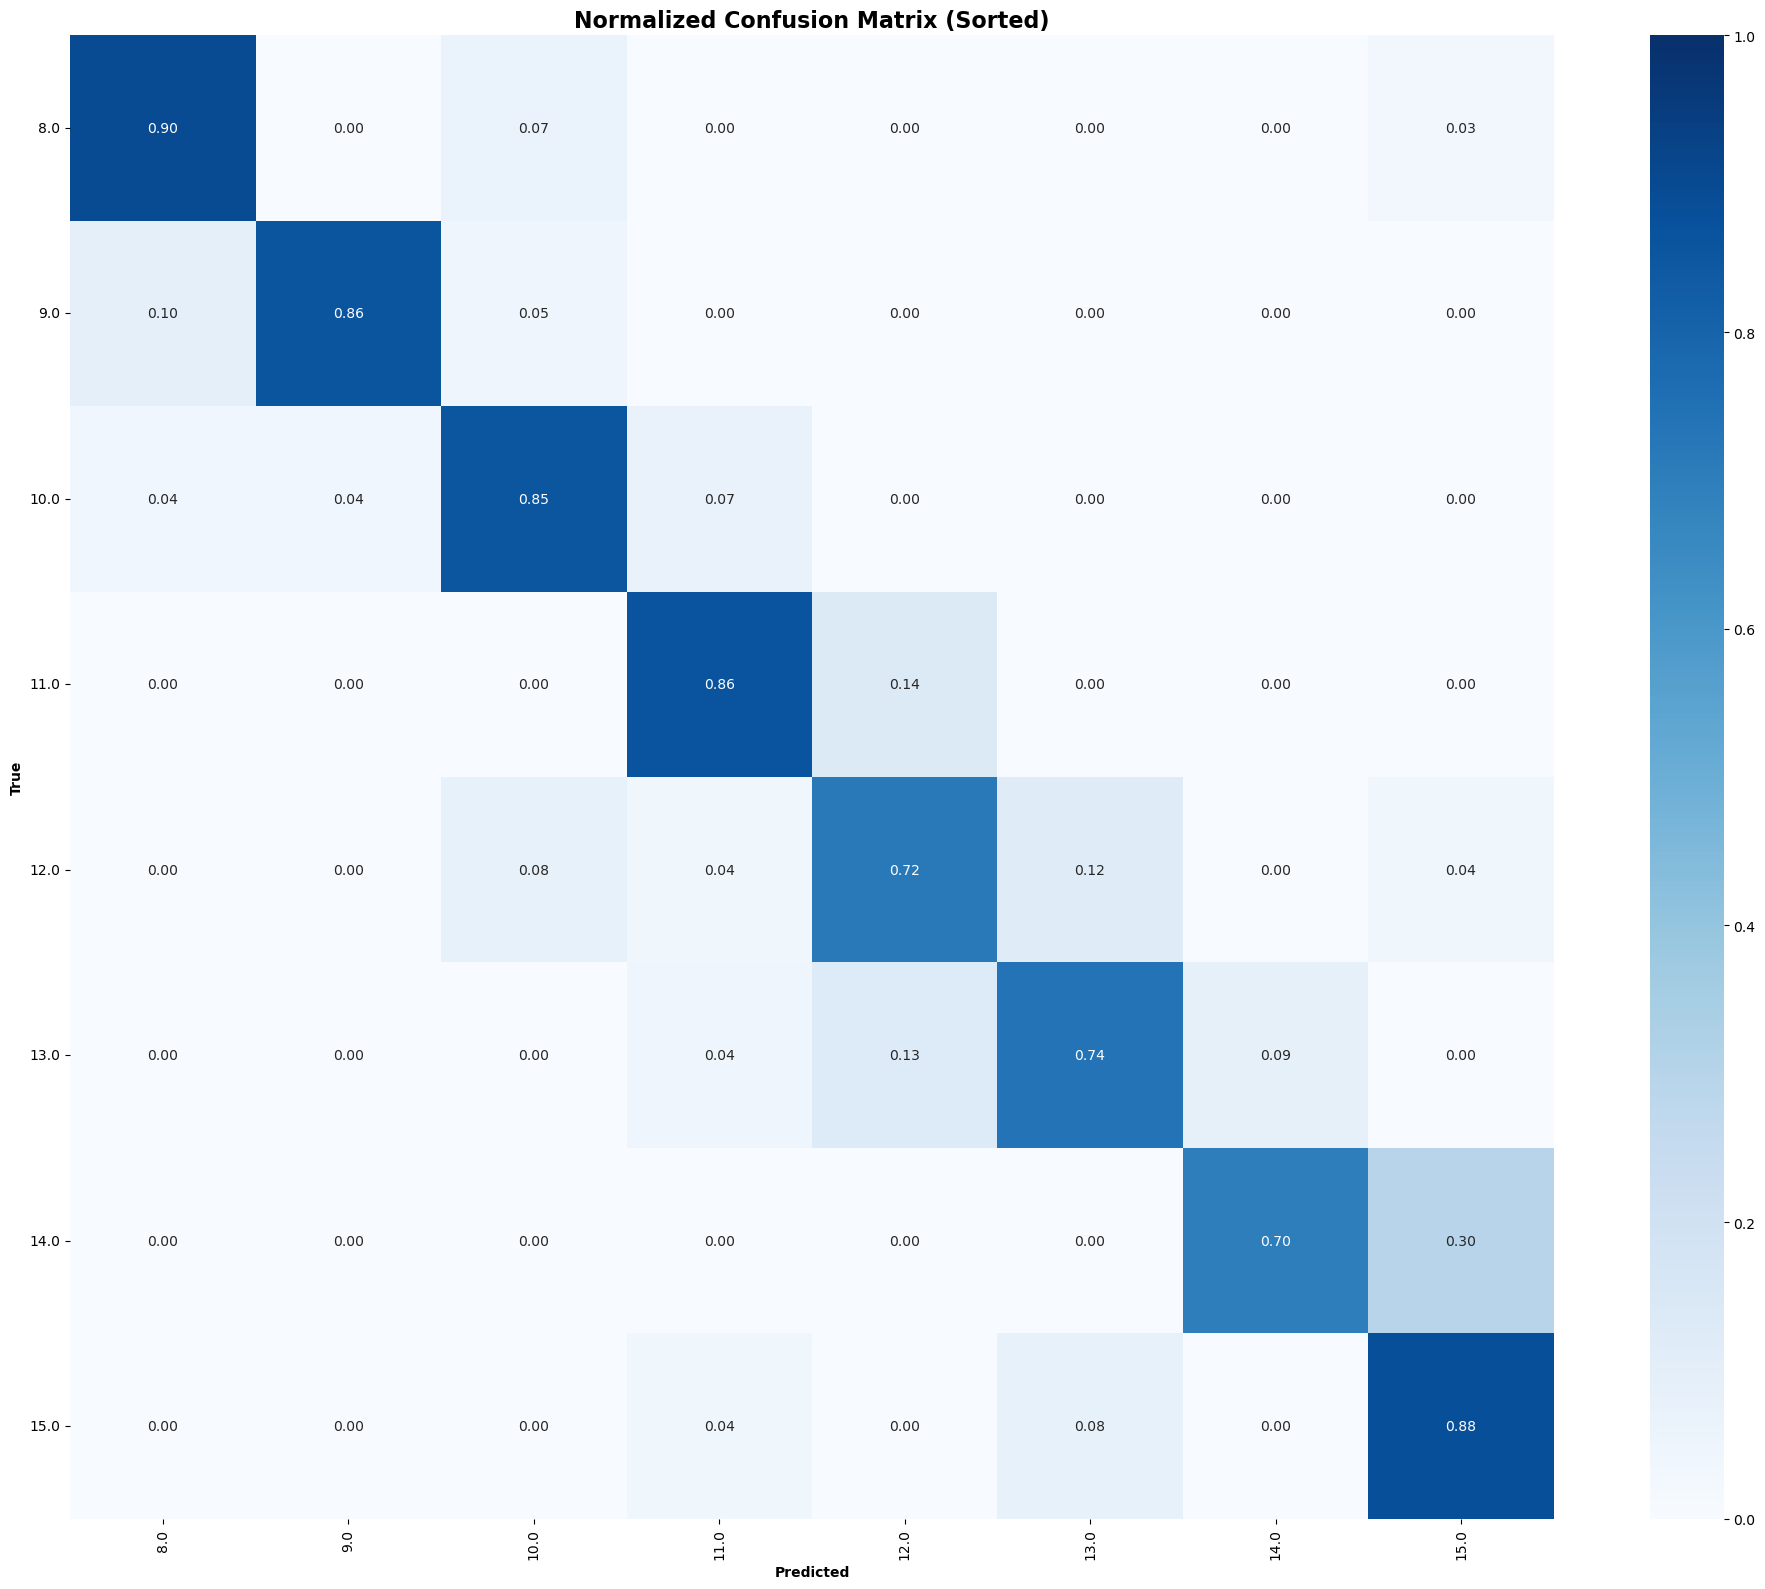

Test set Accuracy: 0.8177
Recall: 0.8177
F1 Score: 0.8175
Confusion Matrix:
[[26  0  2  0  0  0  0  1]
 [ 2 18  1  0  0  0  0  0]
 [ 1  1 23  2  0  0  0  0]
 [ 0  0  0 19  3  0  0  0]
 [ 0  0  2  1 18  3  0  1]
 [ 0  0  0  1  3 17  2  0]
 [ 0  0  0  0  0  0 14  6]
 [ 0  0  0  1  0  2  0 22]]
Testing on subject 6.


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


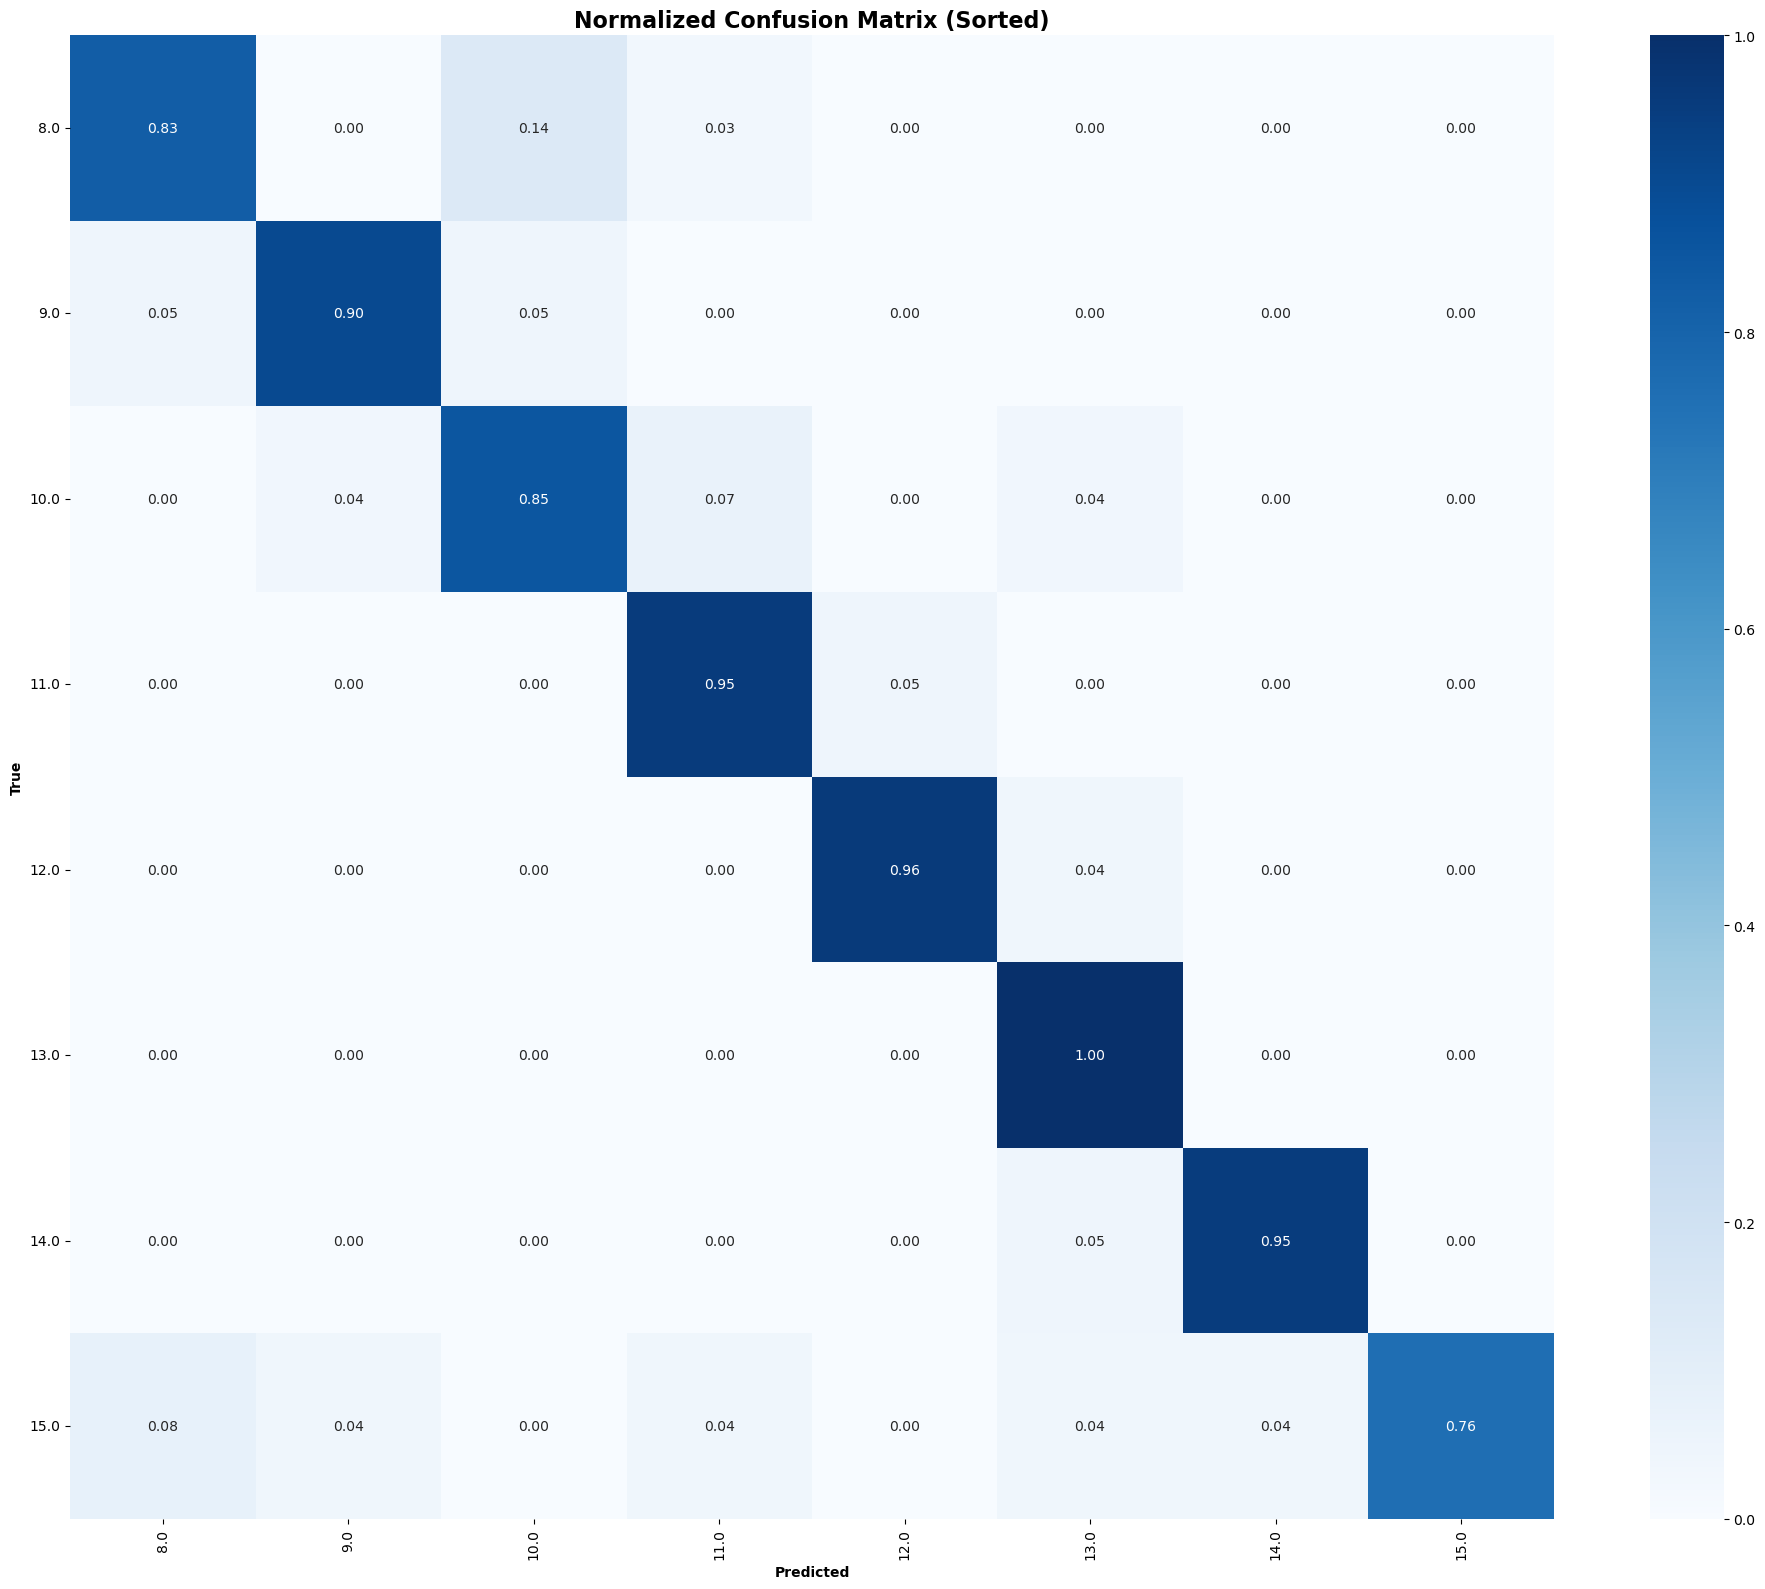

Test set Accuracy: 0.8958
Recall: 0.8958
F1 Score: 0.8950
Confusion Matrix:
[[24  0  4  1  0  0  0  0]
 [ 1 19  1  0  0  0  0  0]
 [ 0  1 23  2  0  1  0  0]
 [ 0  0  0 21  1  0  0  0]
 [ 0  0  0  0 24  1  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  1 19  0]
 [ 2  1  0  1  0  1  1 19]]
Testing on subject 7.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

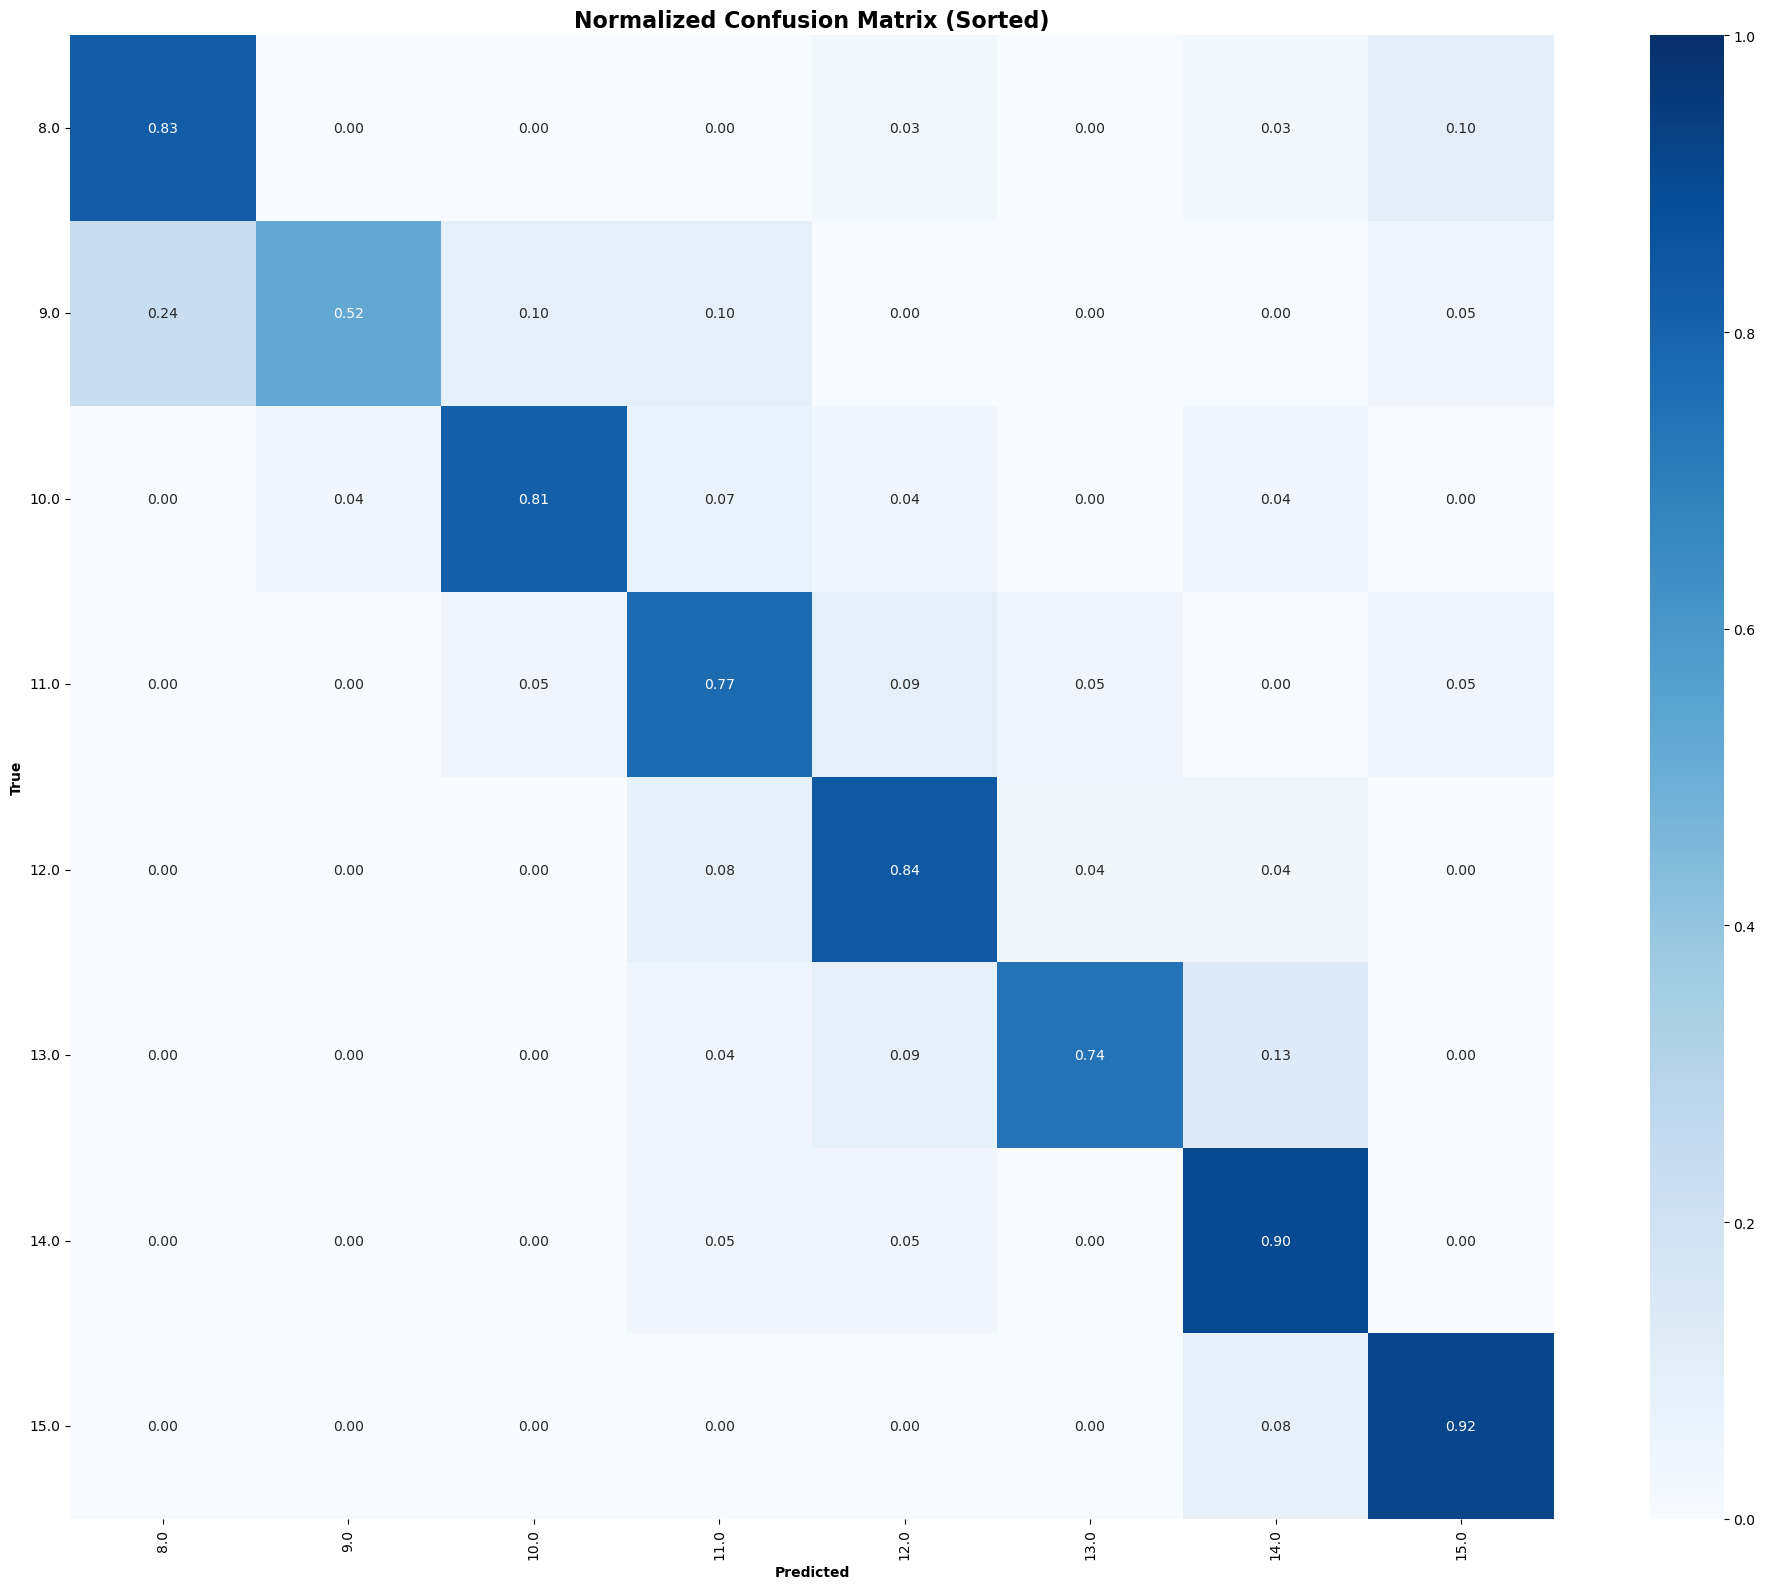

Test set Accuracy: 0.7969
Recall: 0.7969
F1 Score: 0.7945
Confusion Matrix:
[[24  0  0  0  1  0  1  3]
 [ 5 11  2  2  0  0  0  1]
 [ 0  1 22  2  1  0  1  0]
 [ 0  0  1 17  2  1  0  1]
 [ 0  0  0  2 21  1  1  0]
 [ 0  0  0  1  2 17  3  0]
 [ 0  0  0  1  1  0 18  0]
 [ 0  0  0  0  0  0  2 23]]
Testing on subject 8.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

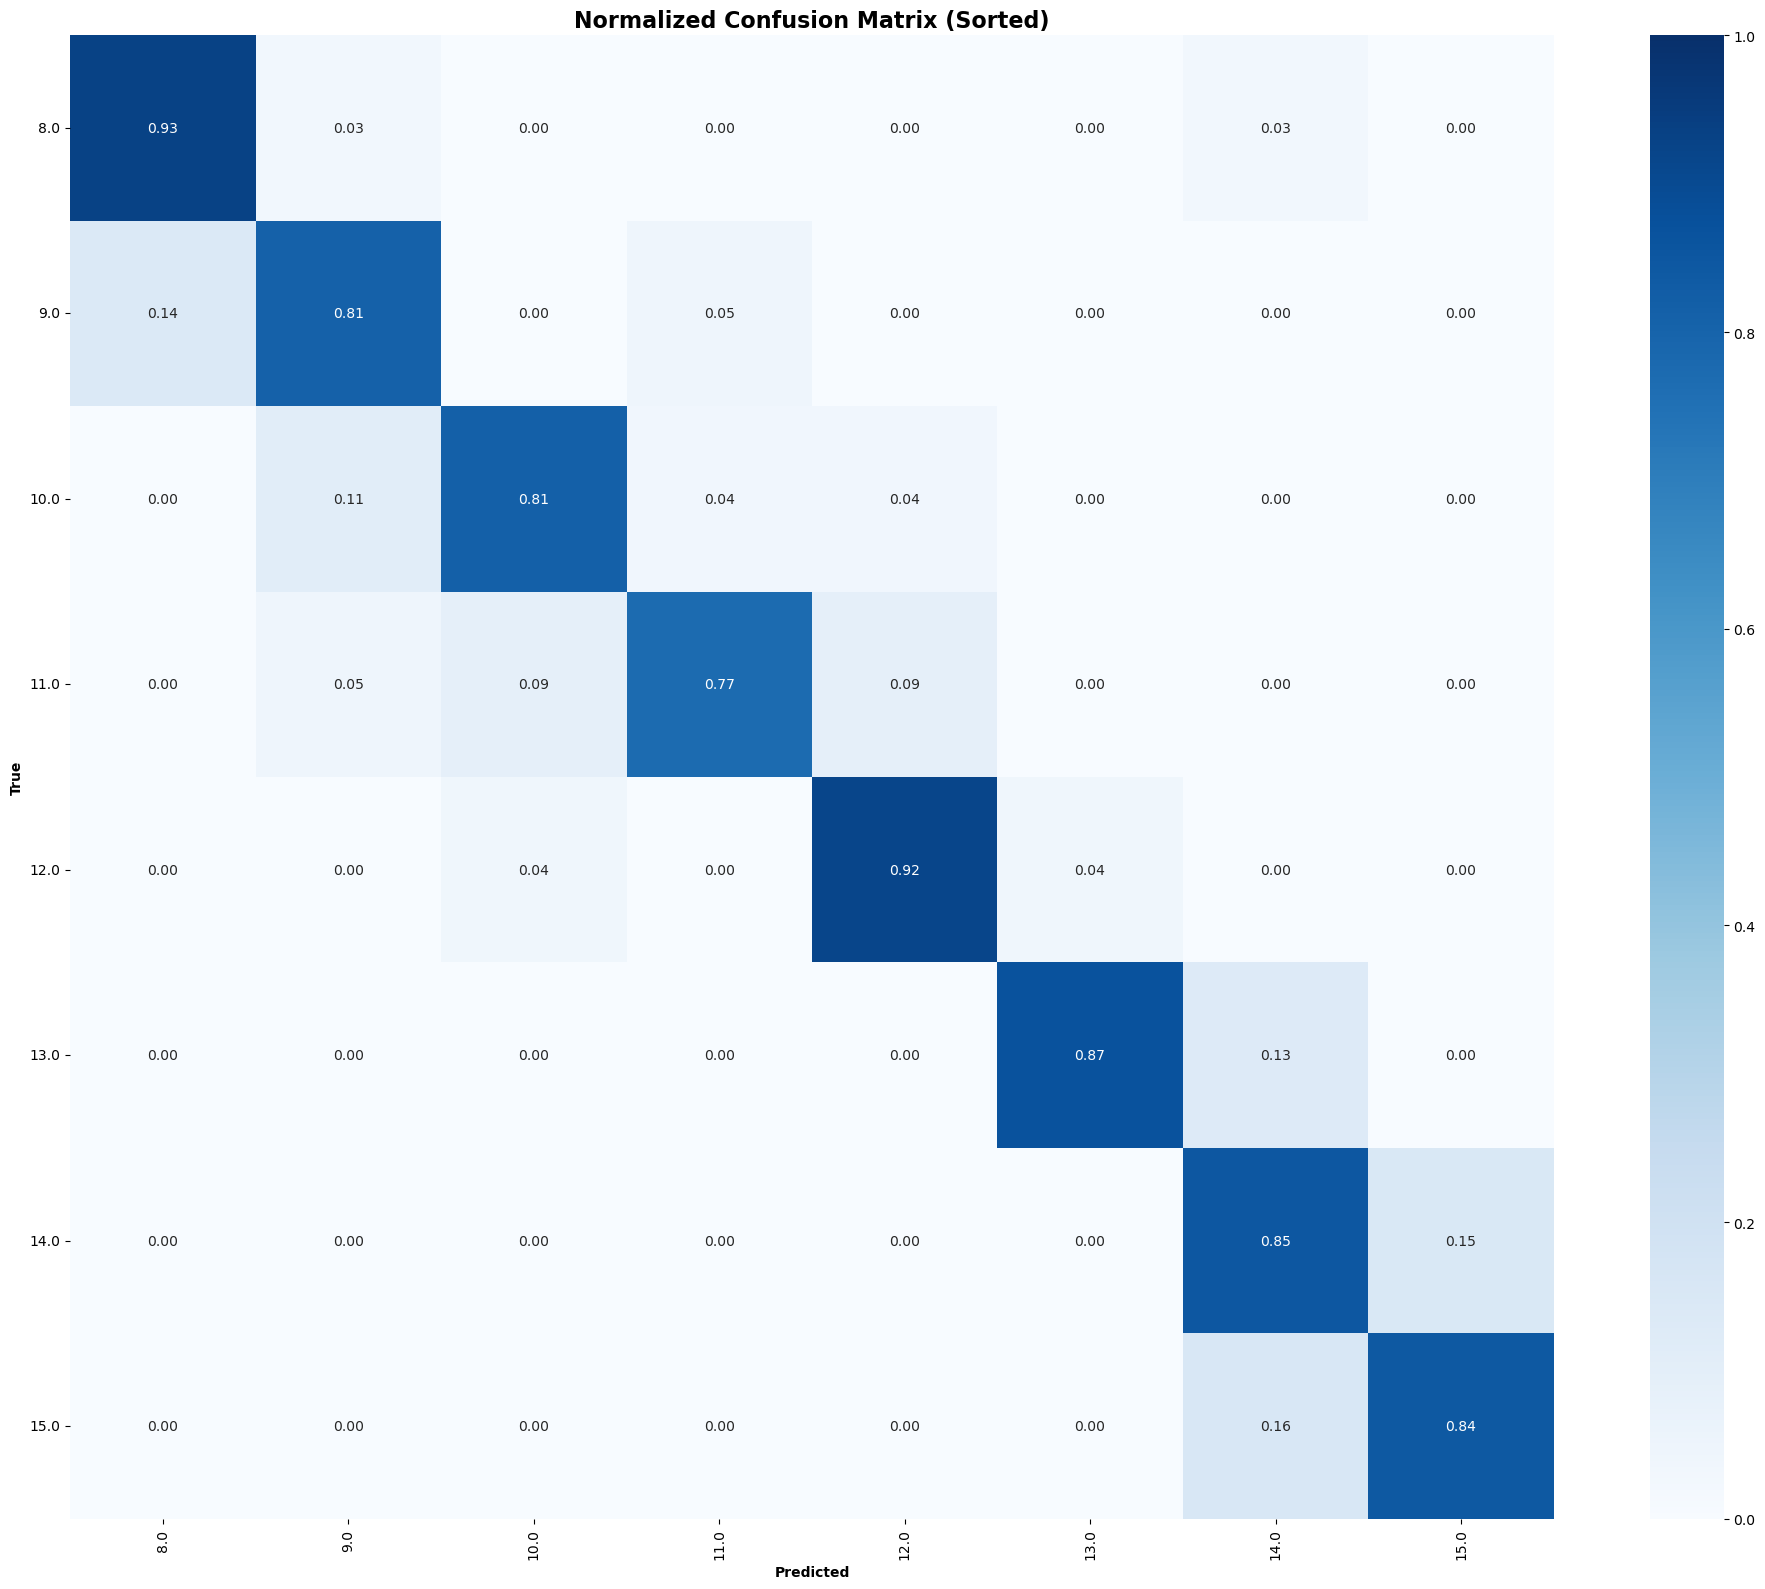

Test set Accuracy: 0.8542
Recall: 0.8542
F1 Score: 0.8554
Confusion Matrix:
[[27  1  0  0  0  0  1  0]
 [ 3 17  0  1  0  0  0  0]
 [ 0  3 22  1  1  0  0  0]
 [ 0  1  2 17  2  0  0  0]
 [ 0  0  1  0 23  1  0  0]
 [ 0  0  0  0  0 20  3  0]
 [ 0  0  0  0  0  0 17  3]
 [ 0  0  0  0  0  0  4 21]]
Testing on subject 9.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

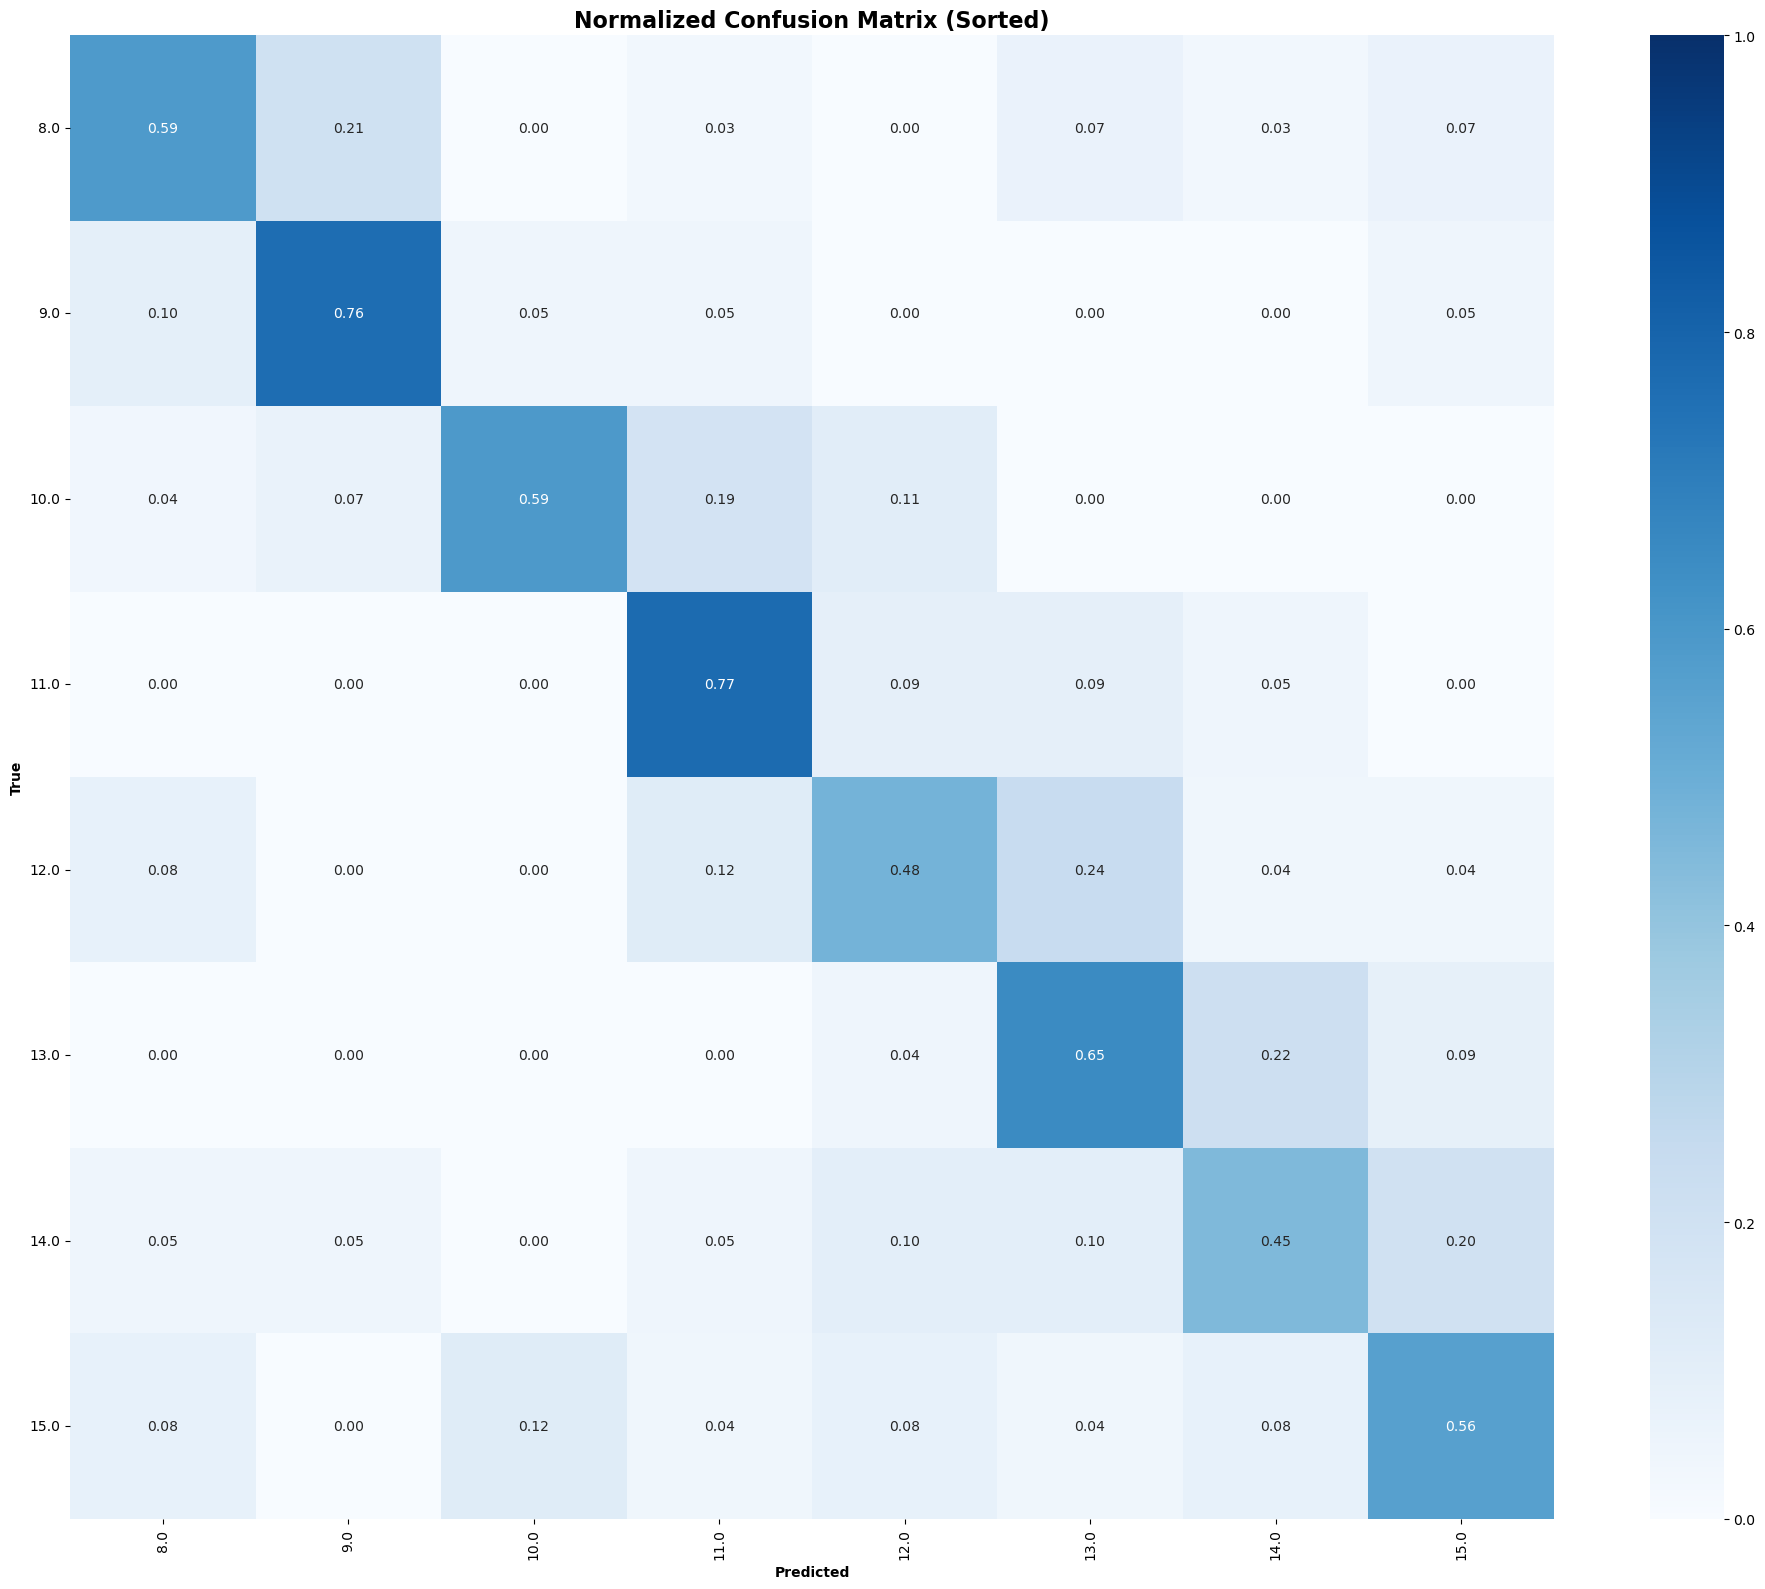

Test set Accuracy: 0.6042
Recall: 0.6042
F1 Score: 0.6028
Confusion Matrix:
[[17  6  0  1  0  2  1  2]
 [ 2 16  1  1  0  0  0  1]
 [ 1  2 16  5  3  0  0  0]
 [ 0  0  0 17  2  2  1  0]
 [ 2  0  0  3 12  6  1  1]
 [ 0  0  0  0  1 15  5  2]
 [ 1  1  0  1  2  2  9  4]
 [ 2  0  3  1  2  1  2 14]]
Testing on subject 10.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

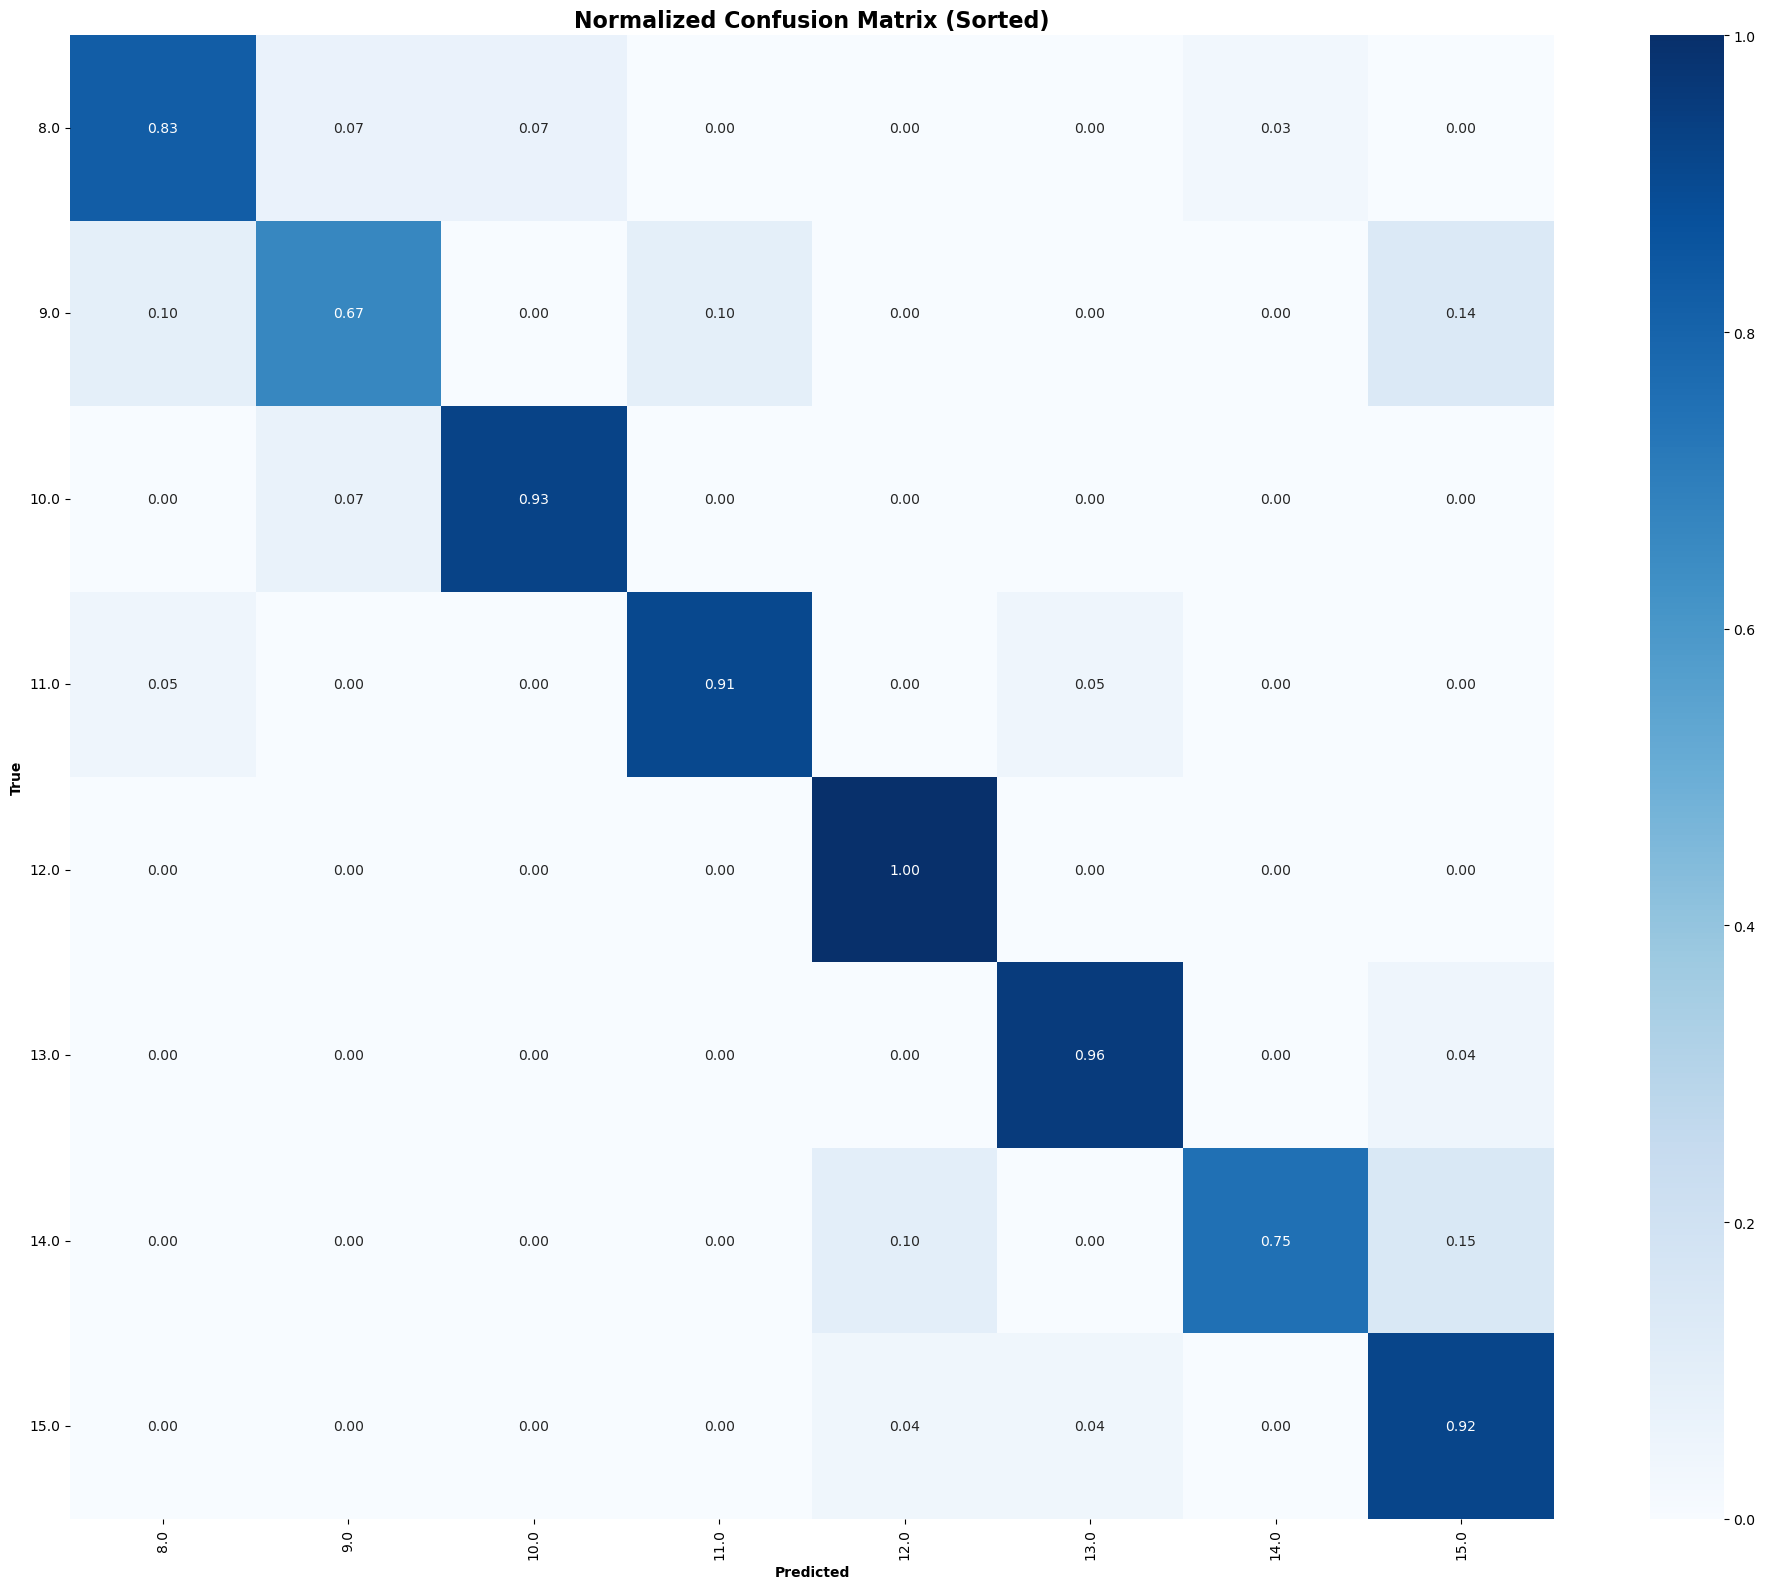

Test set Accuracy: 0.8750
Recall: 0.8750
F1 Score: 0.8731
Confusion Matrix:
[[24  2  2  0  0  0  1  0]
 [ 2 14  0  2  0  0  0  3]
 [ 0  2 25  0  0  0  0  0]
 [ 1  0  0 20  0  1  0  0]
 [ 0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0 22  0  1]
 [ 0  0  0  0  2  0 15  3]
 [ 0  0  0  0  1  1  0 23]]
Testing on subject 11.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

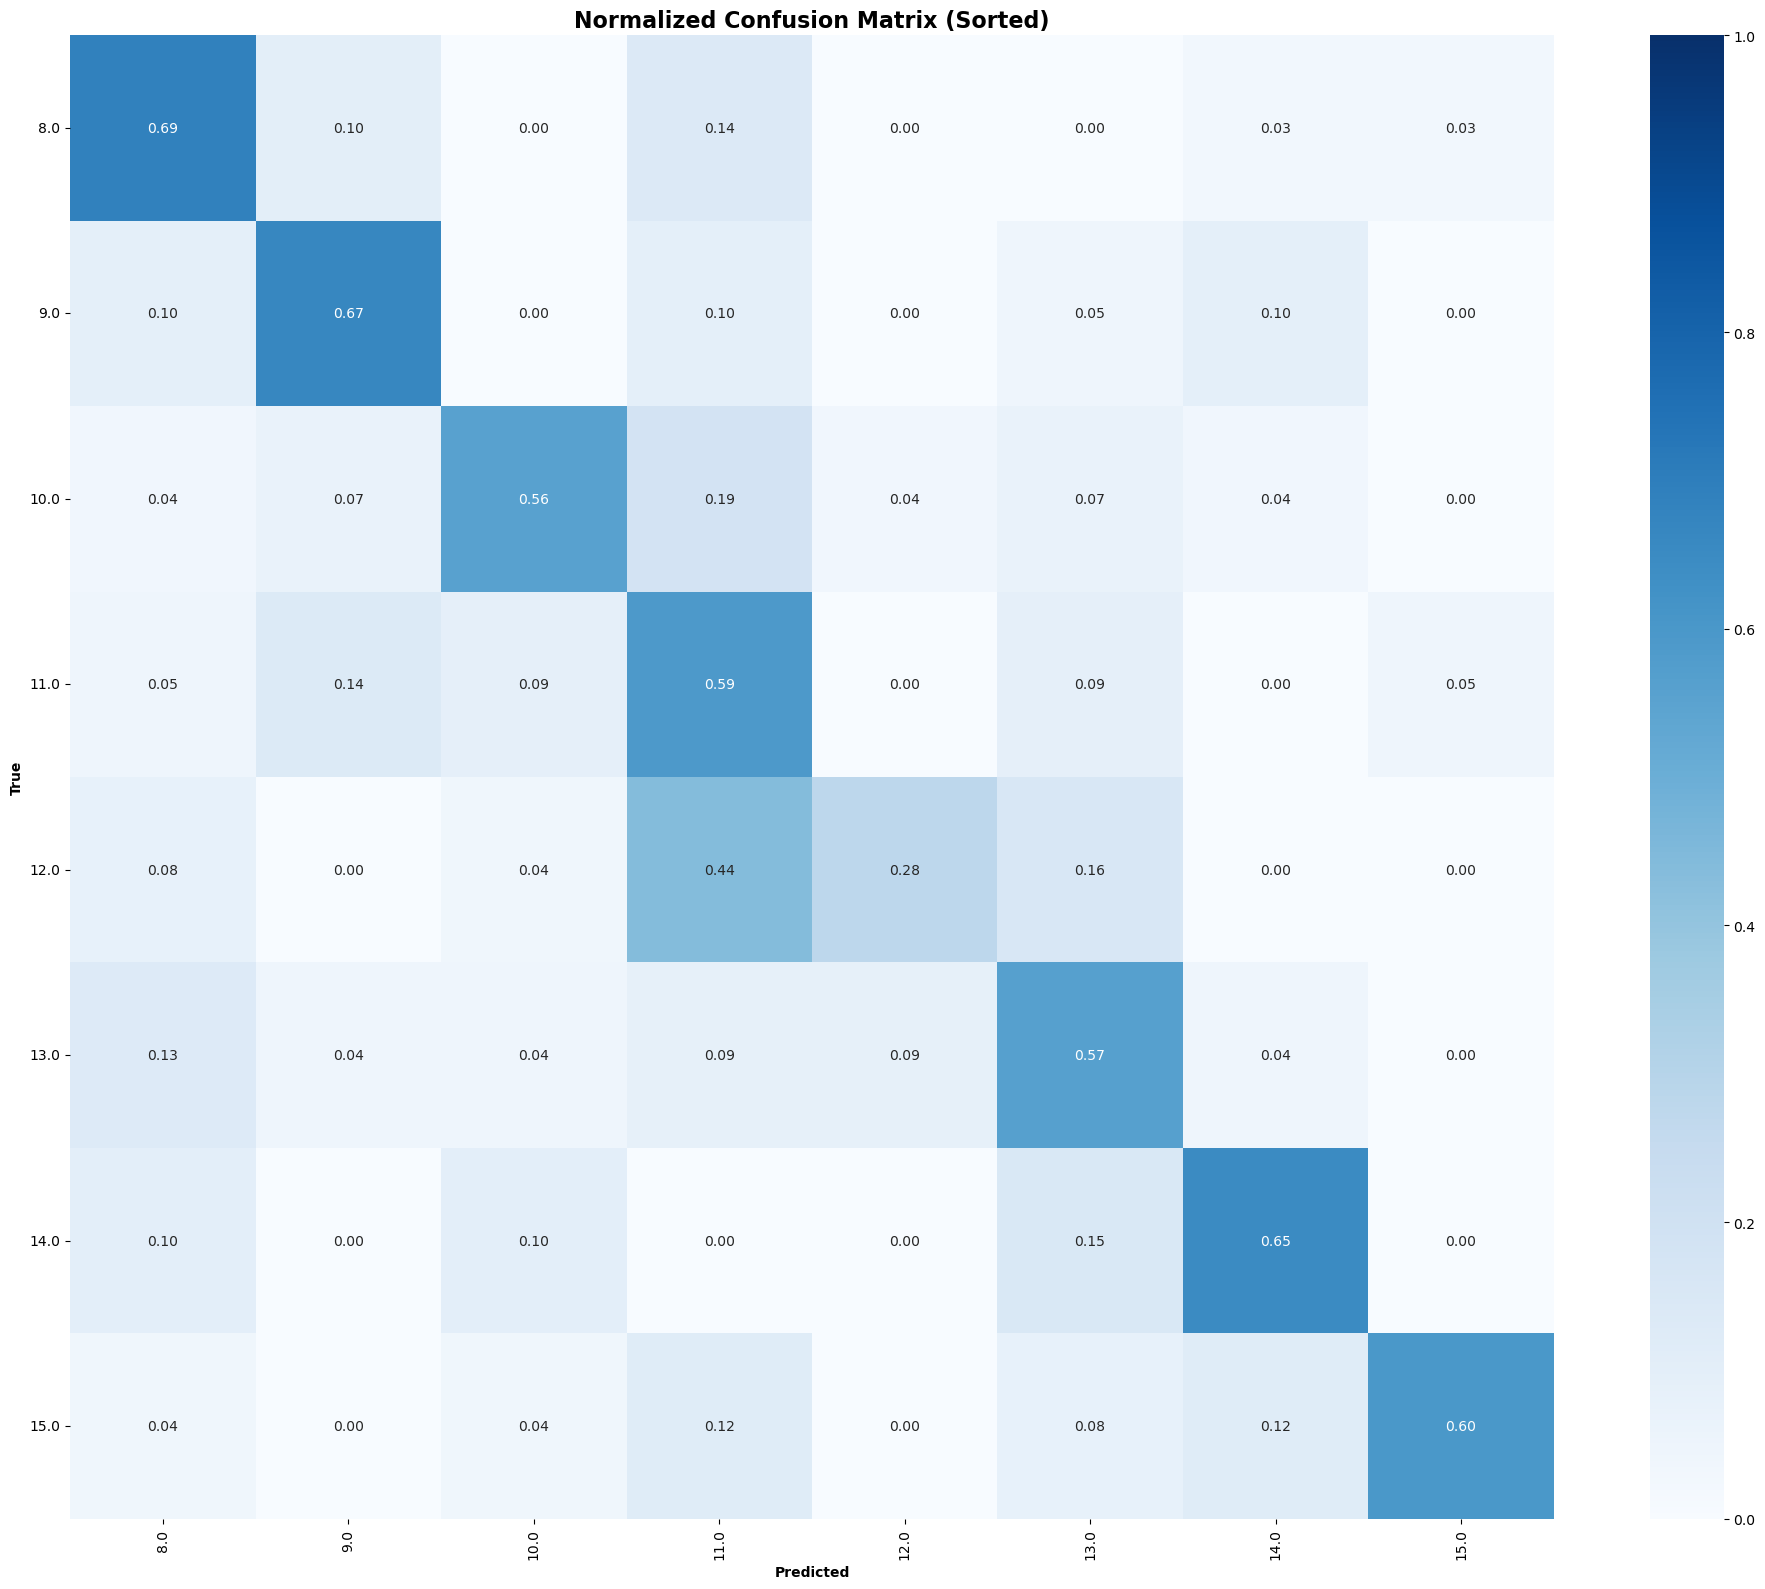

Test set Accuracy: 0.5729
Recall: 0.5729
F1 Score: 0.5762
Confusion Matrix:
[[20  3  0  4  0  0  1  1]
 [ 2 14  0  2  0  1  2  0]
 [ 1  2 15  5  1  2  1  0]
 [ 1  3  2 13  0  2  0  1]
 [ 2  0  1 11  7  4  0  0]
 [ 3  1  1  2  2 13  1  0]
 [ 2  0  2  0  0  3 13  0]
 [ 1  0  1  3  0  2  3 15]]
Testing on subject 12.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

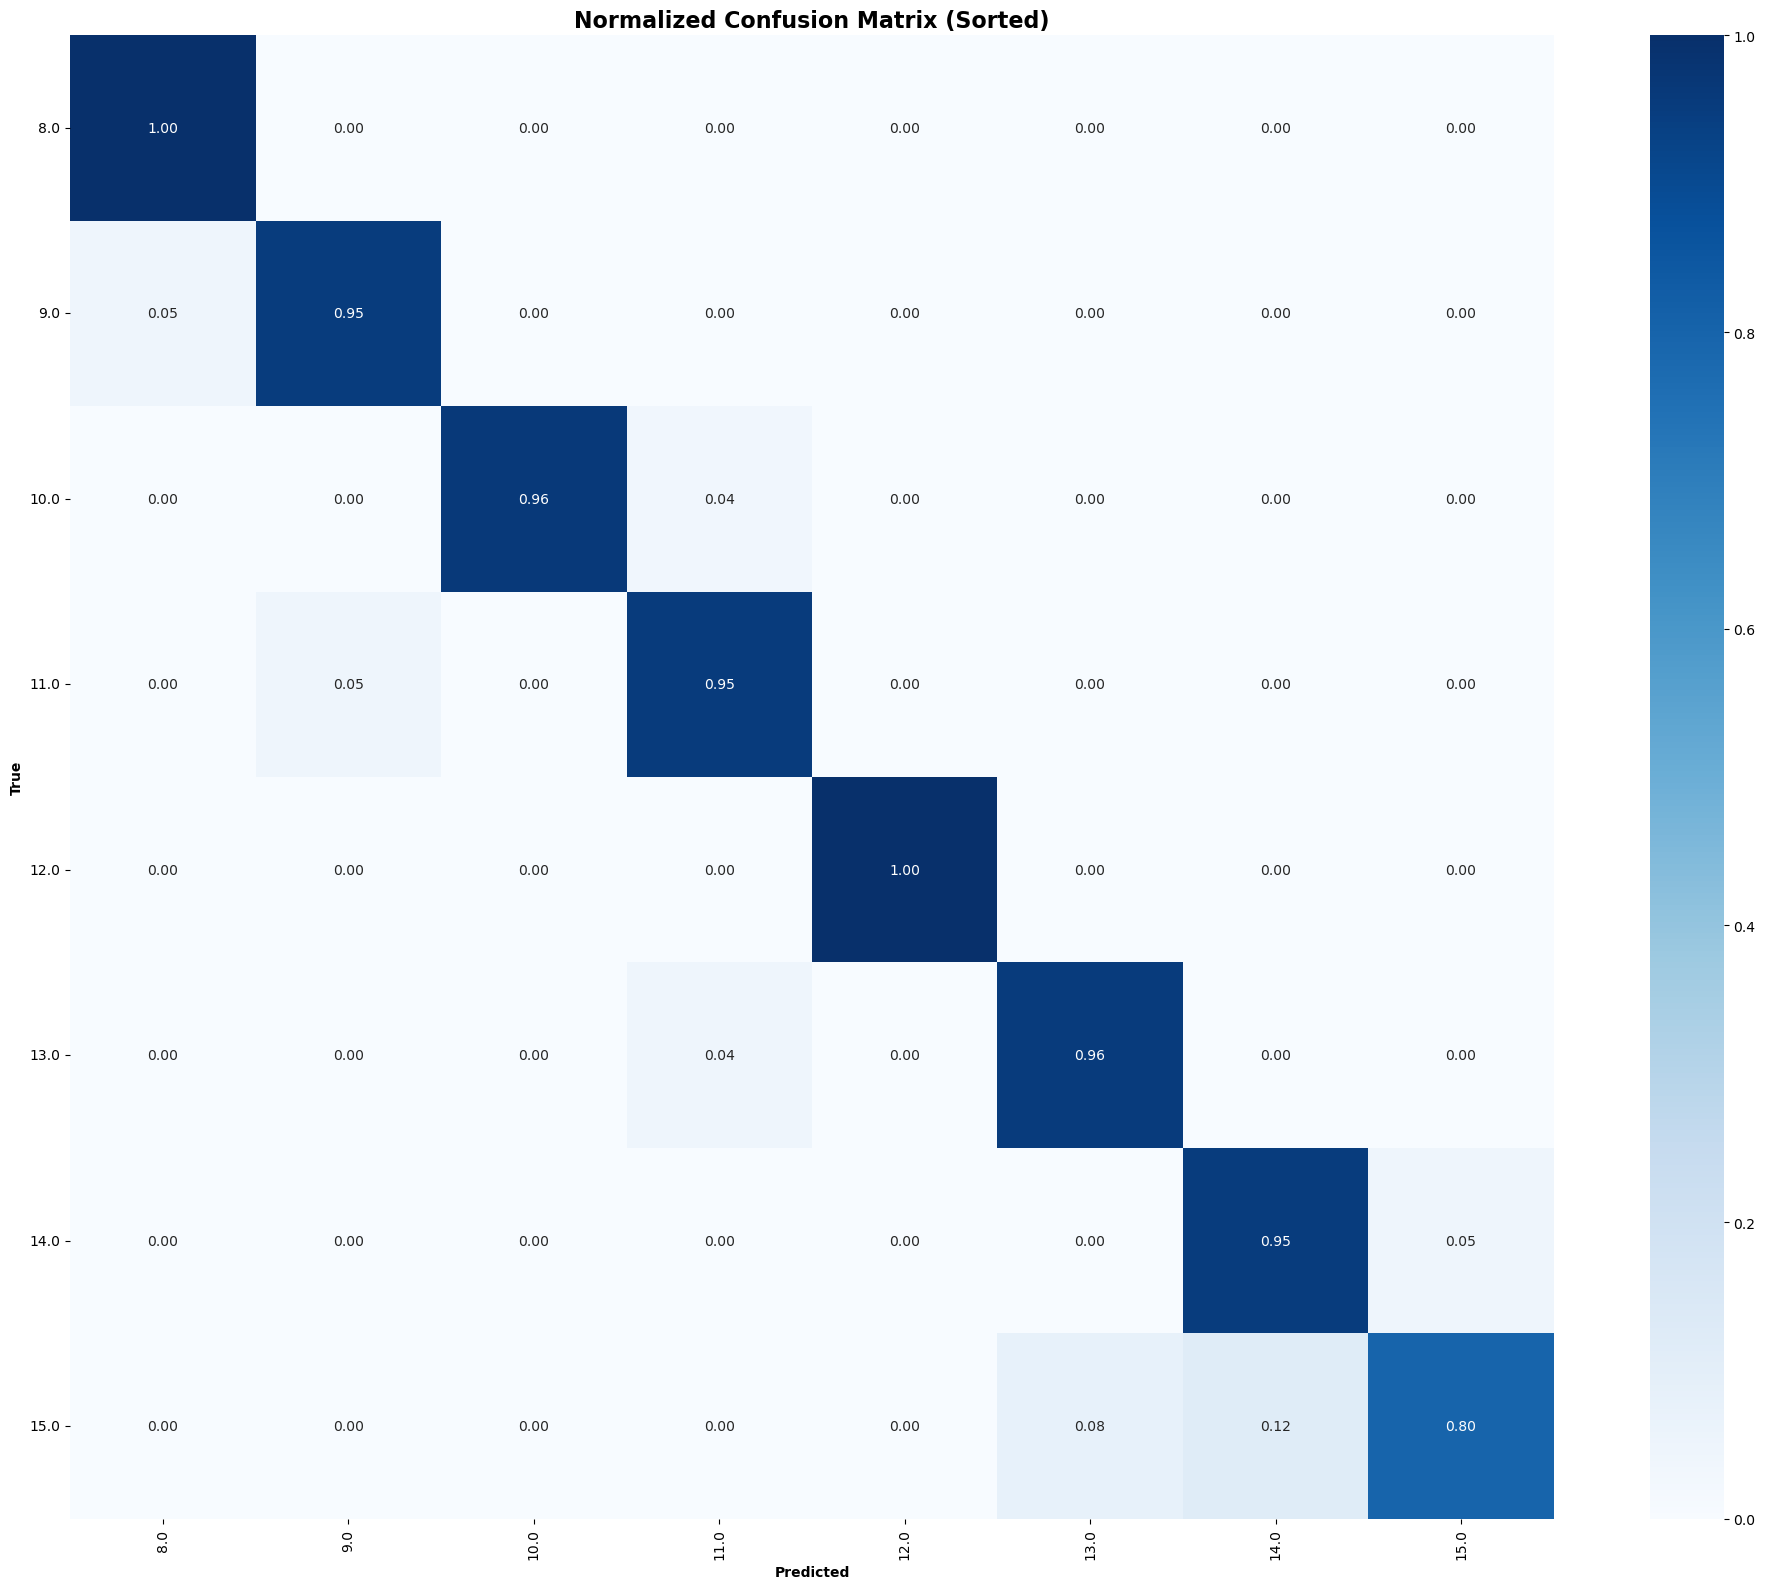

Test set Accuracy: 0.9479
Recall: 0.9479
F1 Score: 0.9474
Confusion Matrix:
[[29  0  0  0  0  0  0  0]
 [ 1 20  0  0  0  0  0  0]
 [ 0  0 26  1  0  0  0  0]
 [ 0  1  0 21  0  0  0  0]
 [ 0  0  0  0 25  0  0  0]
 [ 0  0  0  1  0 22  0  0]
 [ 0  0  0  0  0  0 19  1]
 [ 0  0  0  0  0  2  3 20]]
Testing on subject 13.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

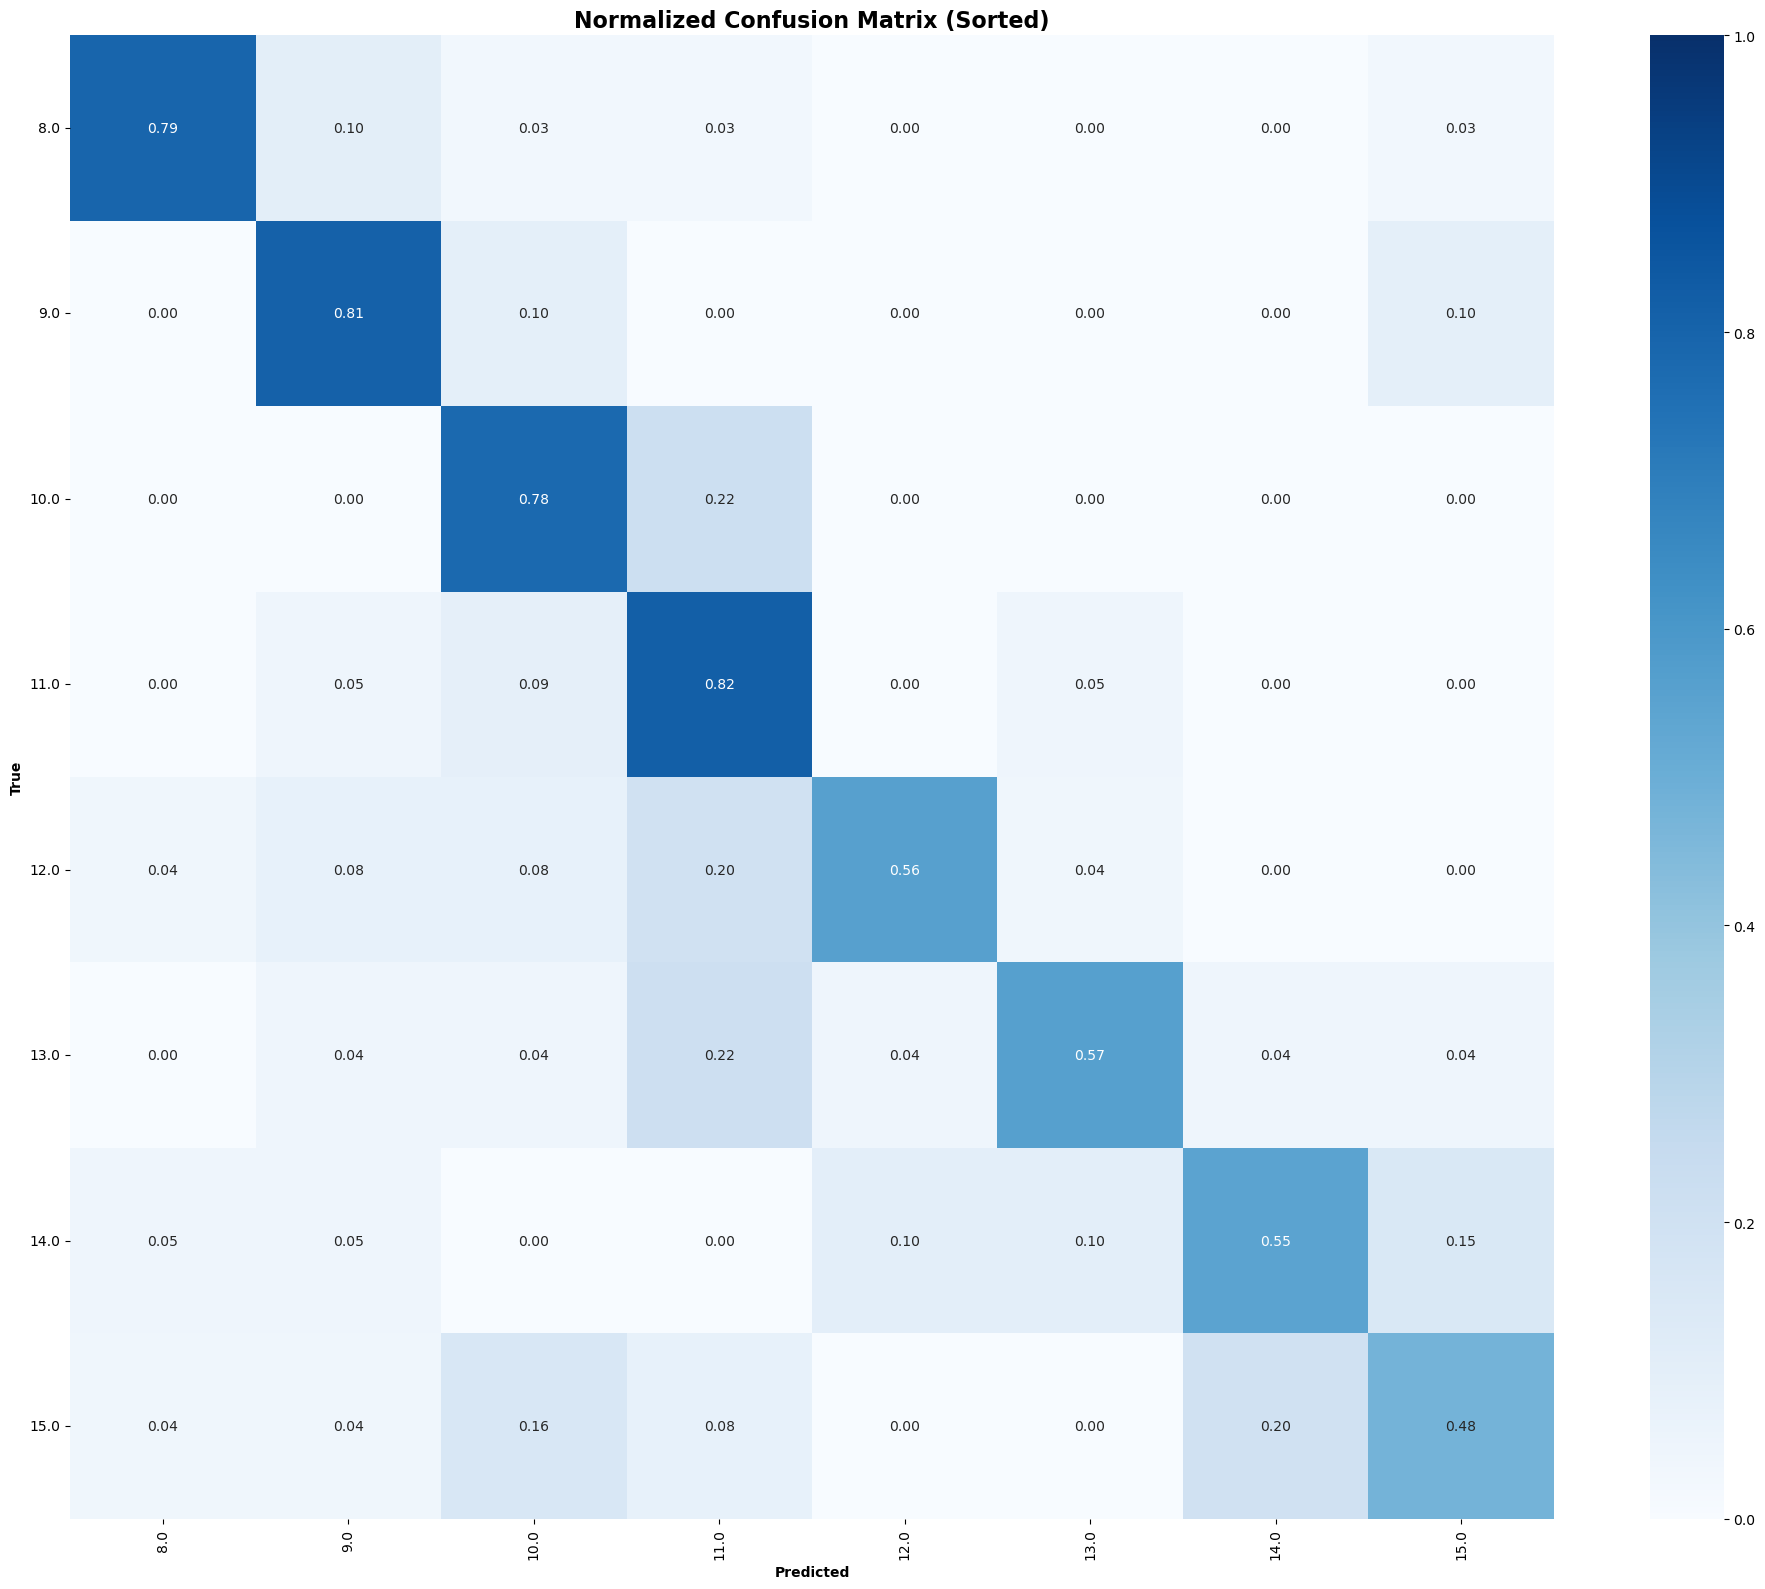

Test set Accuracy: 0.6719
Recall: 0.6719
F1 Score: 0.6714
Confusion Matrix:
[[23  3  1  1  0  0  0  1]
 [ 0 17  2  0  0  0  0  2]
 [ 0  0 21  6  0  0  0  0]
 [ 0  1  2 18  0  1  0  0]
 [ 1  2  2  5 14  1  0  0]
 [ 0  1  1  5  1 13  1  1]
 [ 1  1  0  0  2  2 11  3]
 [ 1  1  4  2  0  0  5 12]]
Testing on subject 14.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

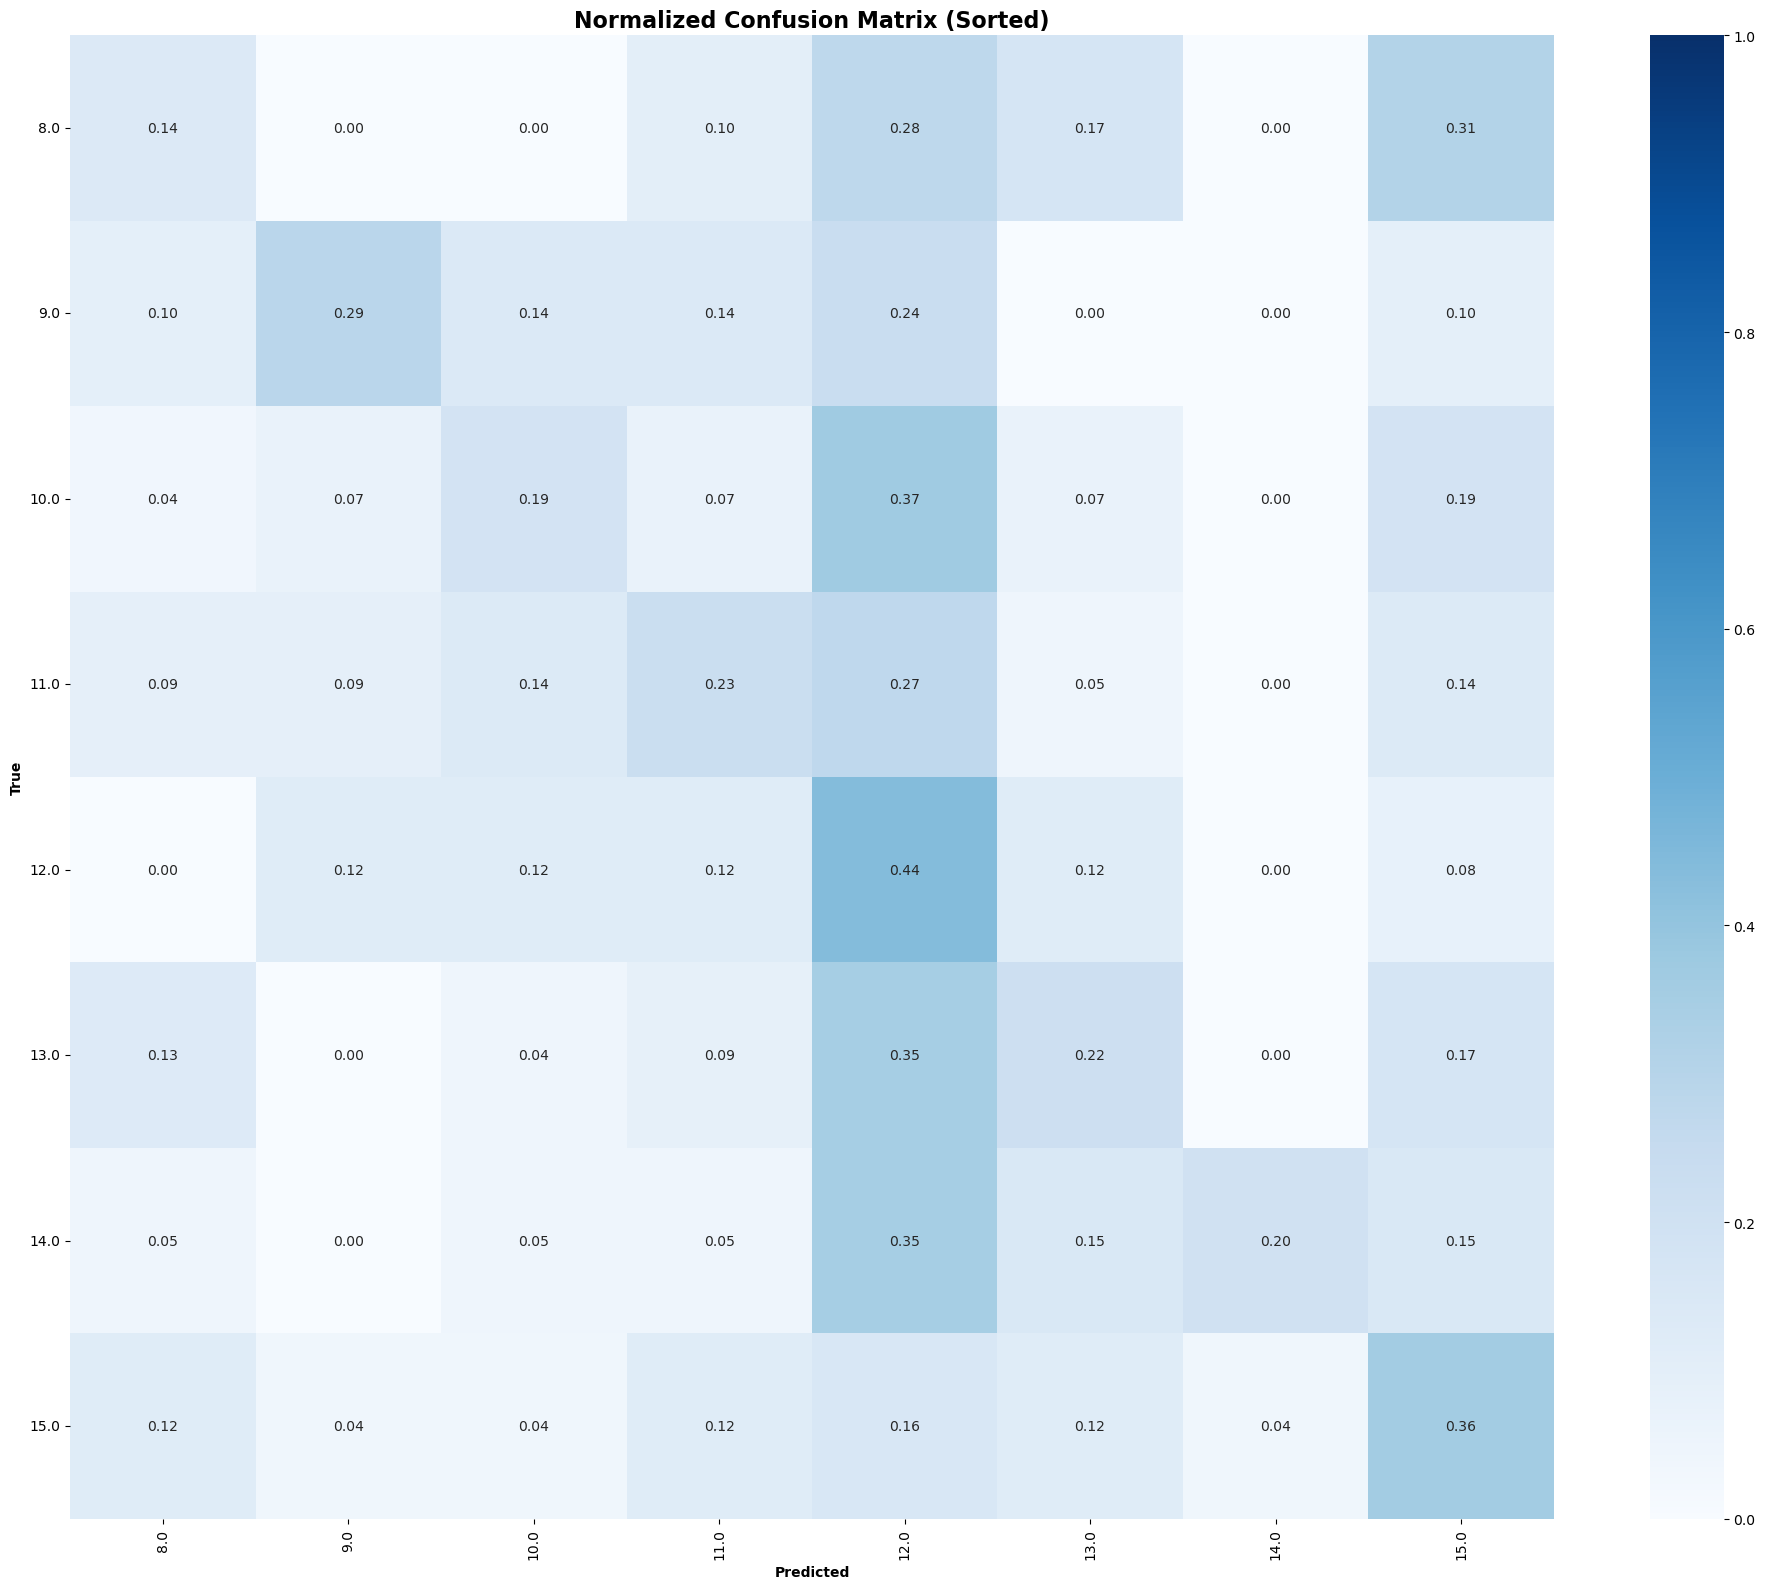

Test set Accuracy: 0.2552
Recall: 0.2552
F1 Score: 0.2542
Confusion Matrix:
[[ 4  0  0  3  8  5  0  9]
 [ 2  6  3  3  5  0  0  2]
 [ 1  2  5  2 10  2  0  5]
 [ 2  2  3  5  6  1  0  3]
 [ 0  3  3  3 11  3  0  2]
 [ 3  0  1  2  8  5  0  4]
 [ 1  0  1  1  7  3  4  3]
 [ 3  1  1  3  4  3  1  9]]
Testing on subject 15.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

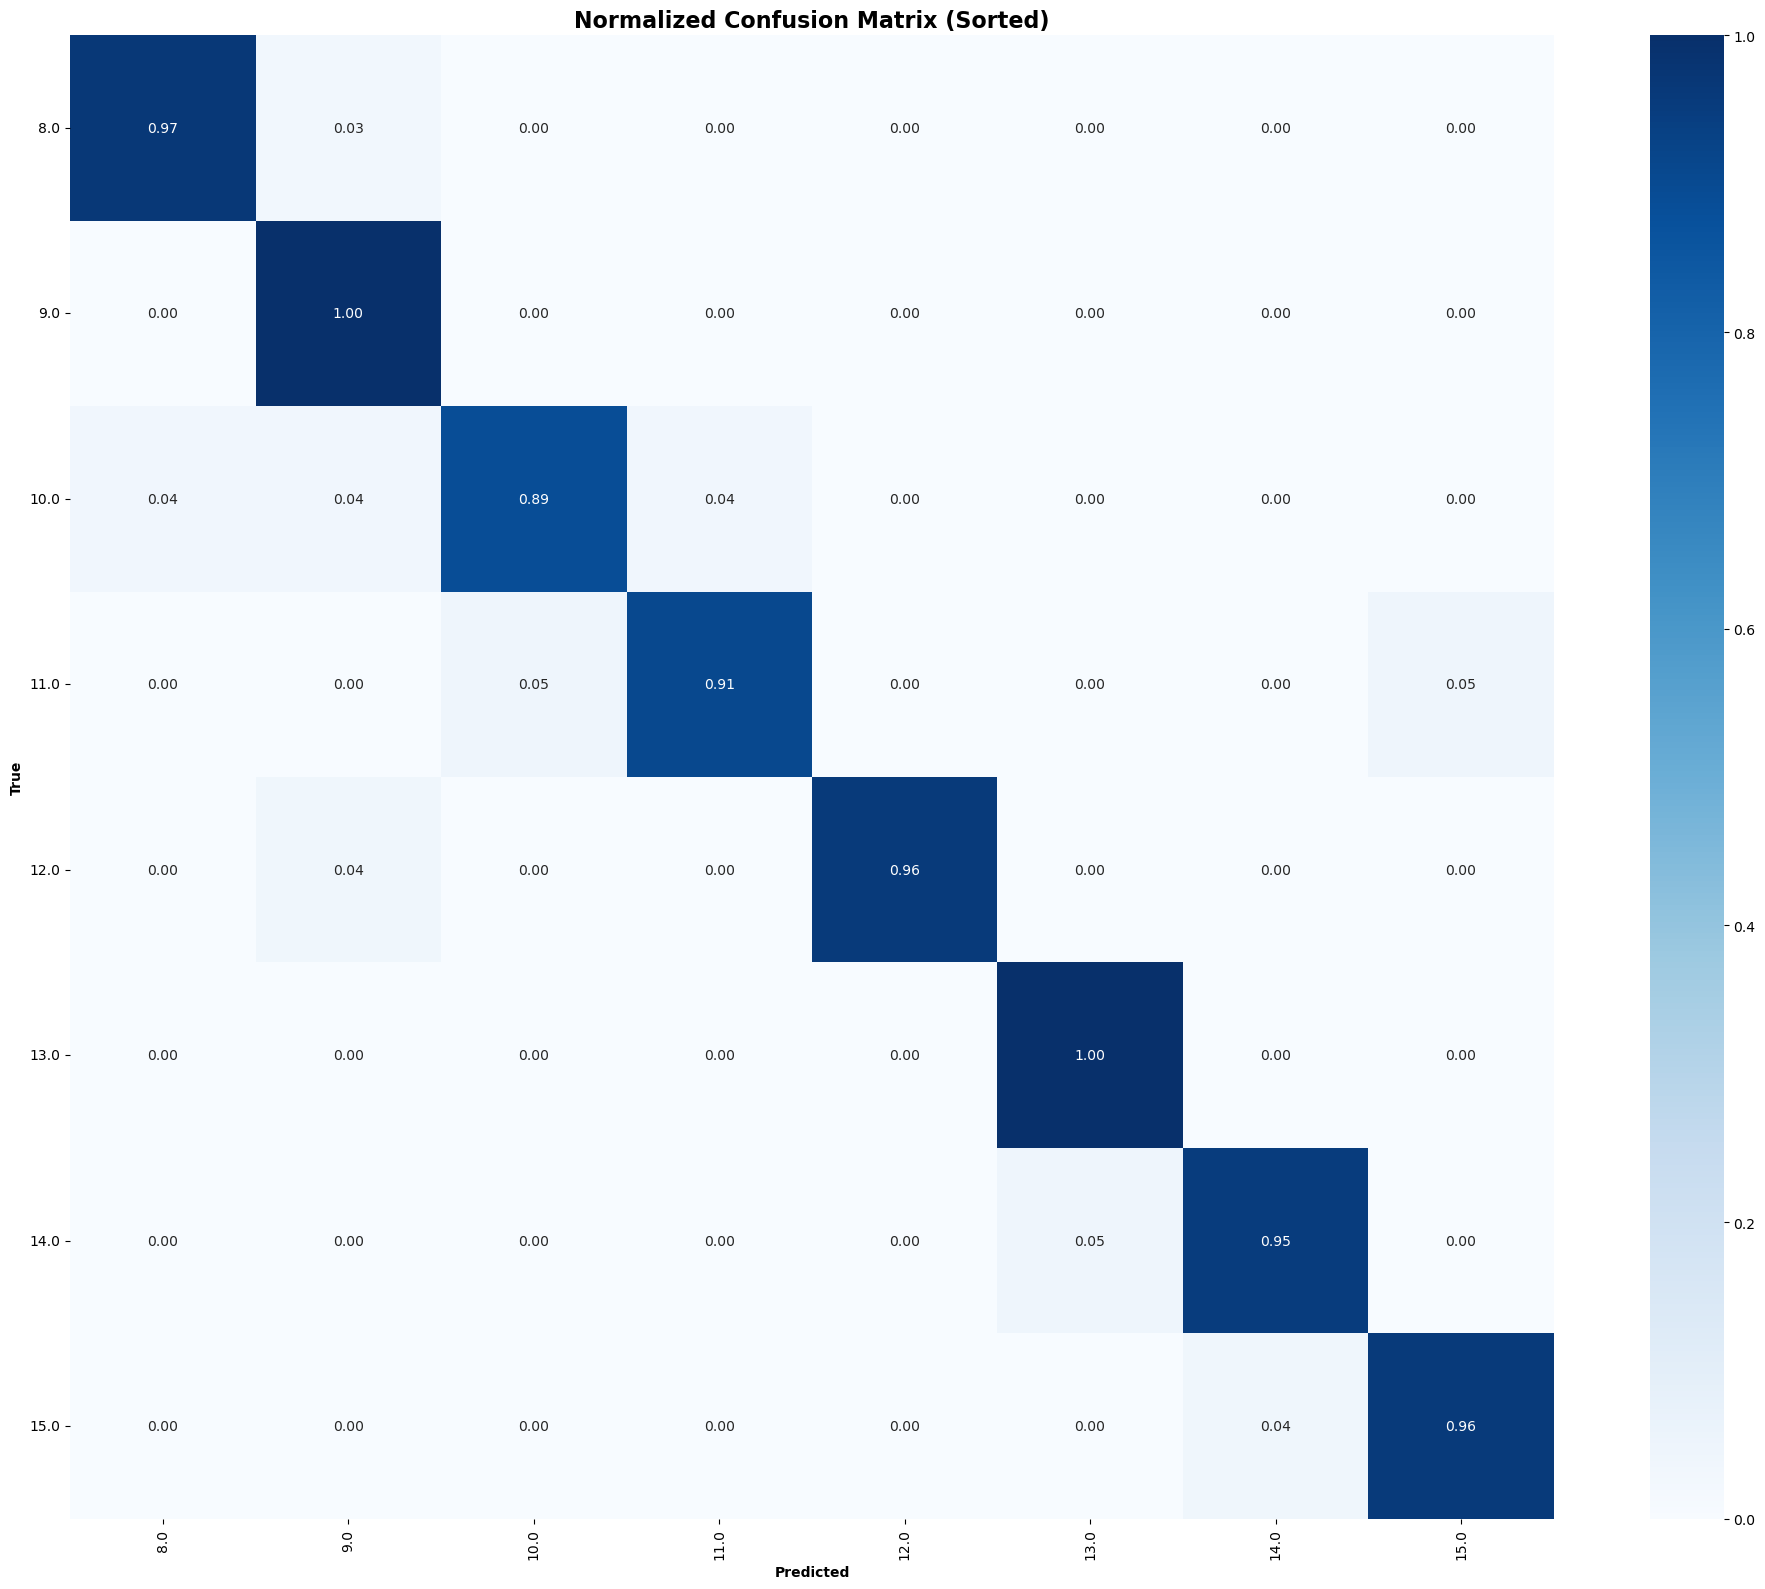

Test set Accuracy: 0.9531
Recall: 0.9531
F1 Score: 0.9531
Confusion Matrix:
[[28  1  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0]
 [ 1  1 24  1  0  0  0  0]
 [ 0  0  1 20  0  0  0  1]
 [ 0  1  0  0 24  0  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  1 19  0]
 [ 0  0  0  0  0  0  1 24]]
Testing on subject 16.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

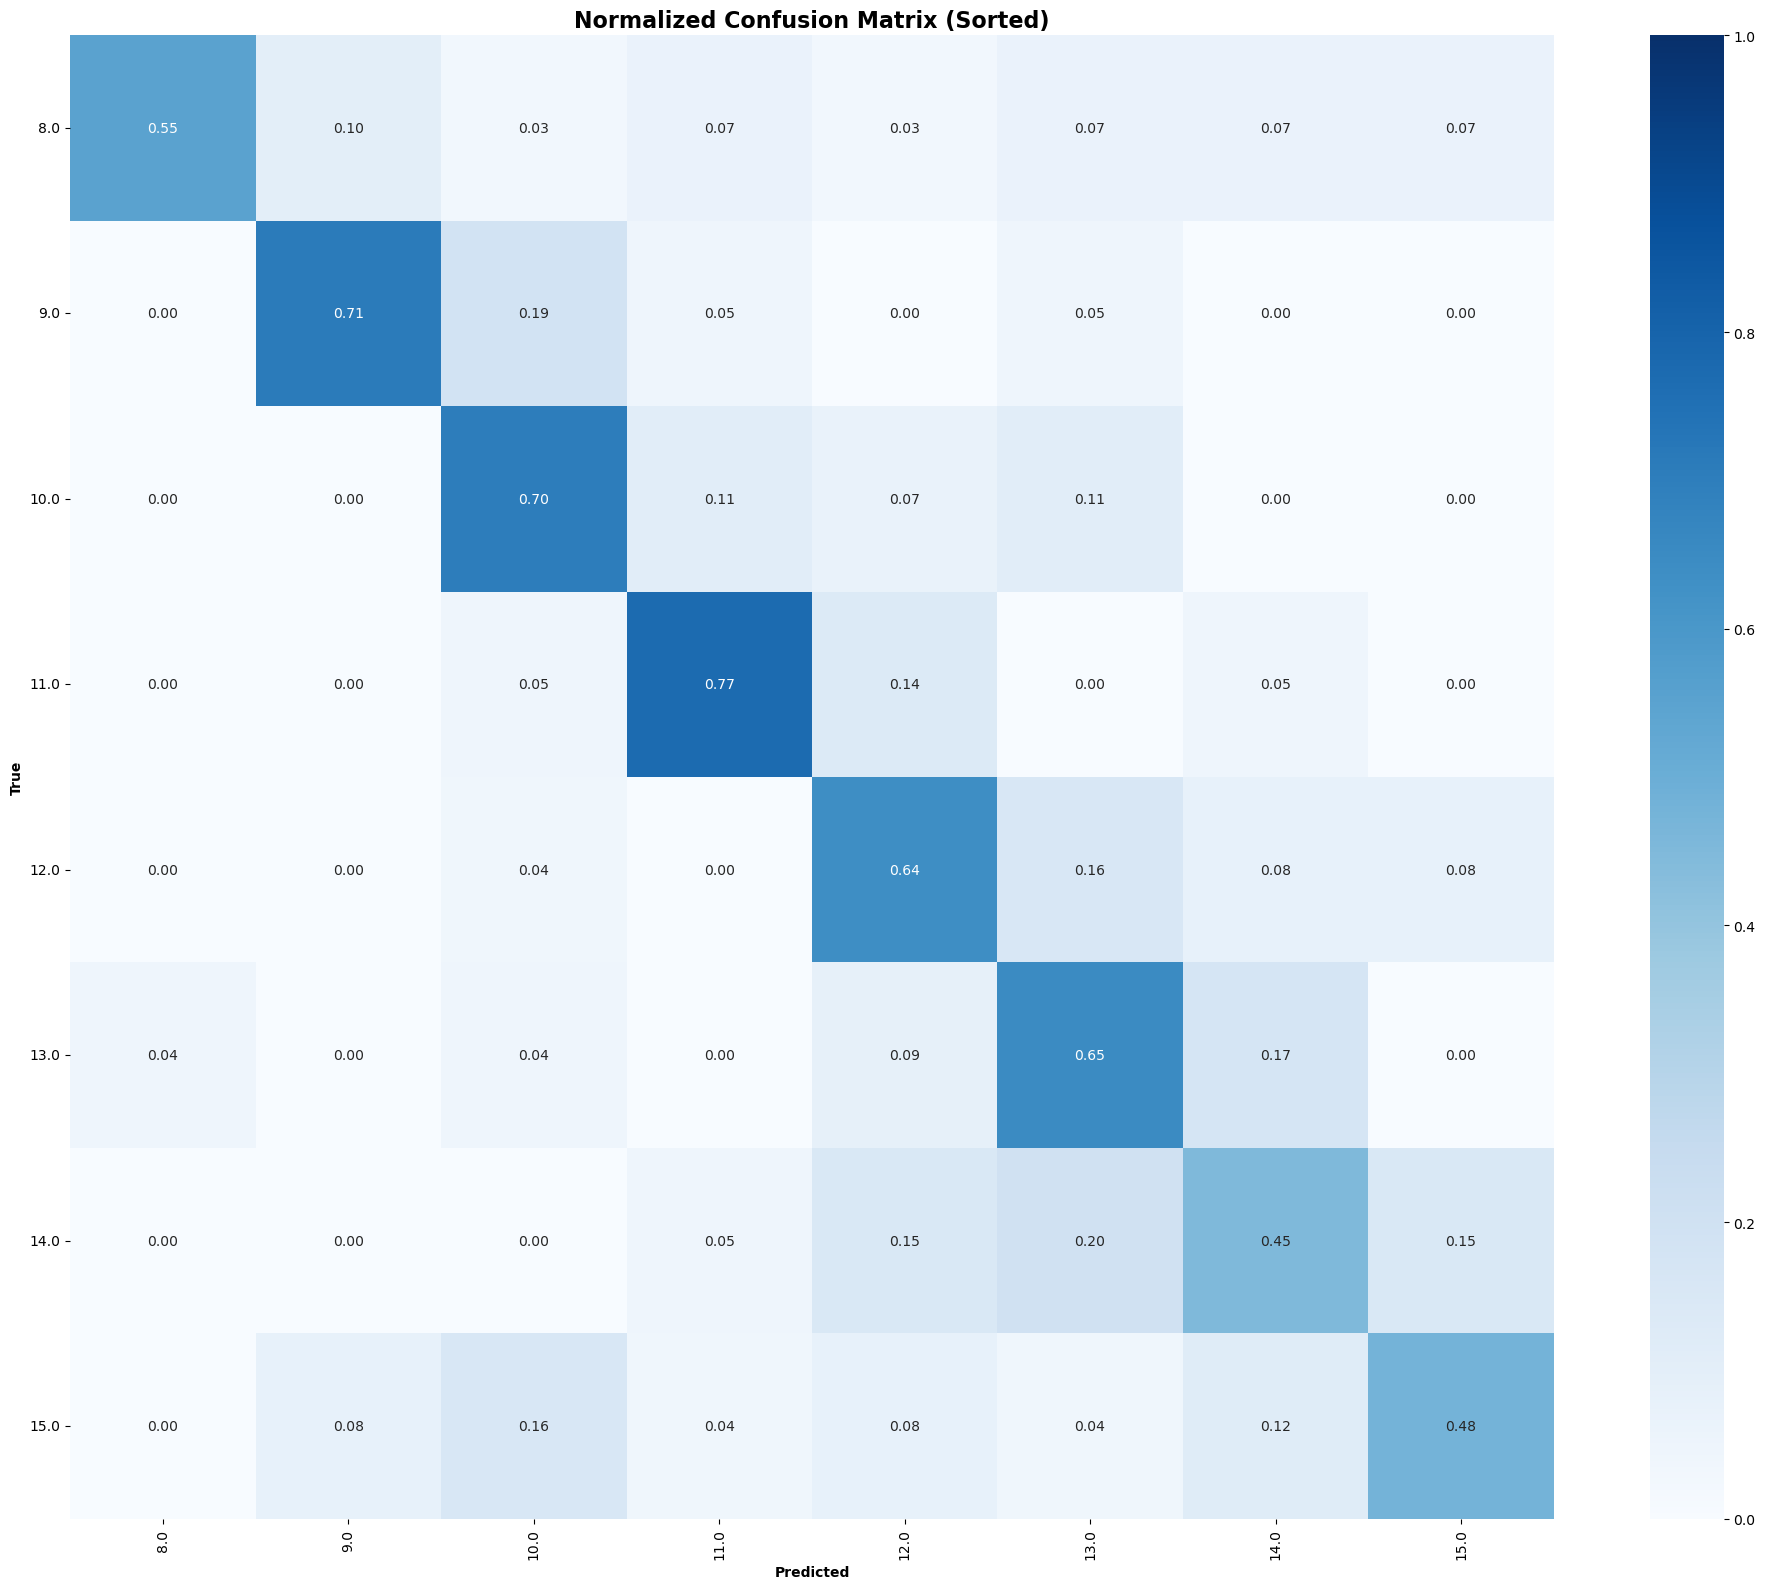

Test set Accuracy: 0.6198
Recall: 0.6198
F1 Score: 0.6218
Confusion Matrix:
[[16  3  1  2  1  2  2  2]
 [ 0 15  4  1  0  1  0  0]
 [ 0  0 19  3  2  3  0  0]
 [ 0  0  1 17  3  0  1  0]
 [ 0  0  1  0 16  4  2  2]
 [ 1  0  1  0  2 15  4  0]
 [ 0  0  0  1  3  4  9  3]
 [ 0  2  4  1  2  1  3 12]]
Testing on subject 17.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

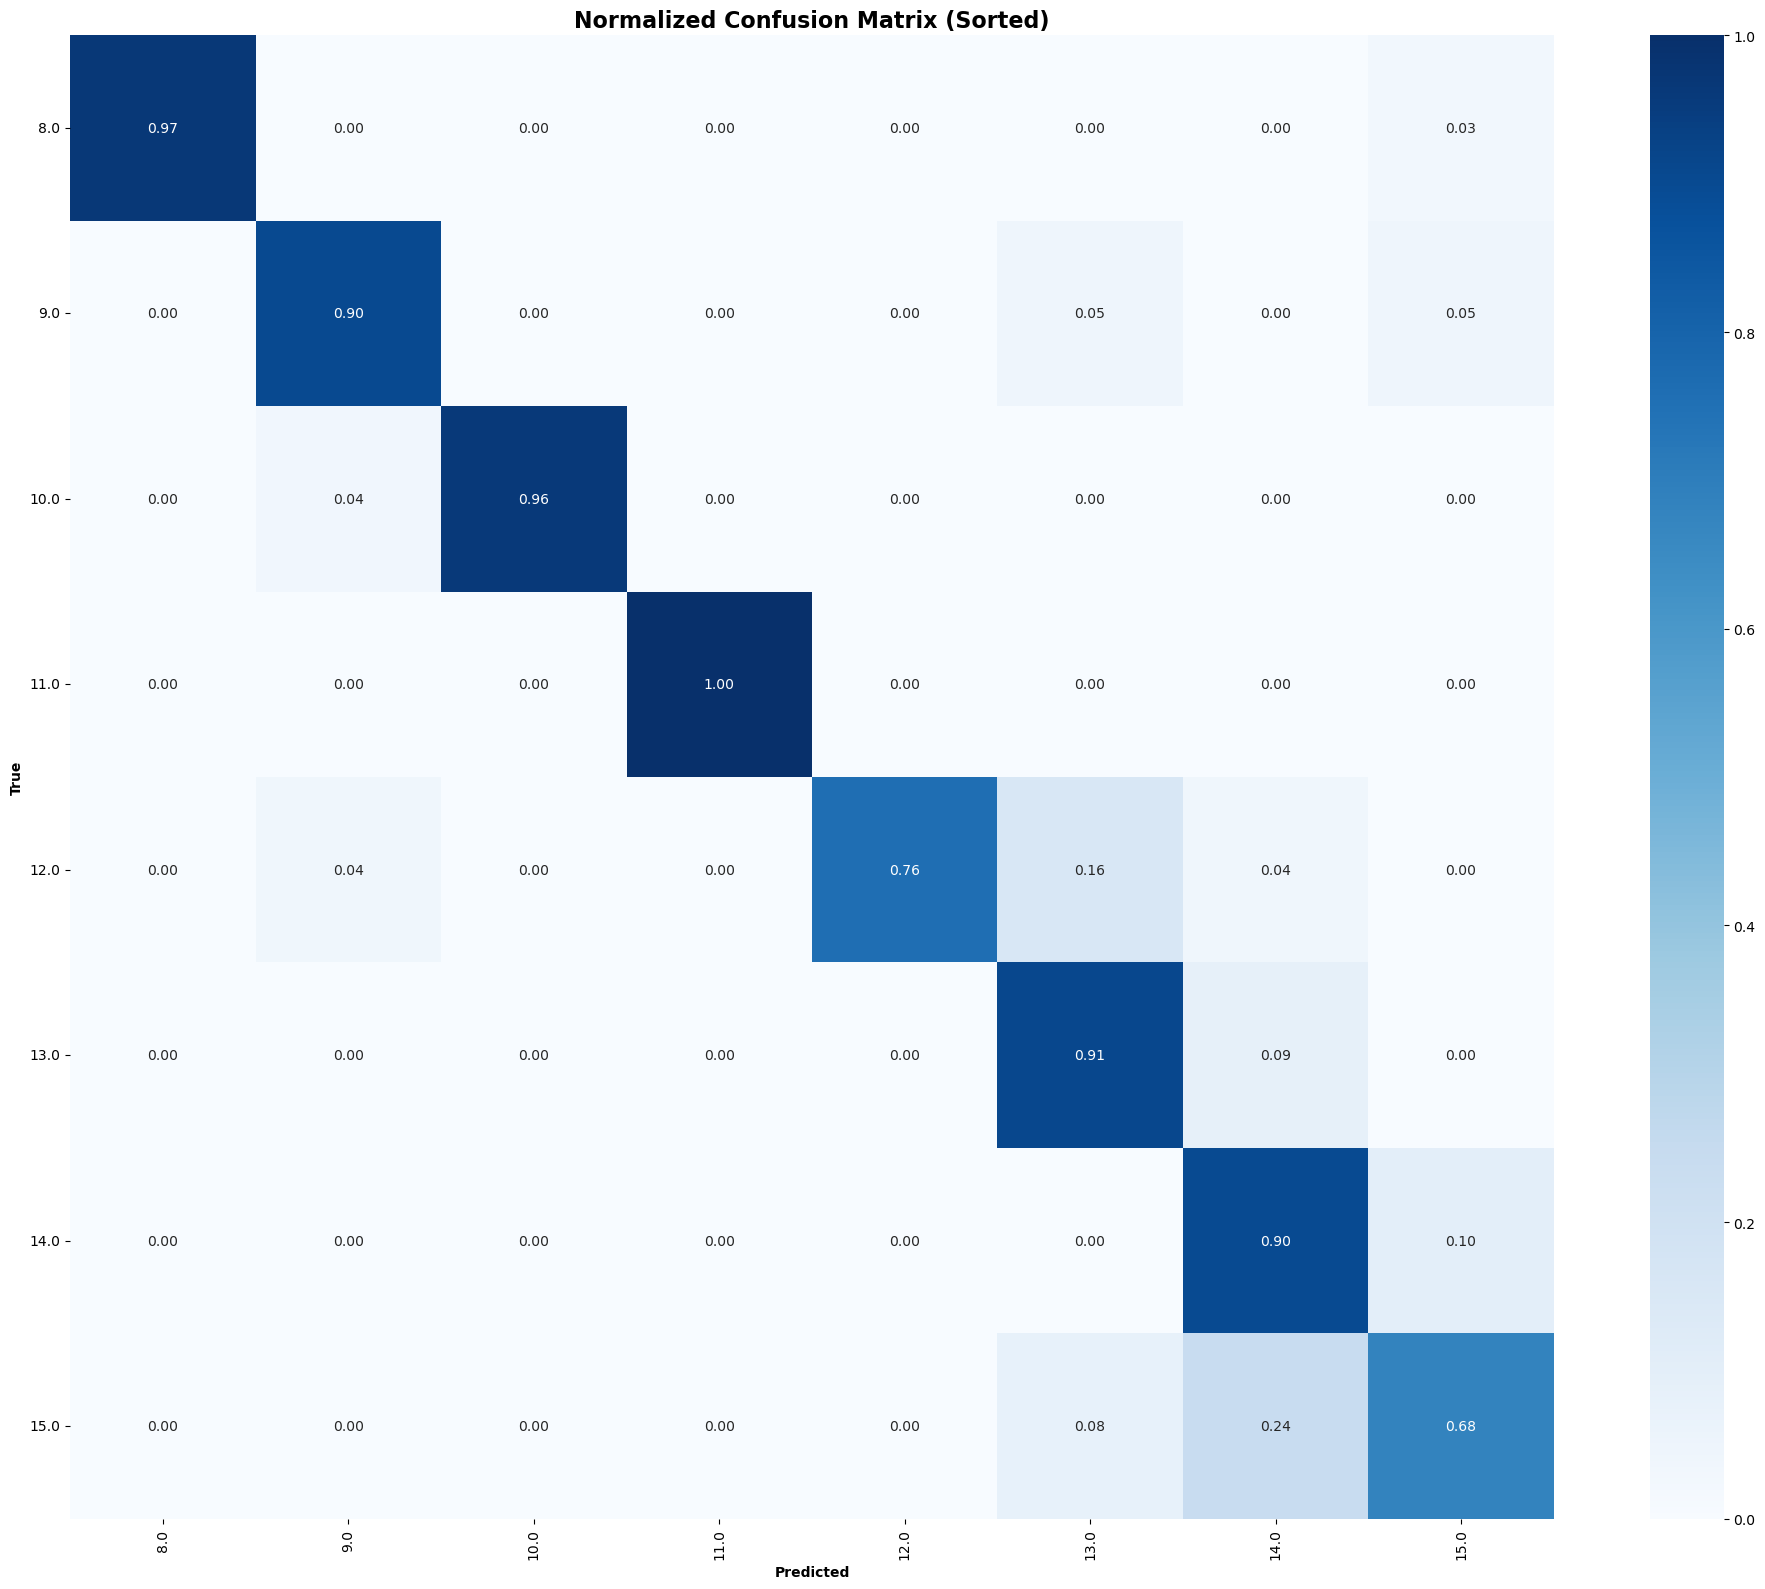

Test set Accuracy: 0.8854
Recall: 0.8854
F1 Score: 0.8870
Confusion Matrix:
[[28  0  0  0  0  0  0  1]
 [ 0 19  0  0  0  1  0  1]
 [ 0  1 26  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  1  0  0 19  4  1  0]
 [ 0  0  0  0  0 21  2  0]
 [ 0  0  0  0  0  0 18  2]
 [ 0  0  0  0  0  2  6 17]]
Testing on subject 18.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

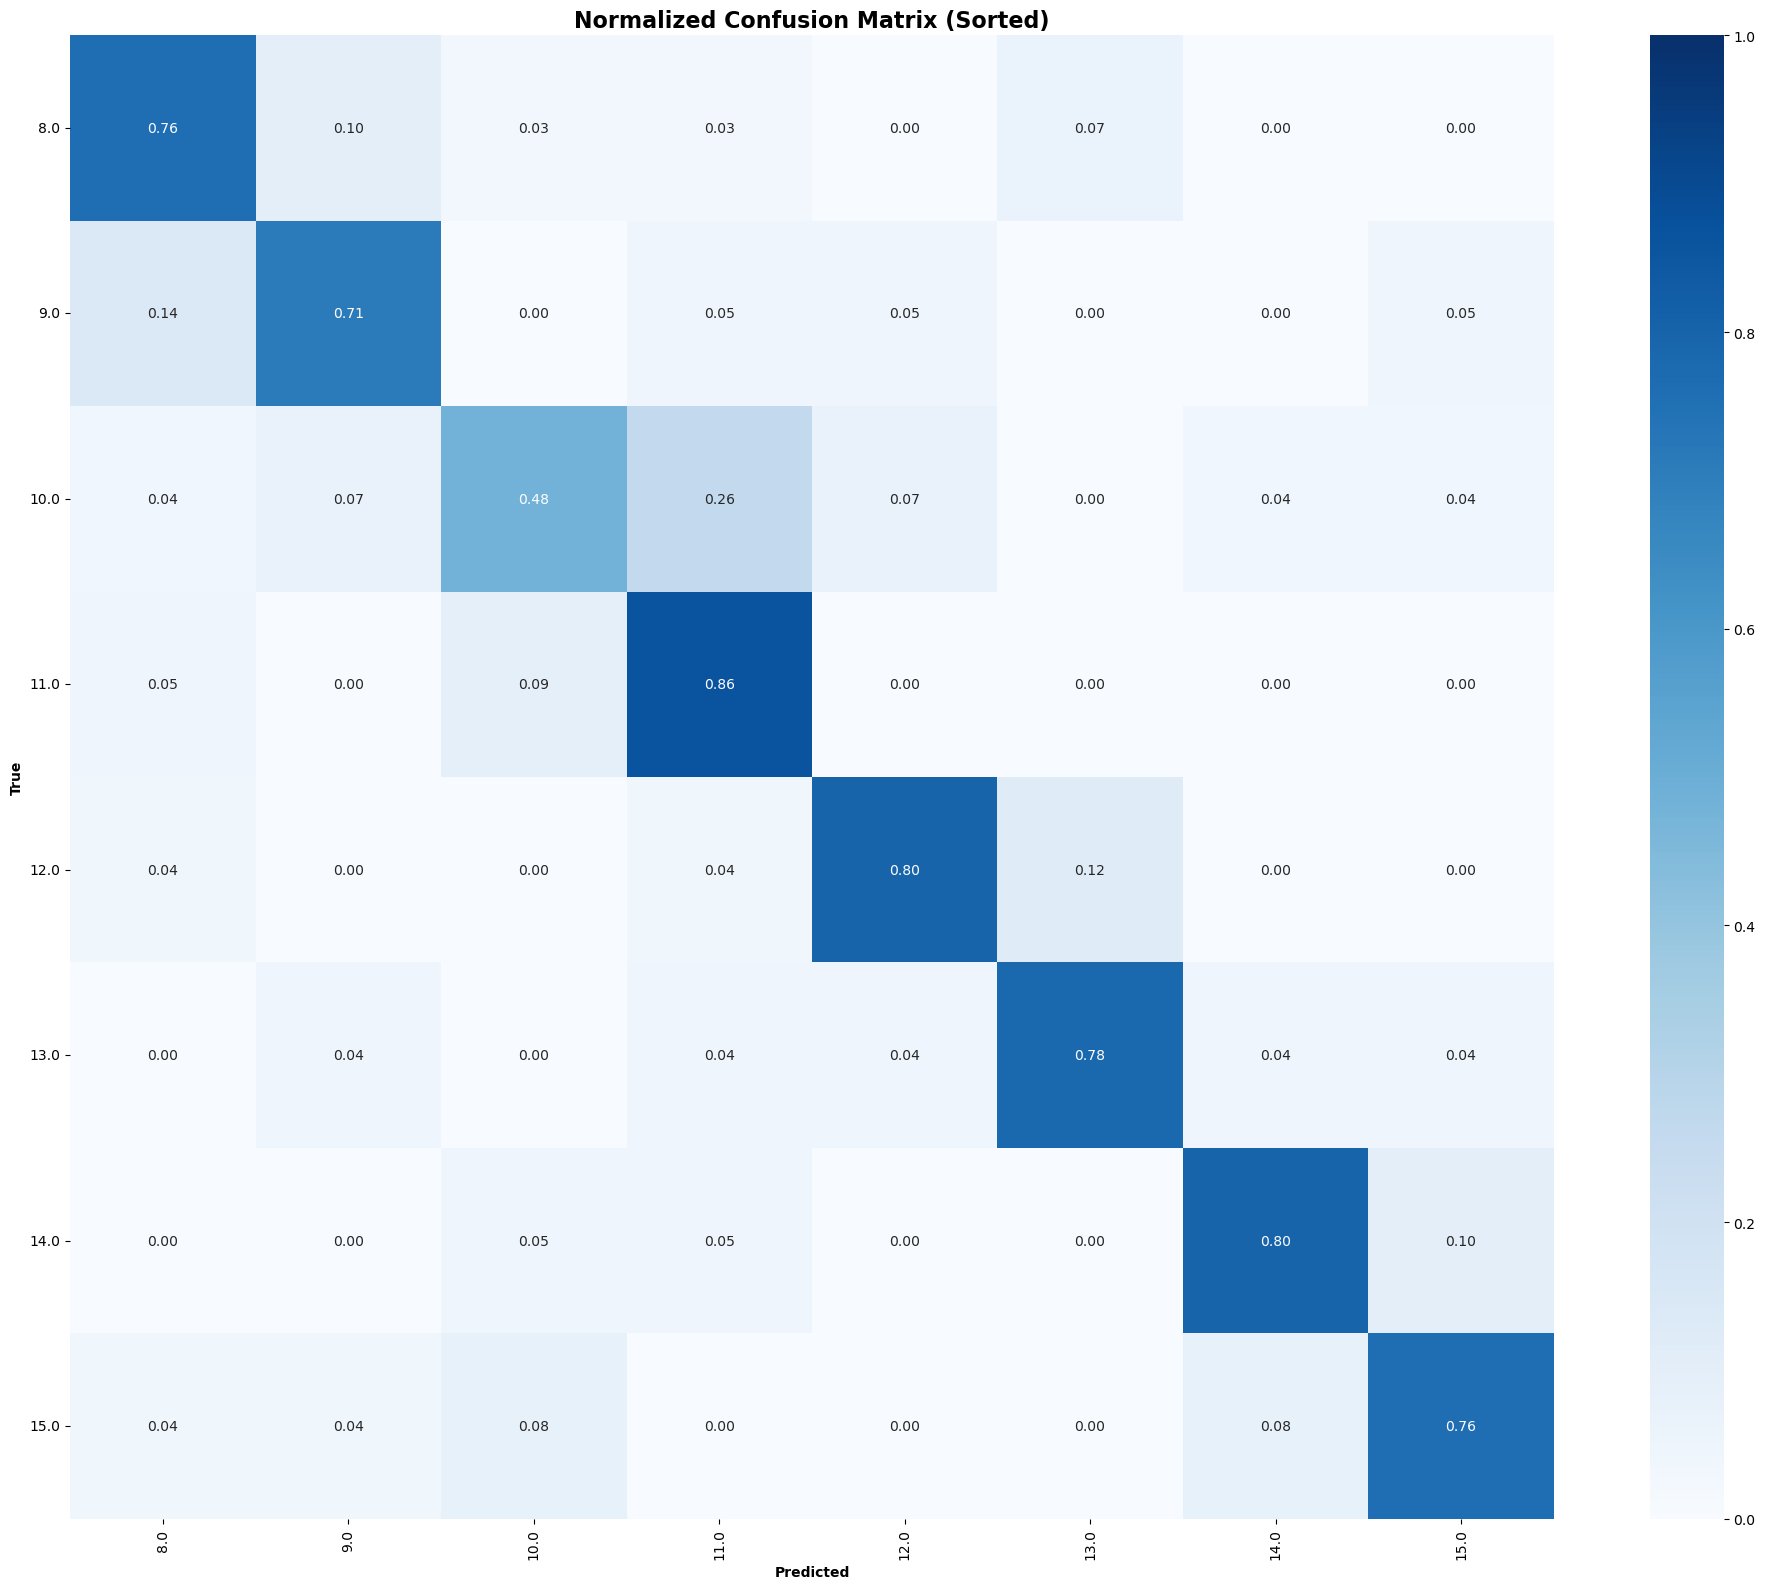

Test set Accuracy: 0.7396
Recall: 0.7396
F1 Score: 0.7369
Confusion Matrix:
[[22  3  1  1  0  2  0  0]
 [ 3 15  0  1  1  0  0  1]
 [ 1  2 13  7  2  0  1  1]
 [ 1  0  2 19  0  0  0  0]
 [ 1  0  0  1 20  3  0  0]
 [ 0  1  0  1  1 18  1  1]
 [ 0  0  1  1  0  0 16  2]
 [ 1  1  2  0  0  0  2 19]]
Testing on subject 19.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

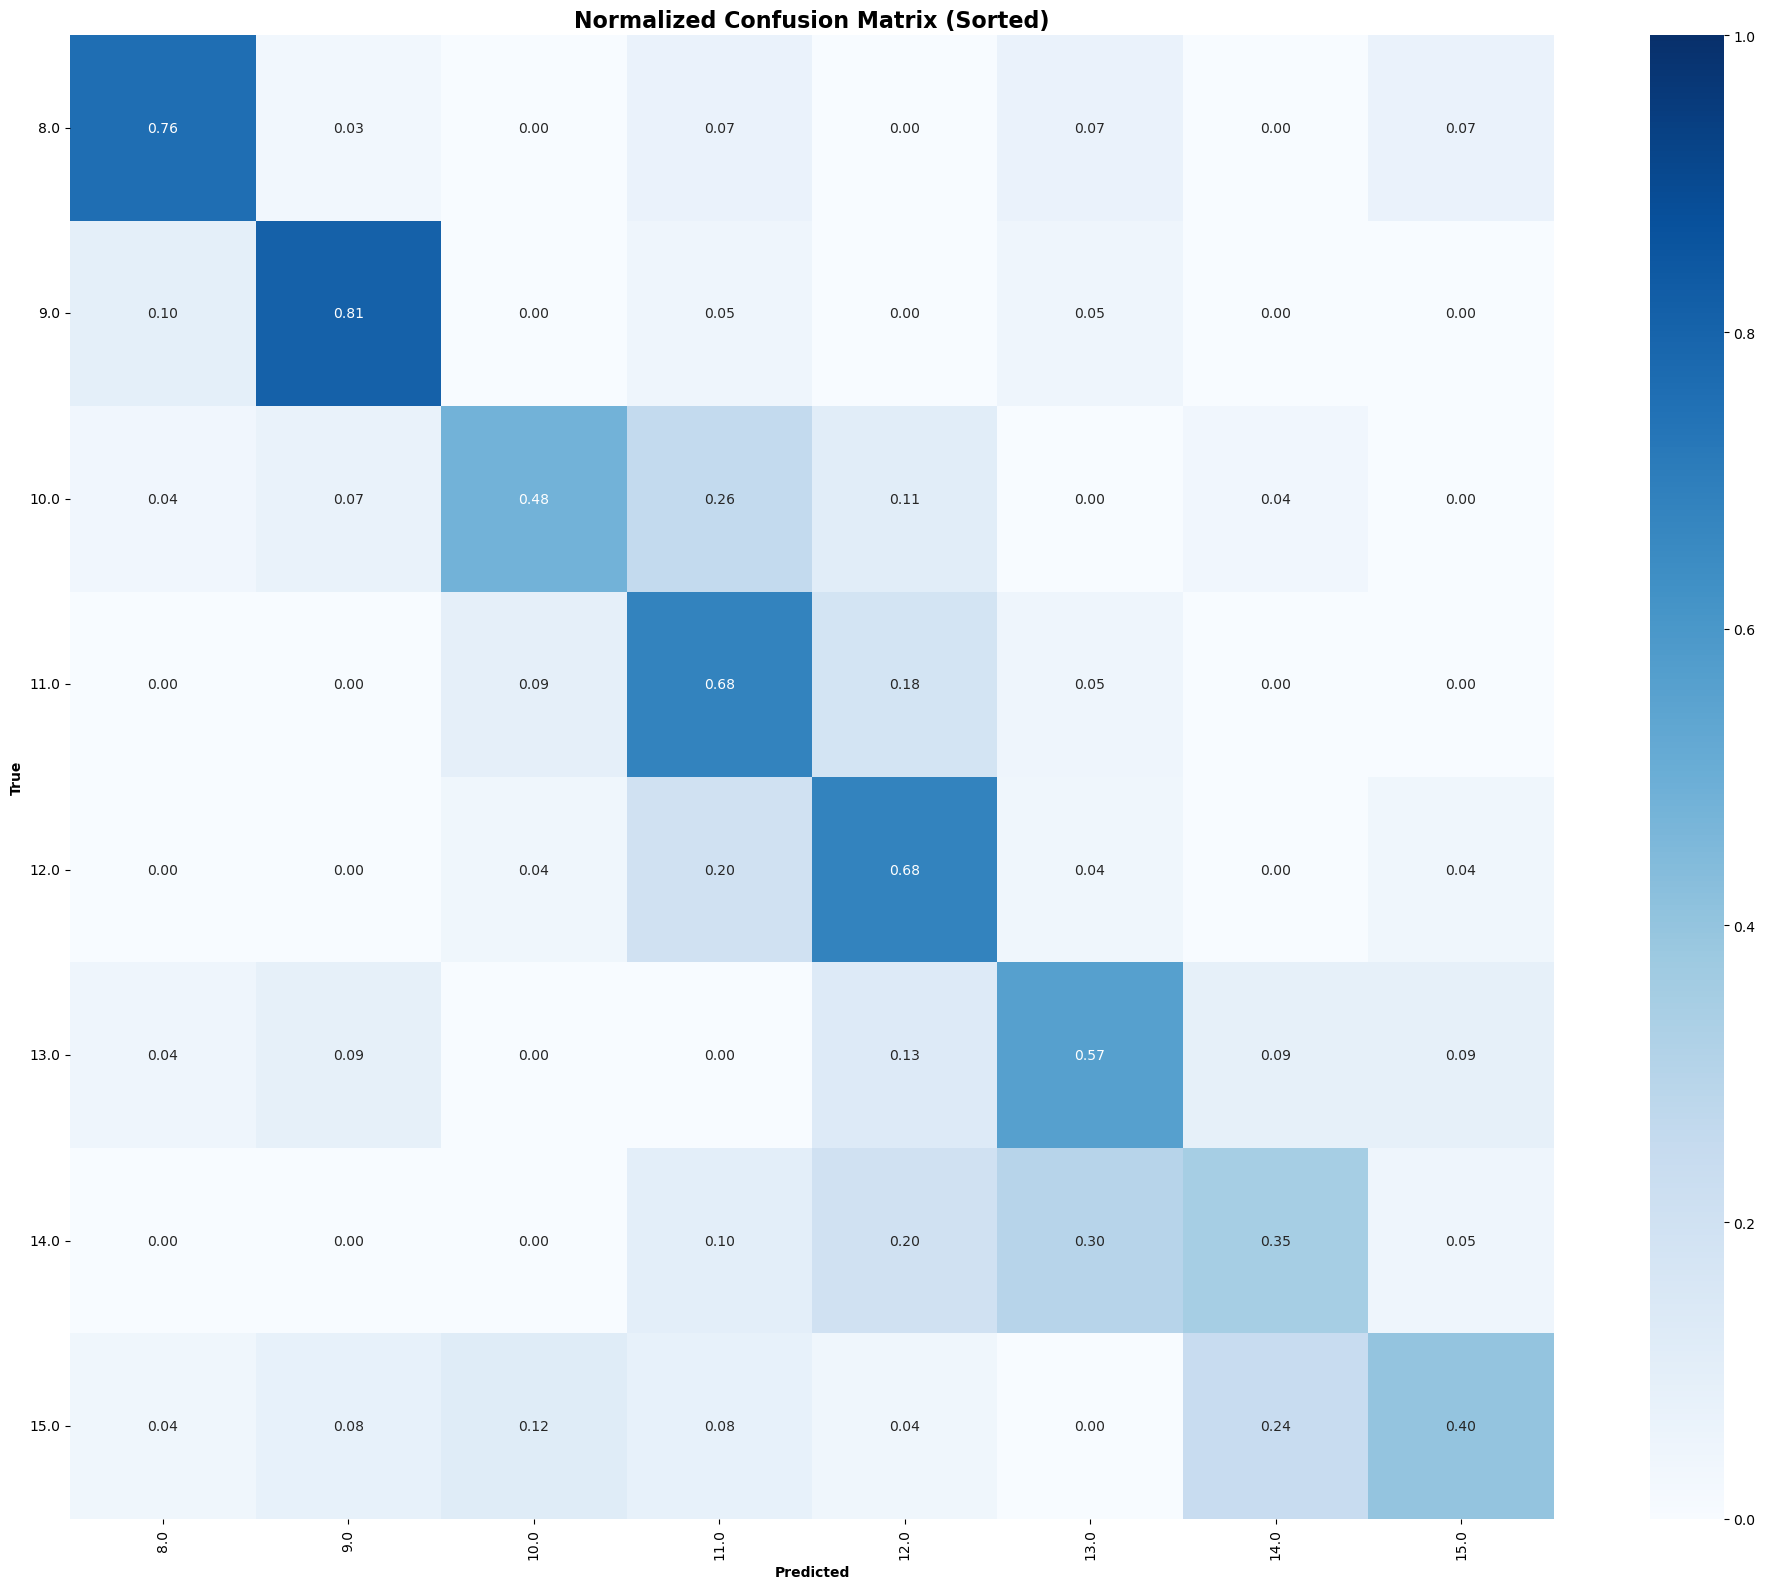

Test set Accuracy: 0.5938
Recall: 0.5938
F1 Score: 0.5901
Confusion Matrix:
[[22  1  0  2  0  2  0  2]
 [ 2 17  0  1  0  1  0  0]
 [ 1  2 13  7  3  0  1  0]
 [ 0  0  2 15  4  1  0  0]
 [ 0  0  1  5 17  1  0  1]
 [ 1  2  0  0  3 13  2  2]
 [ 0  0  0  2  4  6  7  1]
 [ 1  2  3  2  1  0  6 10]]
Testing on subject 20.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

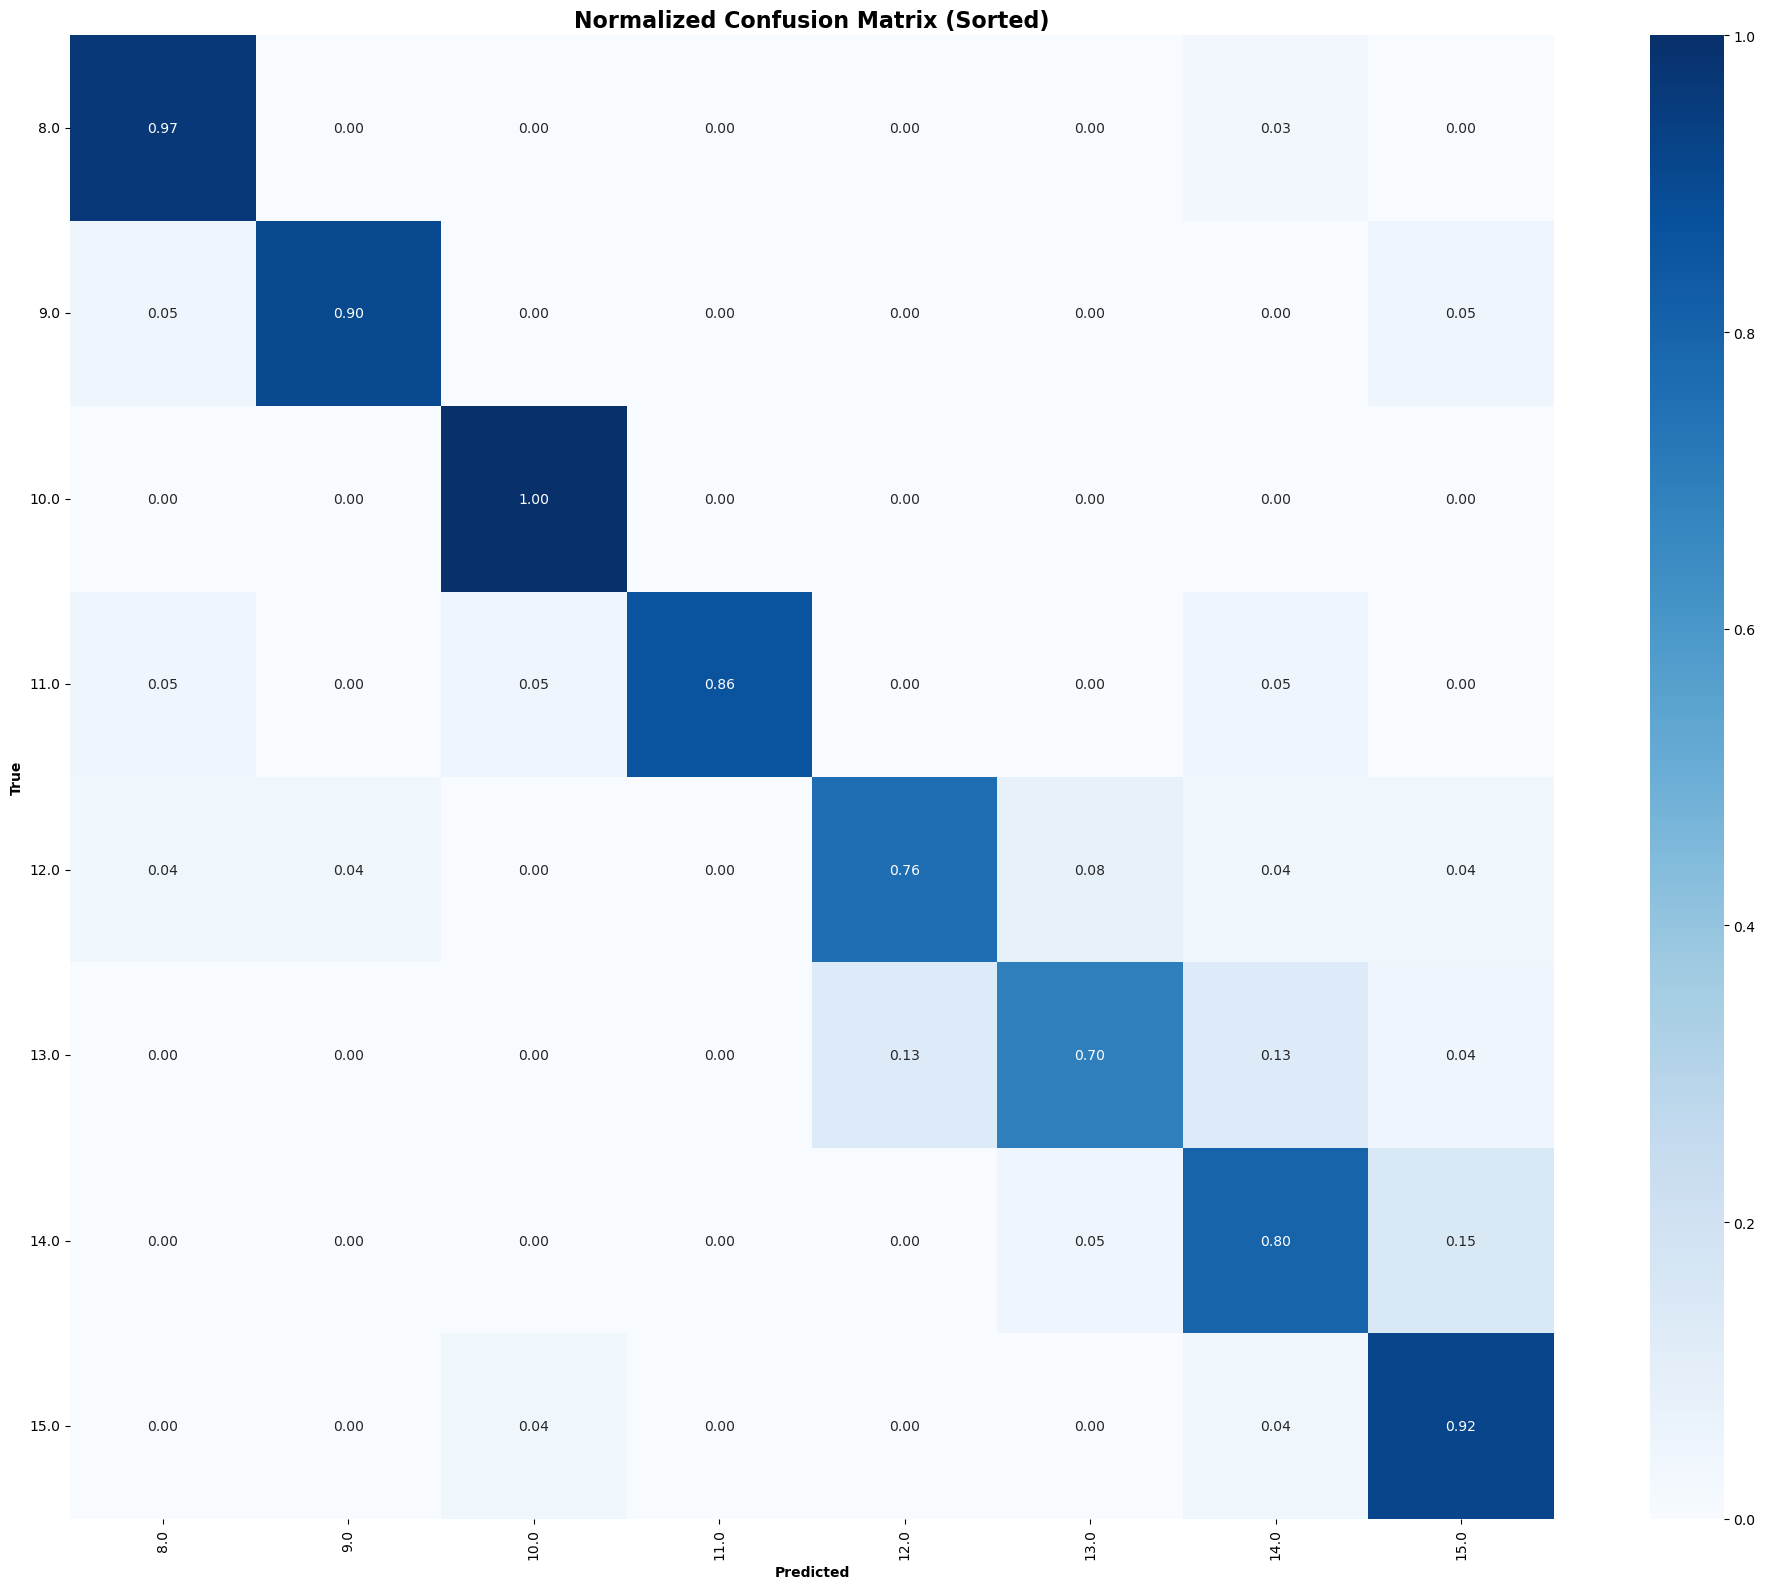

Test set Accuracy: 0.8698
Recall: 0.8698
F1 Score: 0.8691
Confusion Matrix:
[[28  0  0  0  0  0  1  0]
 [ 1 19  0  0  0  0  0  1]
 [ 0  0 27  0  0  0  0  0]
 [ 1  0  1 19  0  0  1  0]
 [ 1  1  0  0 19  2  1  1]
 [ 0  0  0  0  3 16  3  1]
 [ 0  0  0  0  0  1 16  3]
 [ 0  0  1  0  0  0  1 23]]
Testing on subject 21.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

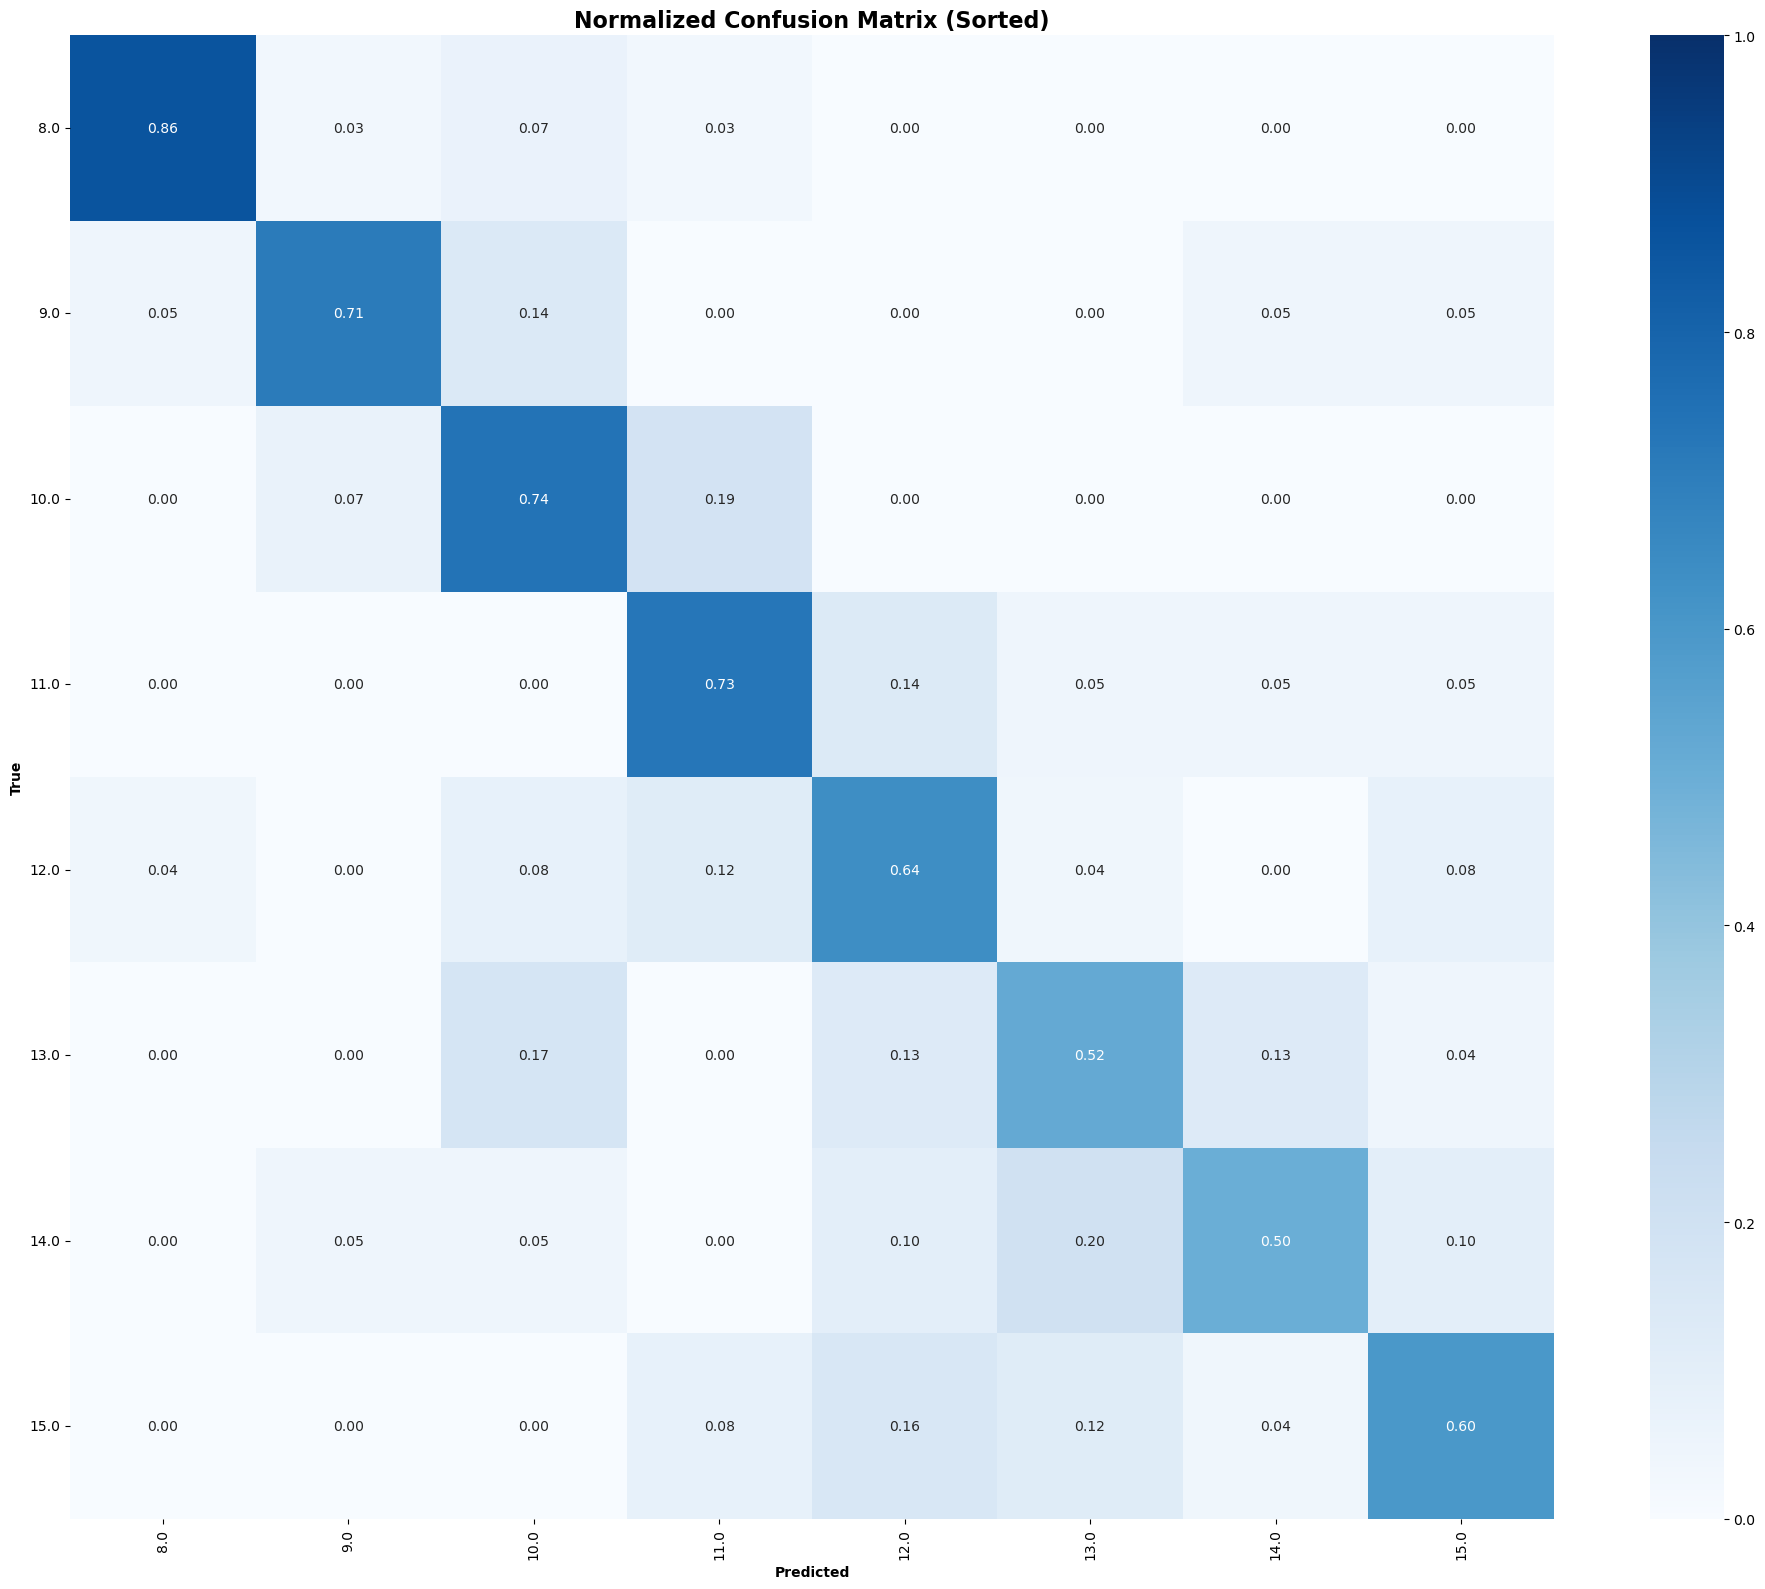

Test set Accuracy: 0.6719
Recall: 0.6719
F1 Score: 0.6720
Confusion Matrix:
[[25  1  2  1  0  0  0  0]
 [ 1 15  3  0  0  0  1  1]
 [ 0  2 20  5  0  0  0  0]
 [ 0  0  0 16  3  1  1  1]
 [ 1  0  2  3 16  1  0  2]
 [ 0  0  4  0  3 12  3  1]
 [ 0  1  1  0  2  4 10  2]
 [ 0  0  0  2  4  3  1 15]]
Testing on subject 22.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

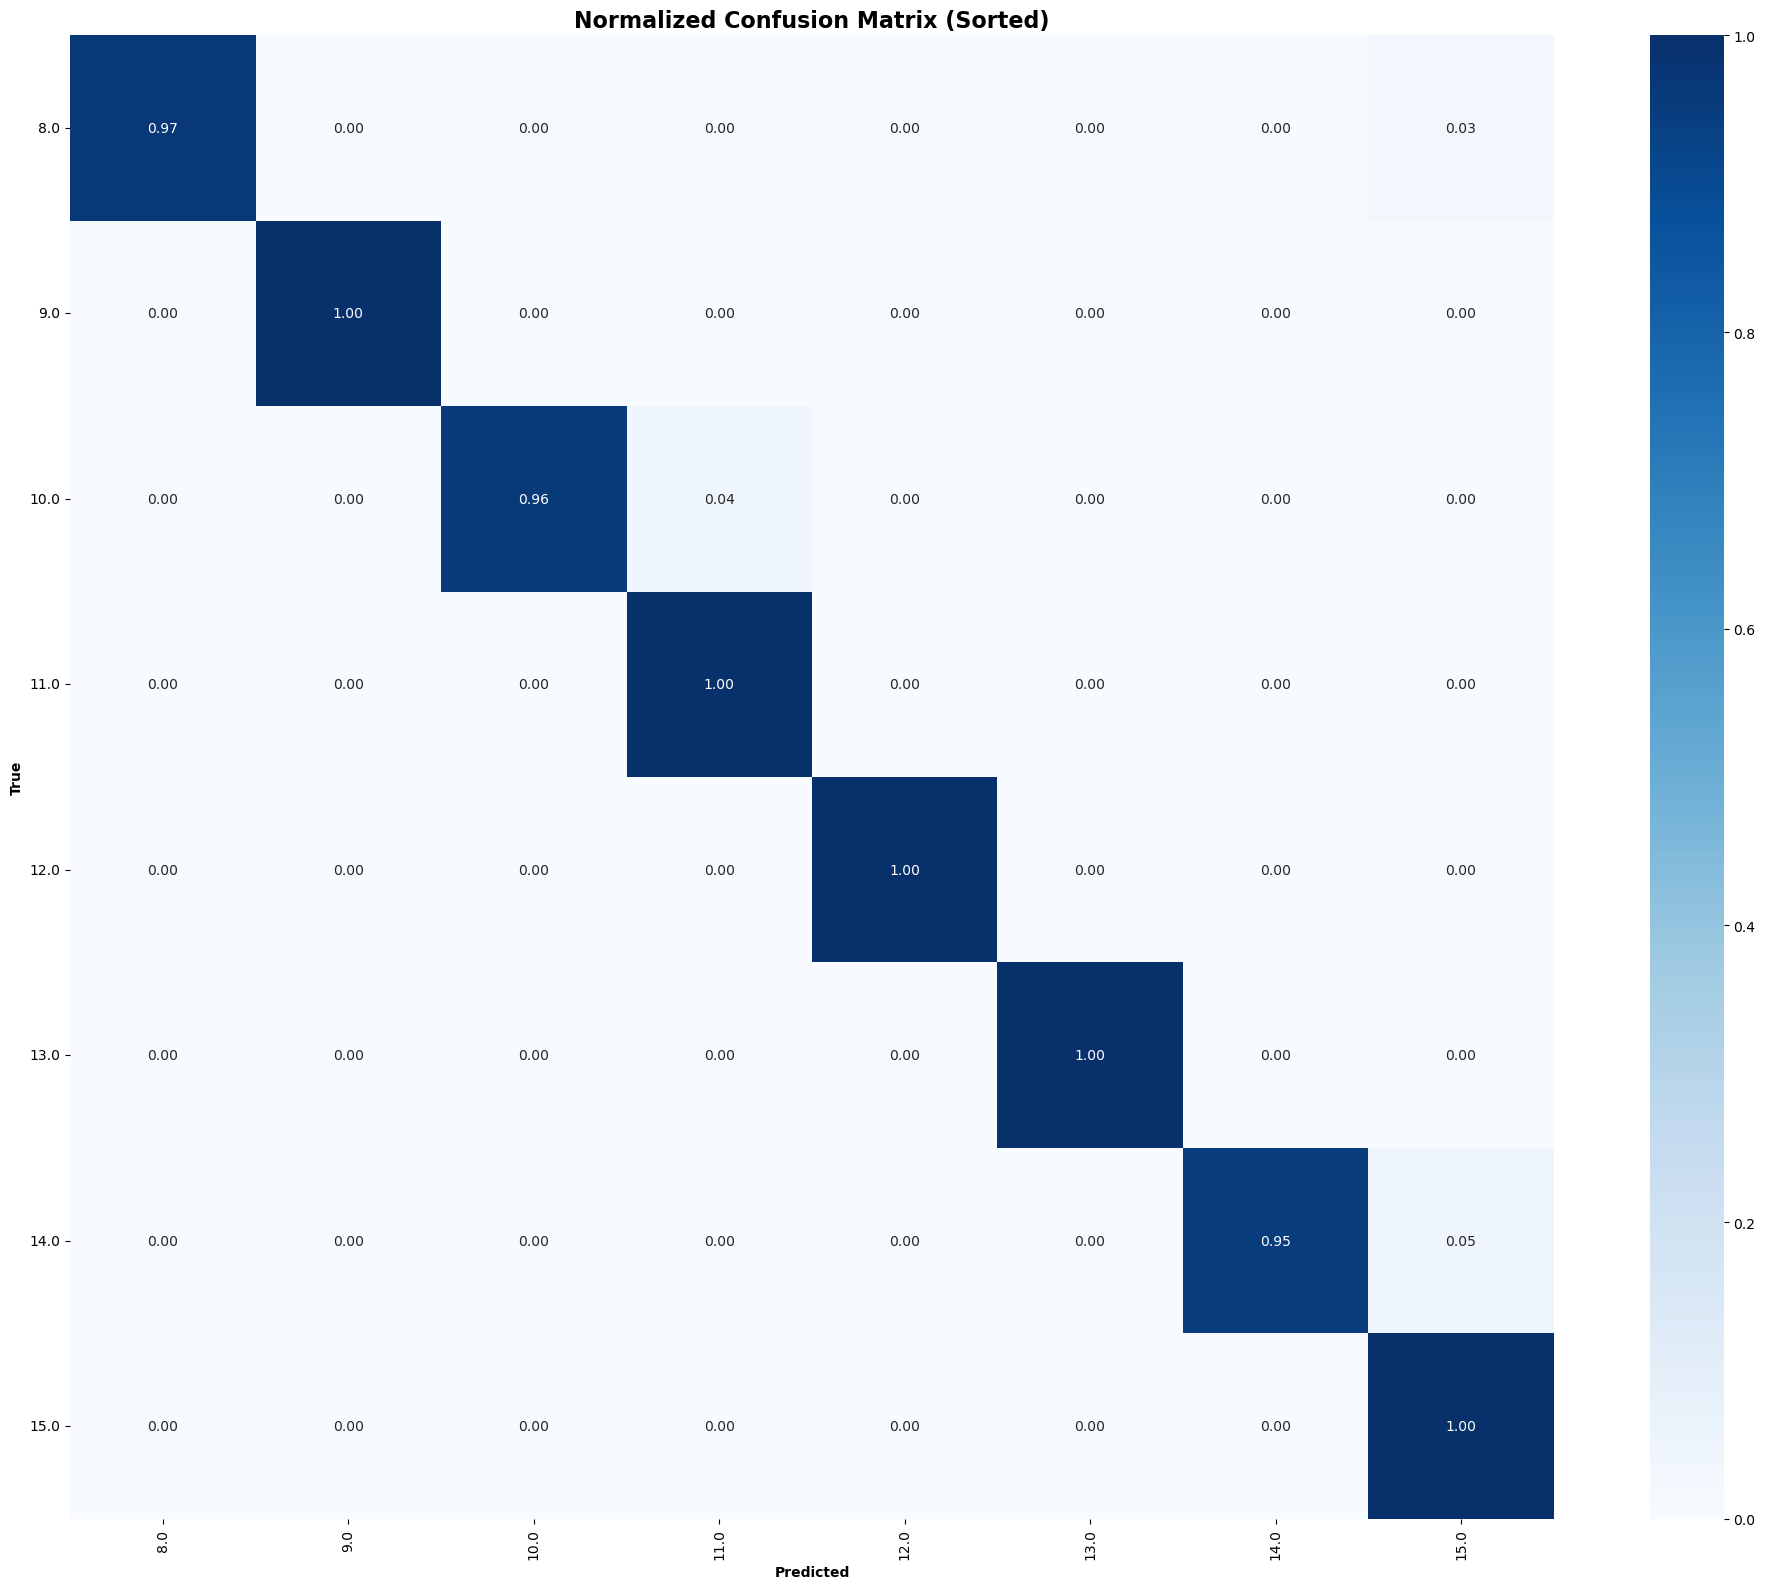

Test set Accuracy: 0.9844
Recall: 0.9844
F1 Score: 0.9845
Confusion Matrix:
[[28  0  0  0  0  0  0  1]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 26  1  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 19  1]
 [ 0  0  0  0  0  0  0 25]]
Testing on subject 23.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

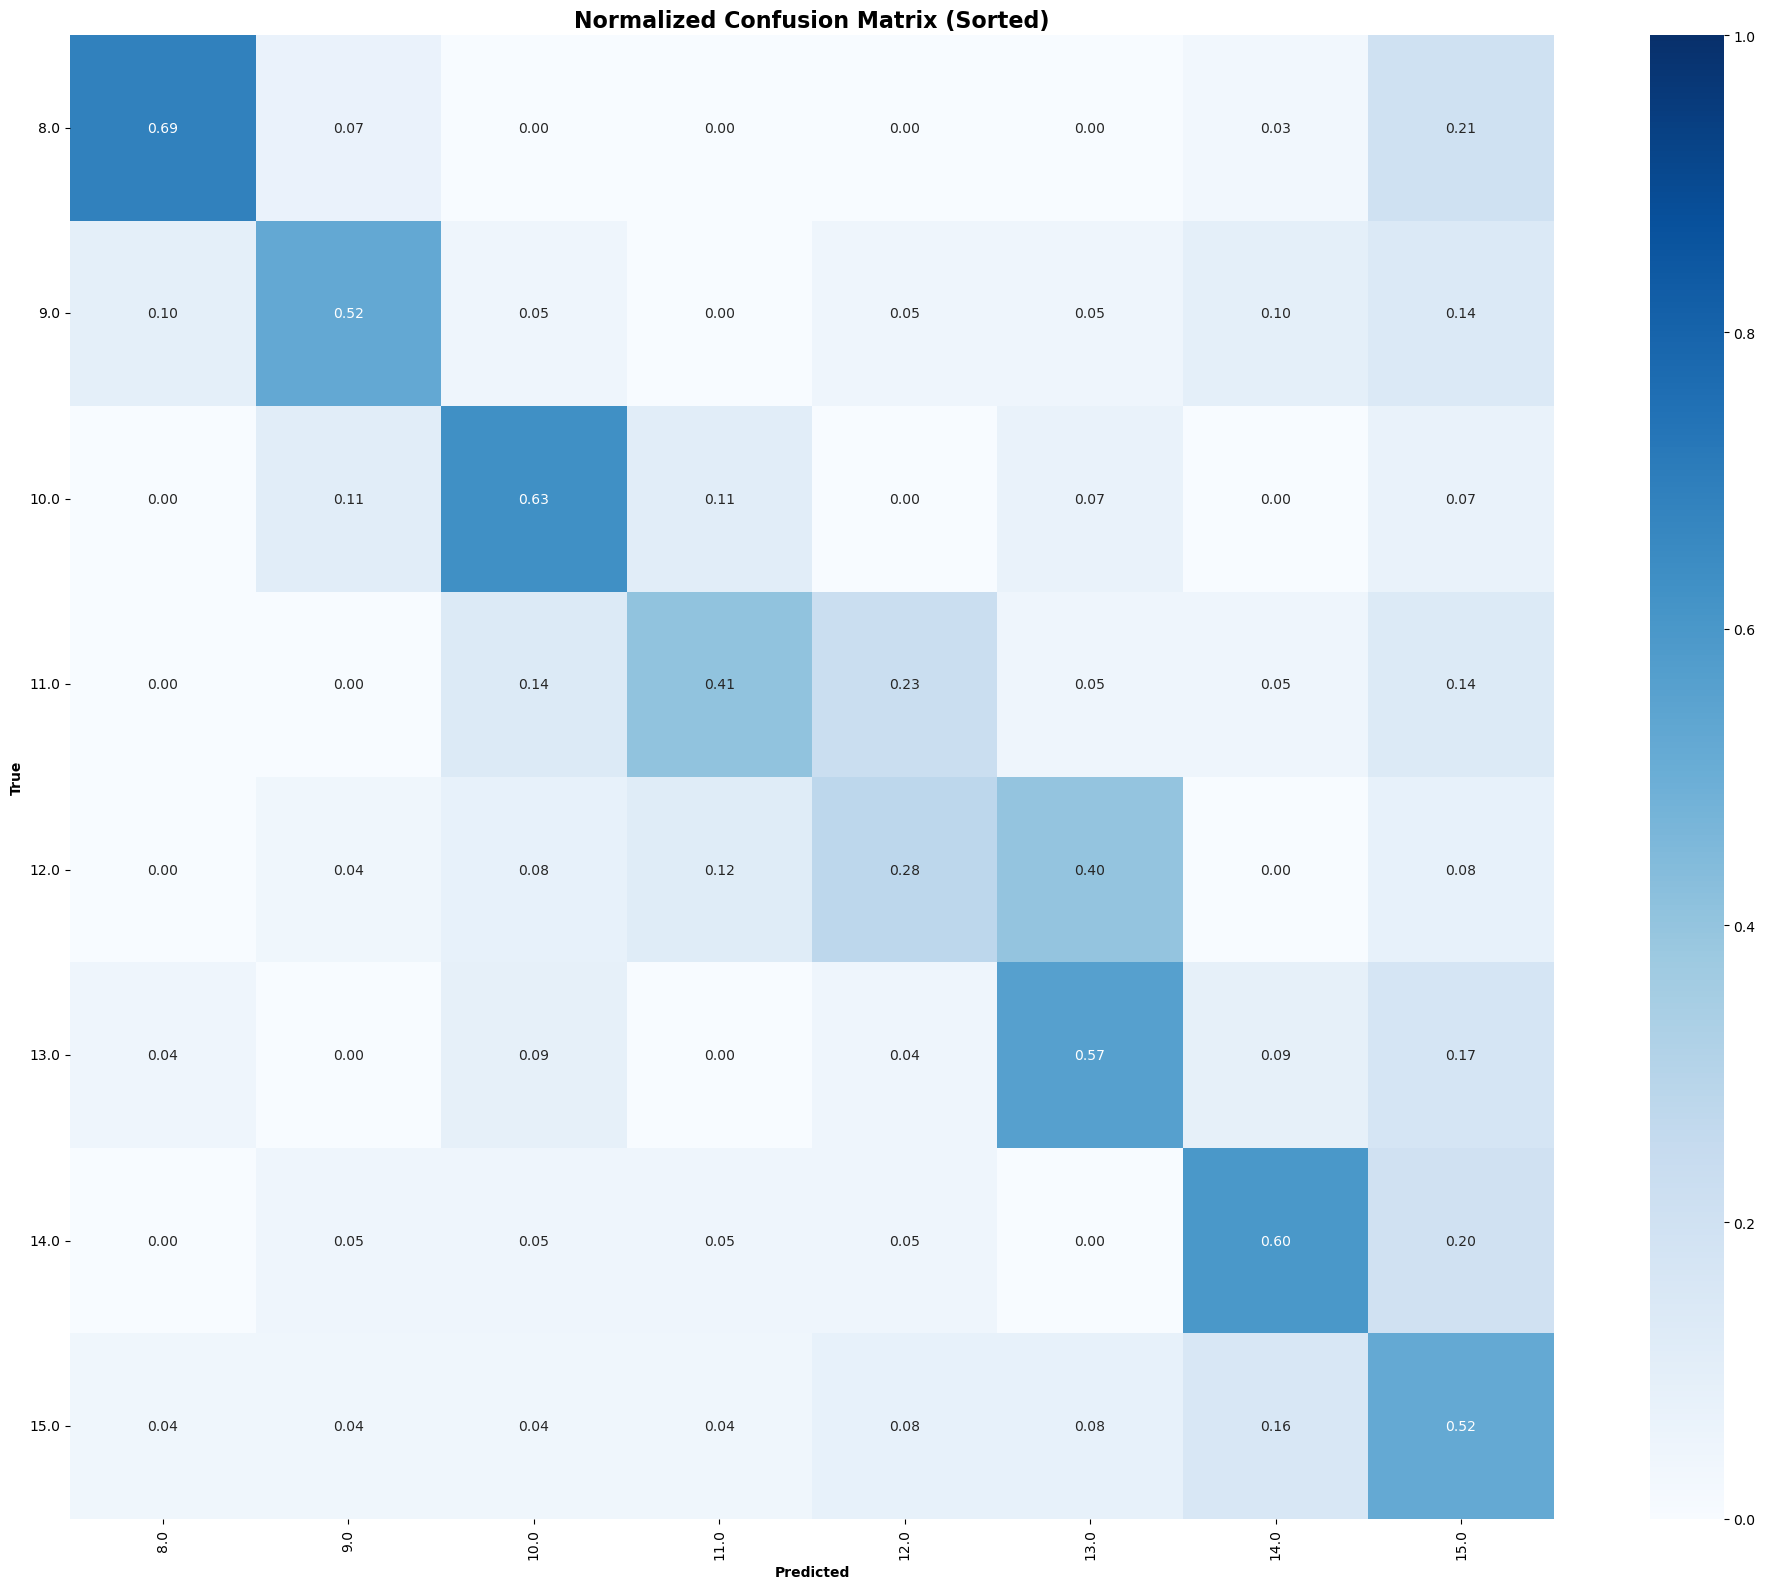

Test set Accuracy: 0.5312
Recall: 0.5312
F1 Score: 0.5330
Confusion Matrix:
[[20  2  0  0  0  0  1  6]
 [ 2 11  1  0  1  1  2  3]
 [ 0  3 17  3  0  2  0  2]
 [ 0  0  3  9  5  1  1  3]
 [ 0  1  2  3  7 10  0  2]
 [ 1  0  2  0  1 13  2  4]
 [ 0  1  1  1  1  0 12  4]
 [ 1  1  1  1  2  2  4 13]]
Testing on subject 24.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

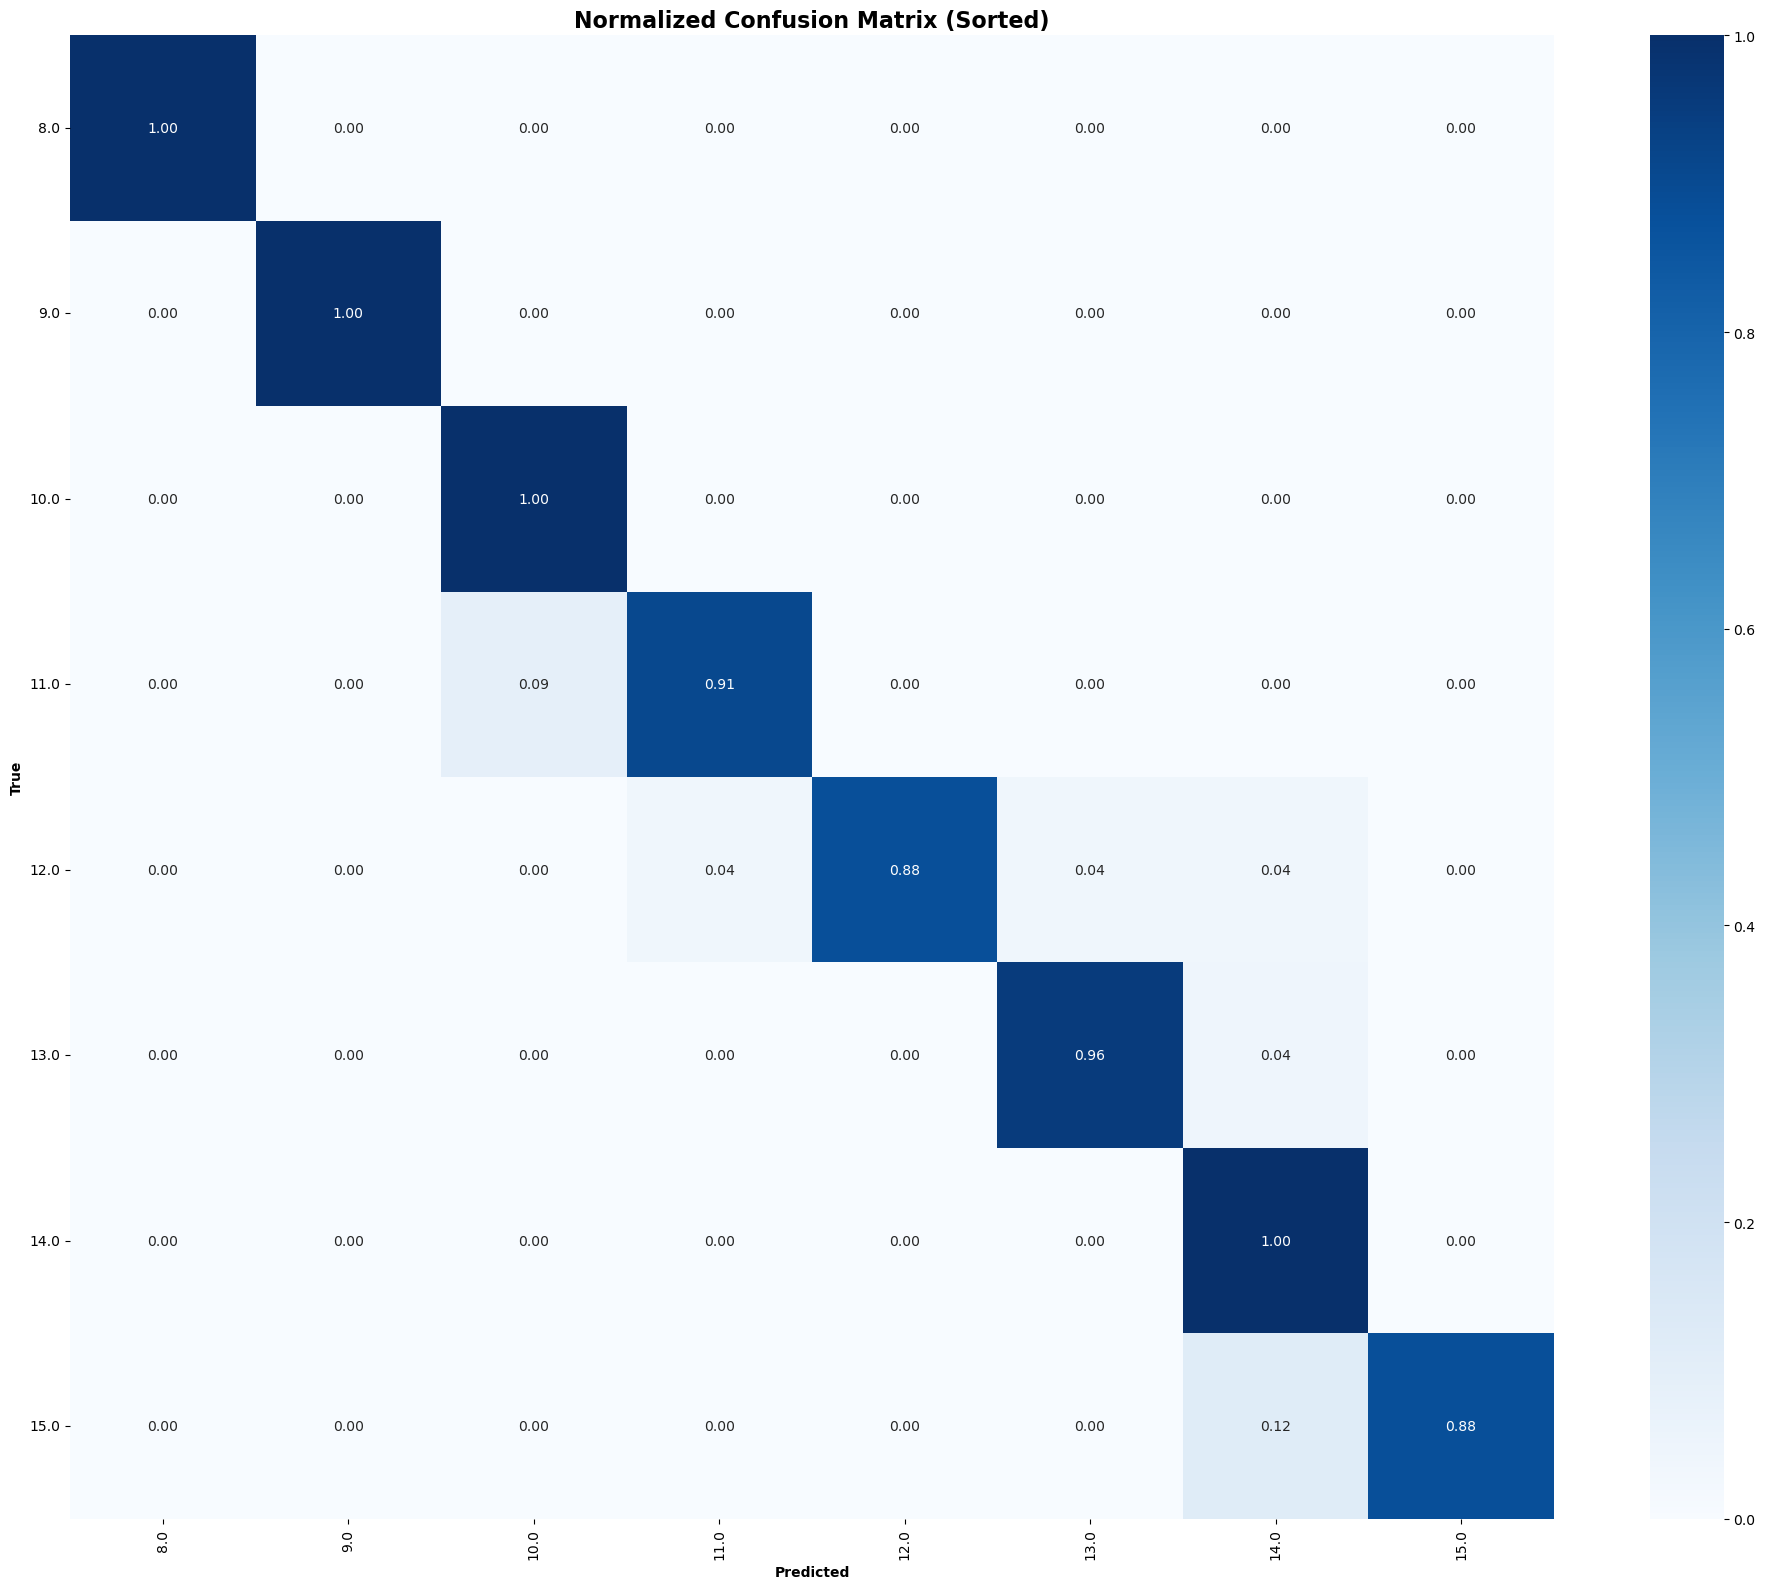

Test set Accuracy: 0.9531
Recall: 0.9531
F1 Score: 0.9536
Confusion Matrix:
[[29  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0]
 [ 0  0  2 20  0  0  0  0]
 [ 0  0  0  1 22  1  1  0]
 [ 0  0  0  0  0 22  1  0]
 [ 0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  3 22]]
Testing on subject 25.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

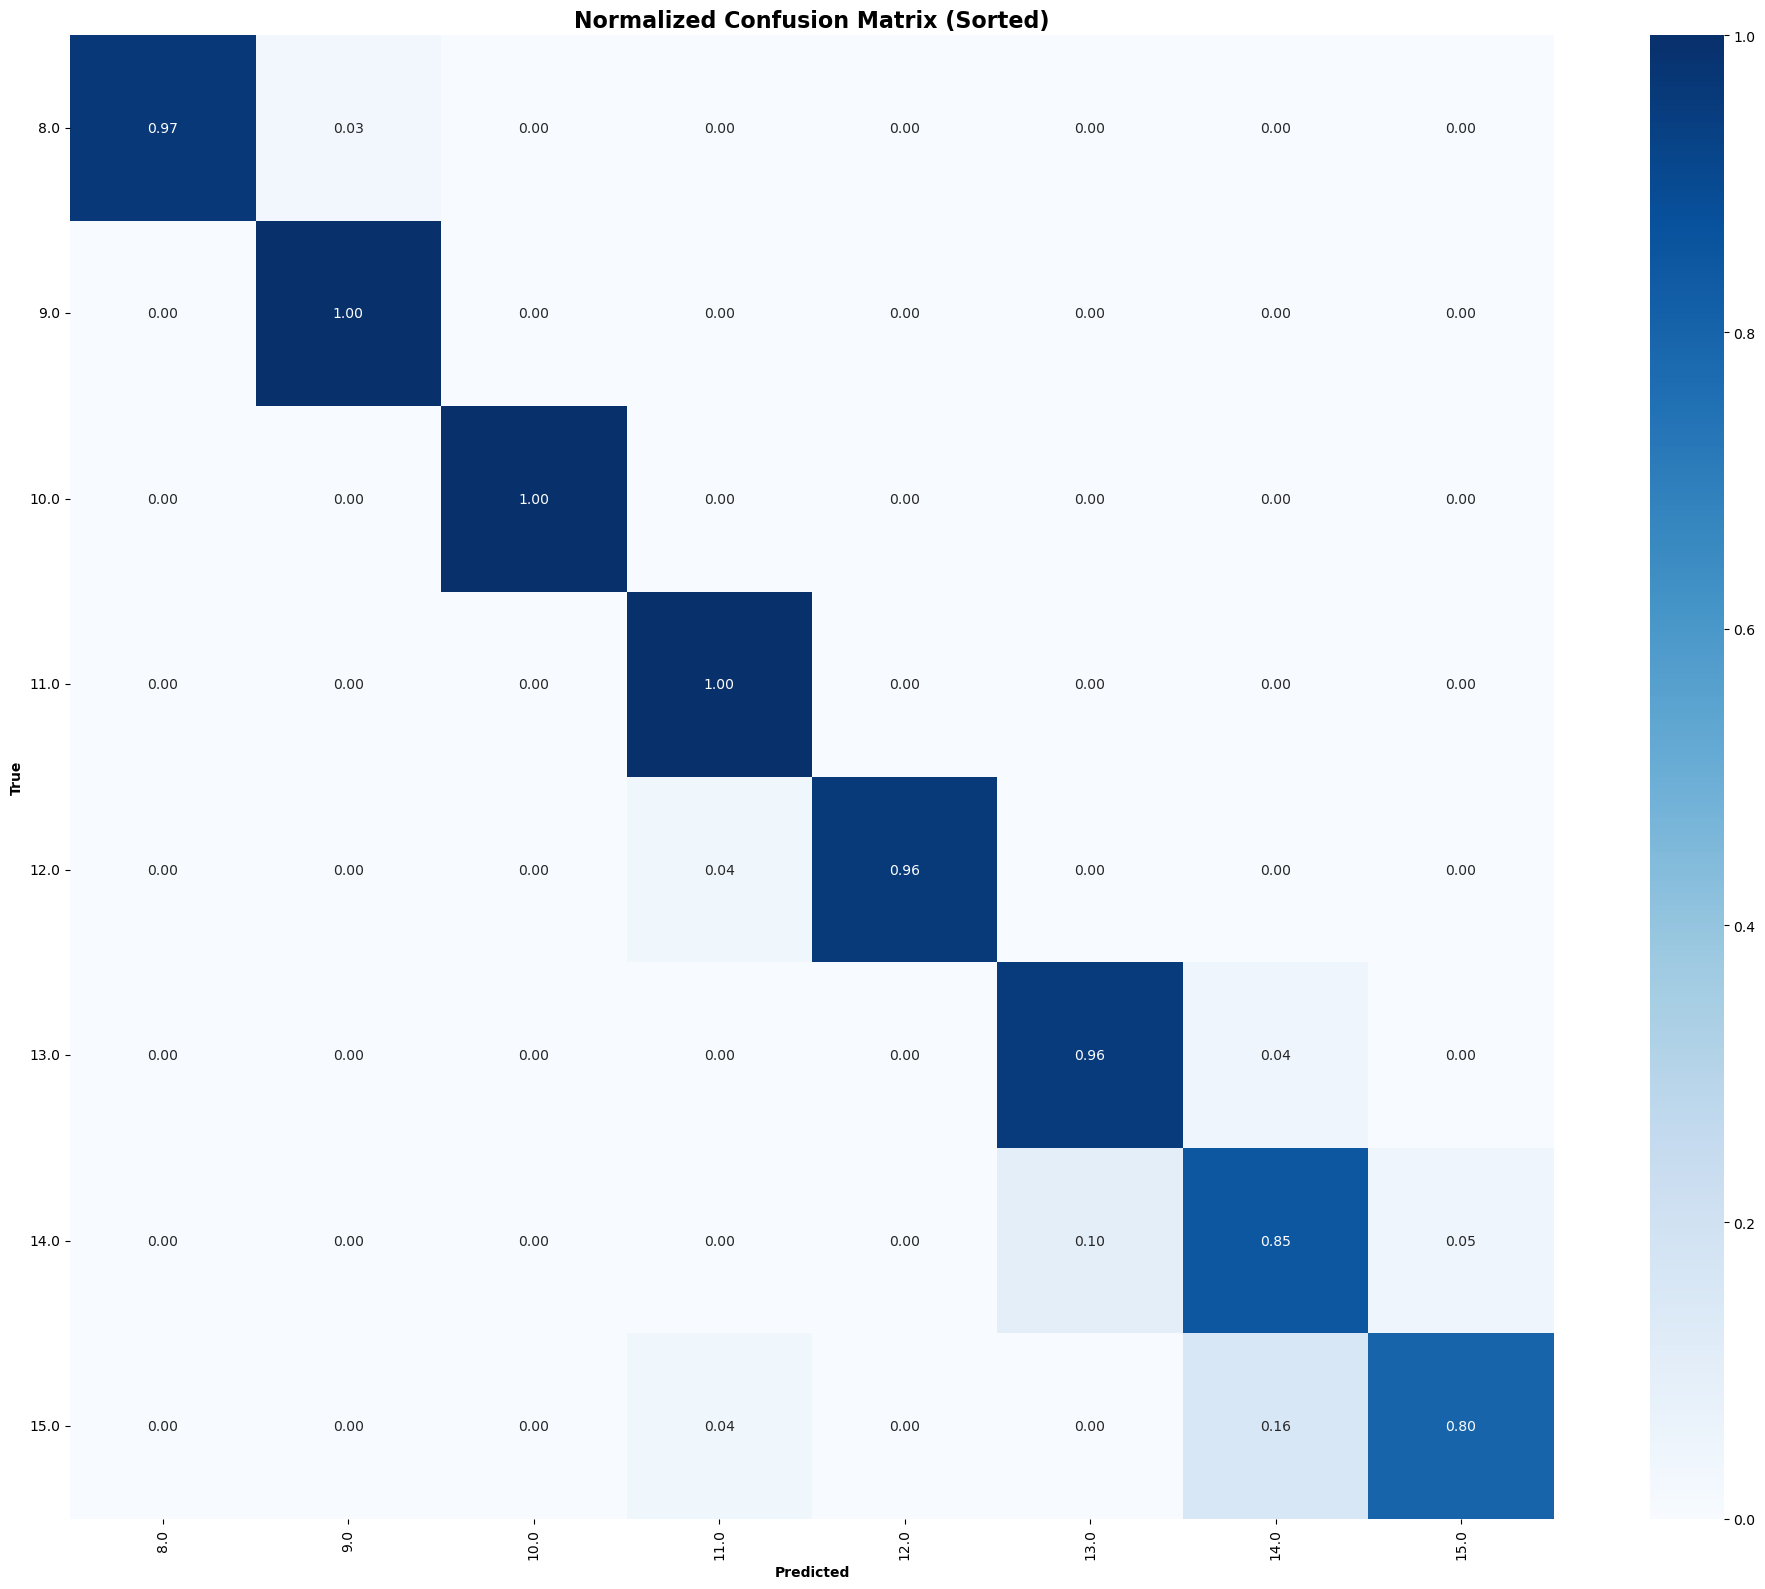

Test set Accuracy: 0.9427
Recall: 0.9427
F1 Score: 0.9427
Confusion Matrix:
[[28  1  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  0  1 24  0  0  0]
 [ 0  0  0  0  0 22  1  0]
 [ 0  0  0  0  0  2 17  1]
 [ 0  0  0  1  0  0  4 20]]
Testing on subject 26.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

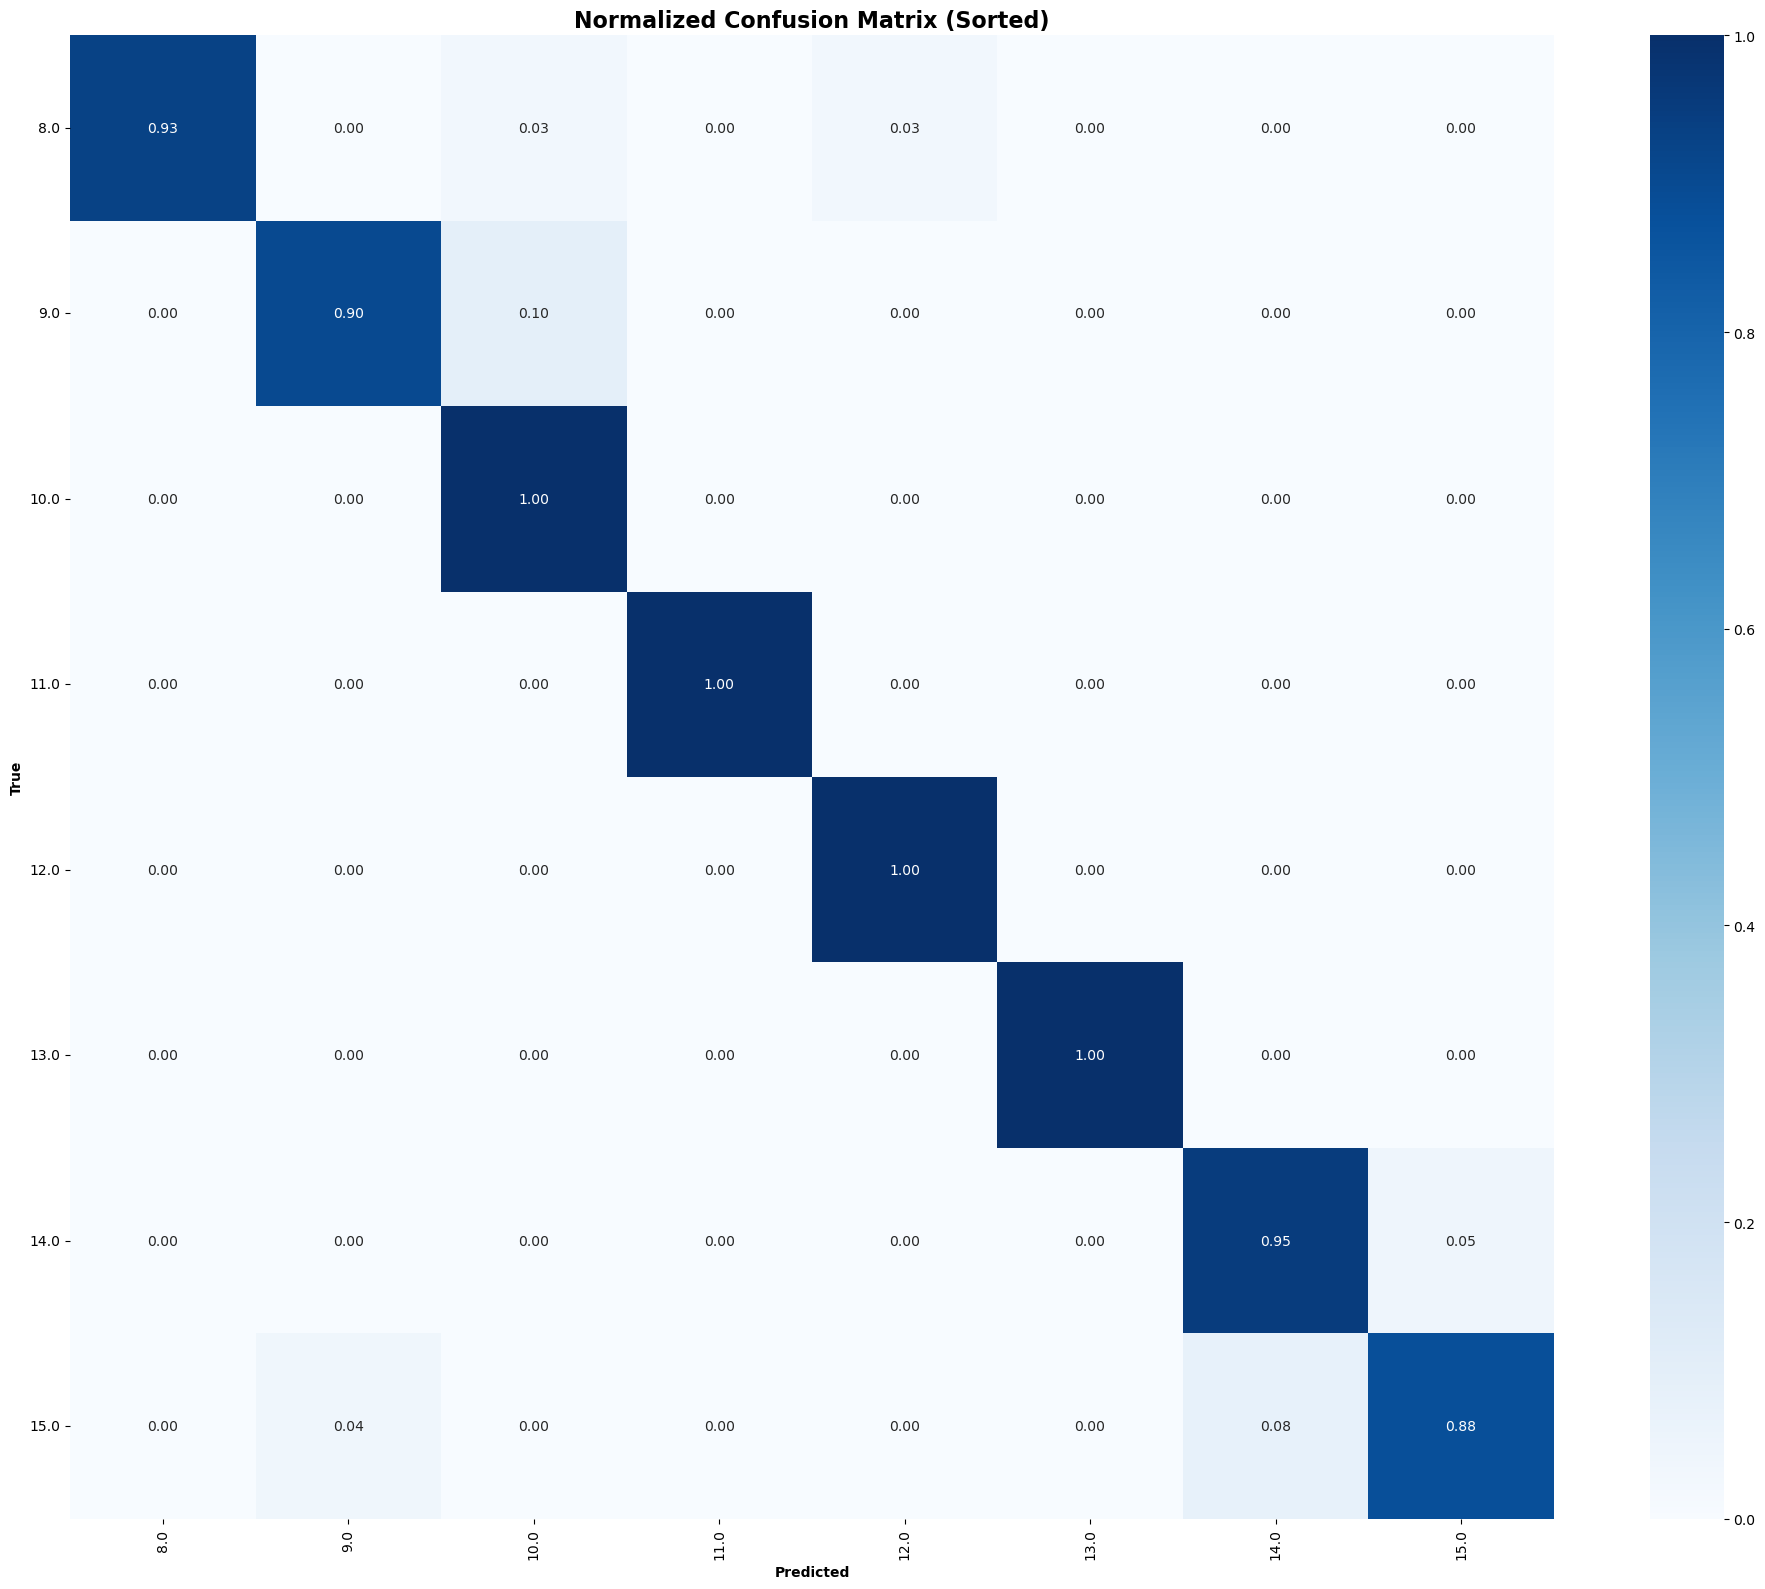

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9582
Confusion Matrix:
[[27  0  1  0  1  0  0  0]
 [ 0 19  2  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 19  1]
 [ 0  1  0  0  0  0  2 22]]
Testing on subject 27.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

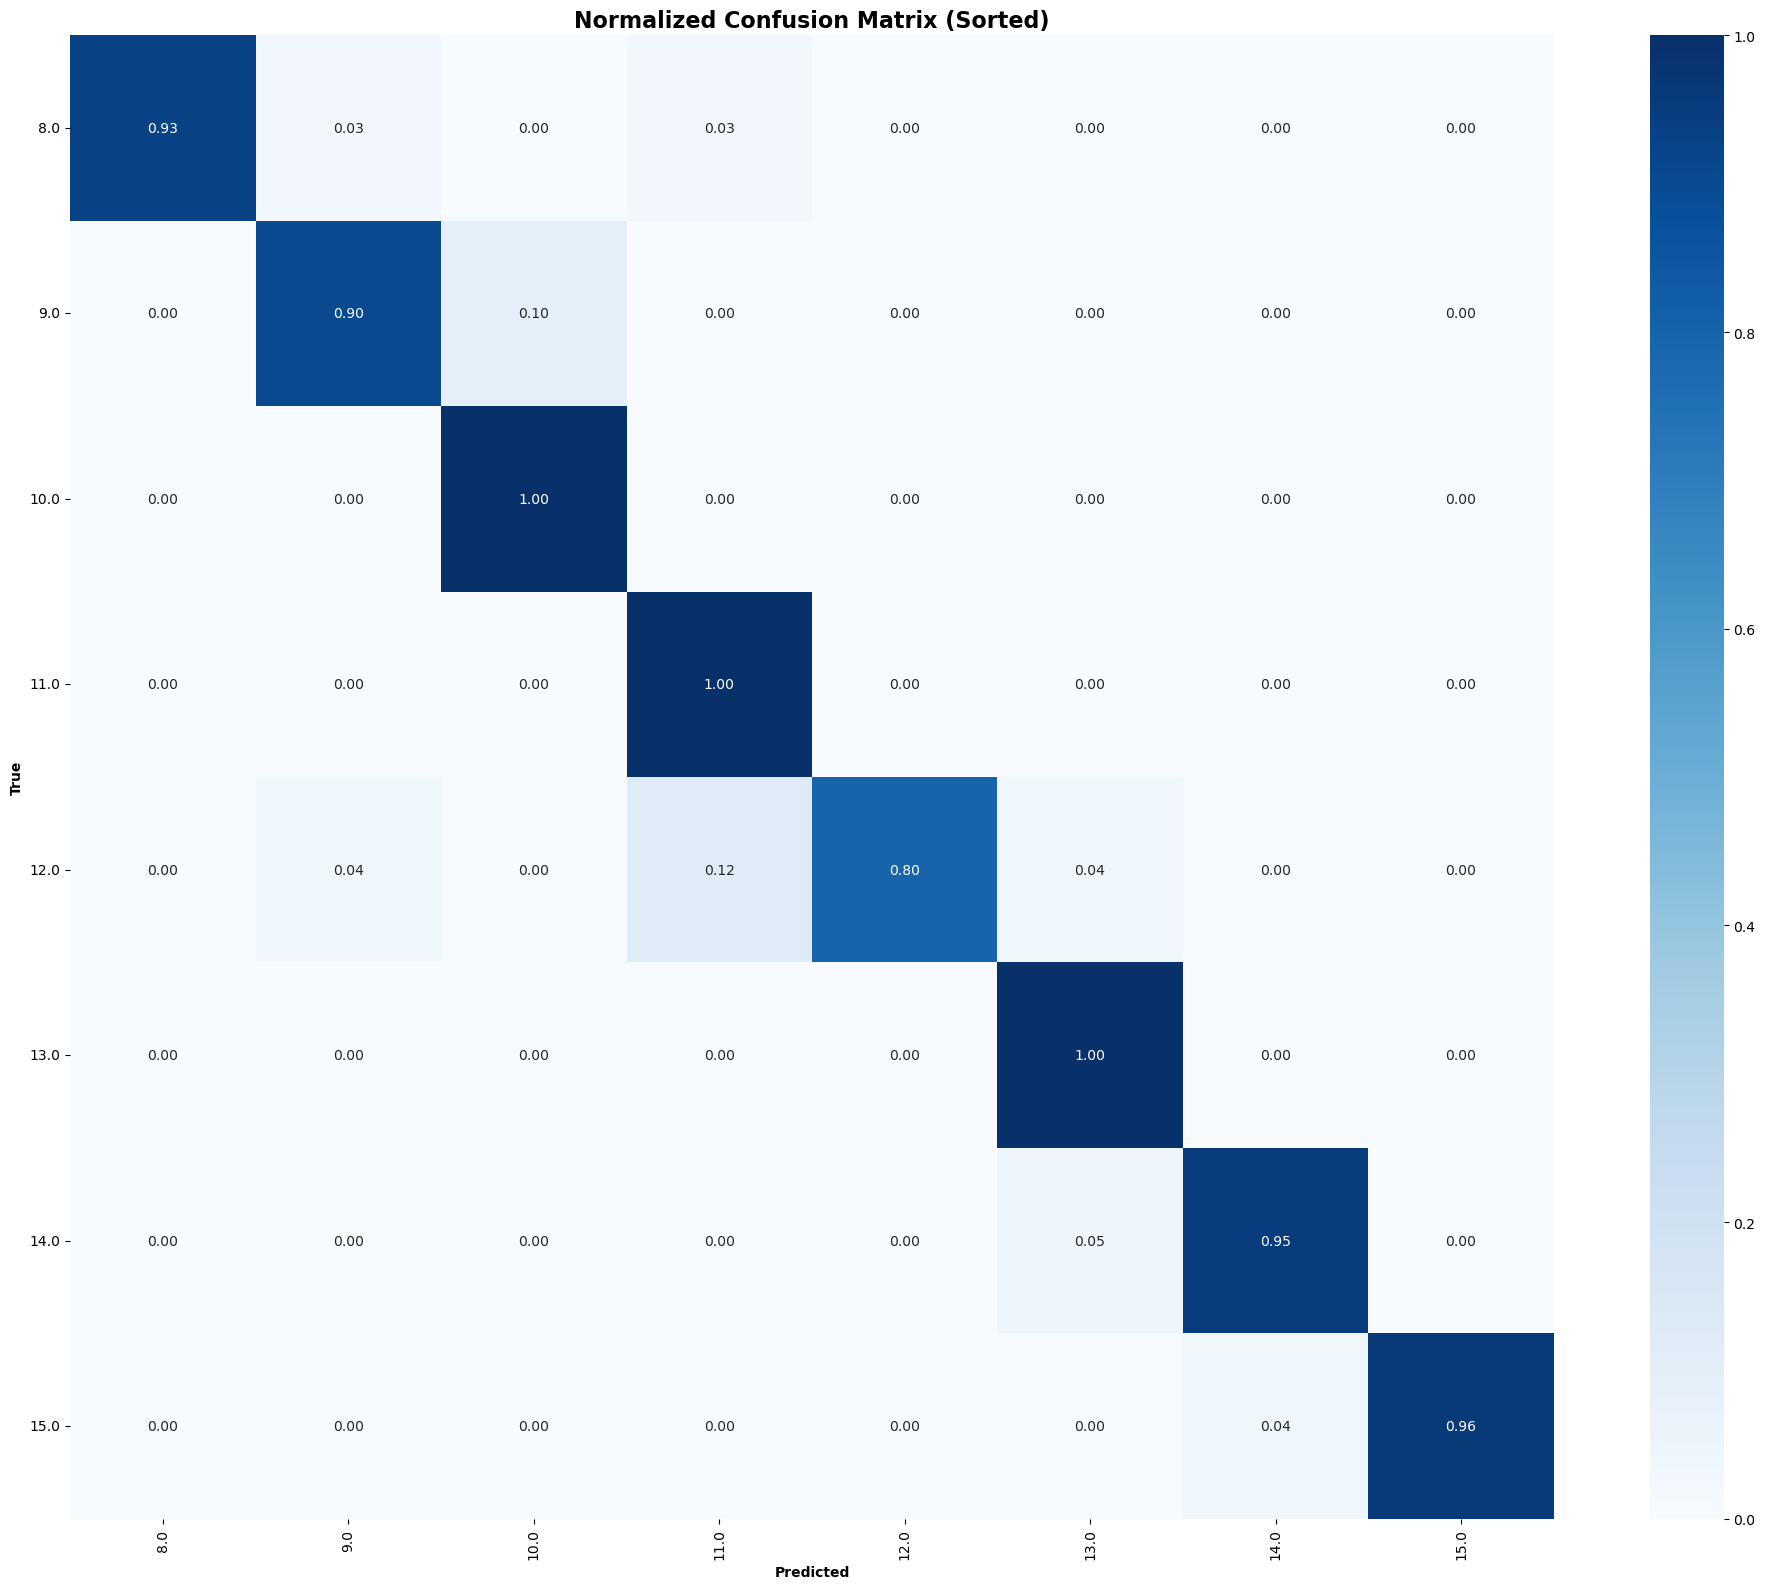

Test set Accuracy: 0.9427
Recall: 0.9427
F1 Score: 0.9423
Confusion Matrix:
[[27  1  0  1  0  0  0  0]
 [ 0 19  2  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  1  0  3 20  1  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  1 19  0]
 [ 0  0  0  0  0  0  1 24]]
Testing on subject 28.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

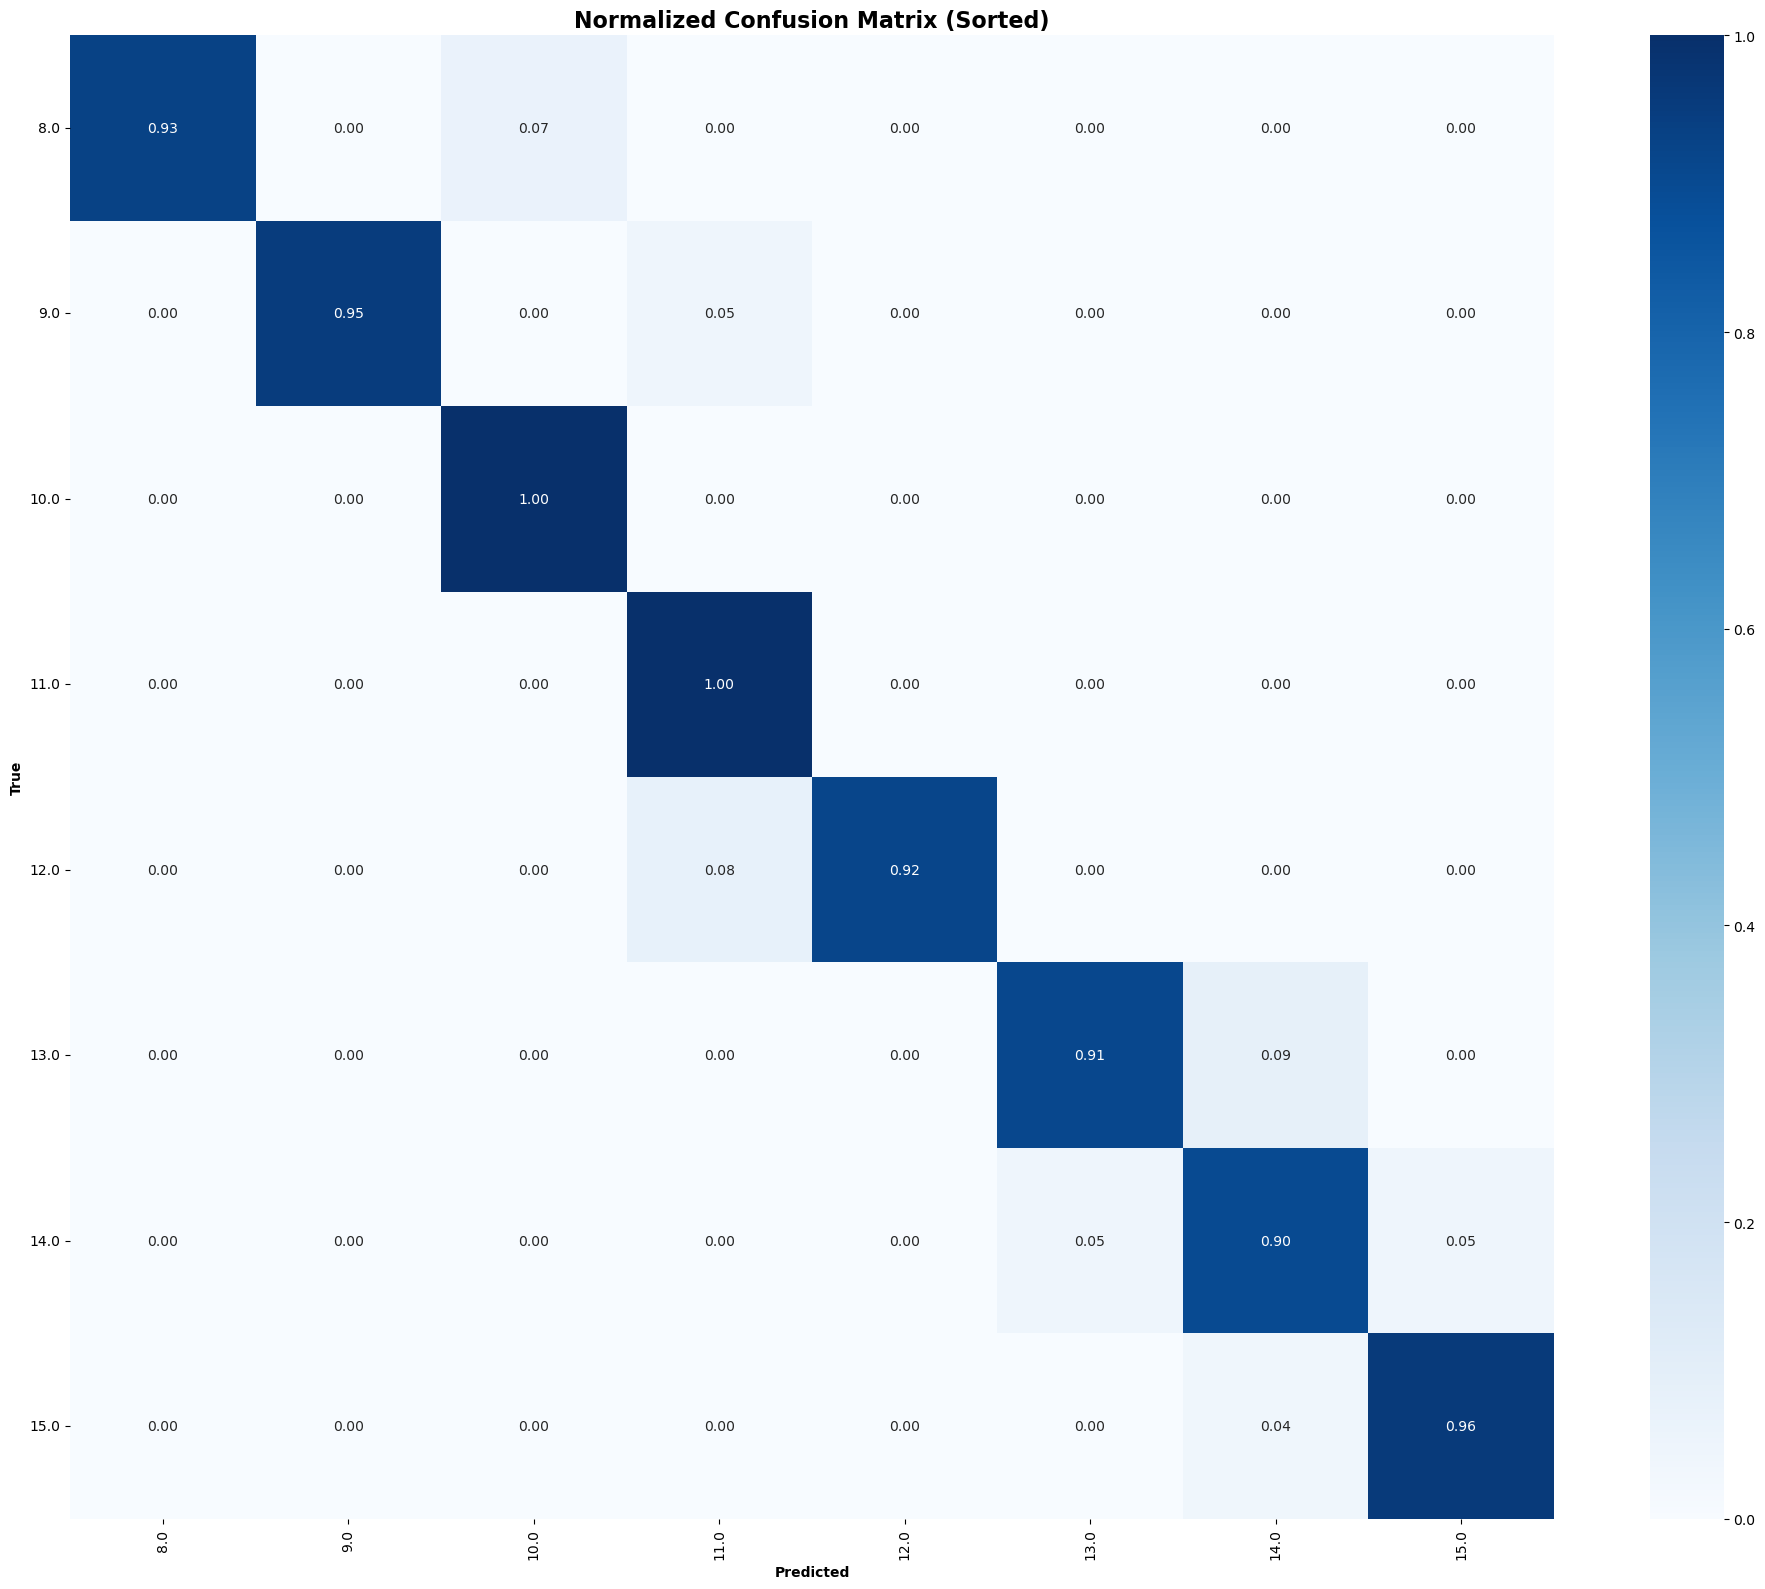

Test set Accuracy: 0.9479
Recall: 0.9479
F1 Score: 0.9483
Confusion Matrix:
[[27  0  2  0  0  0  0  0]
 [ 0 20  0  1  0  0  0  0]
 [ 0  0 27  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  0  2 23  0  0  0]
 [ 0  0  0  0  0 21  2  0]
 [ 0  0  0  0  0  1 18  1]
 [ 0  0  0  0  0  0  1 24]]
Testing on subject 29.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

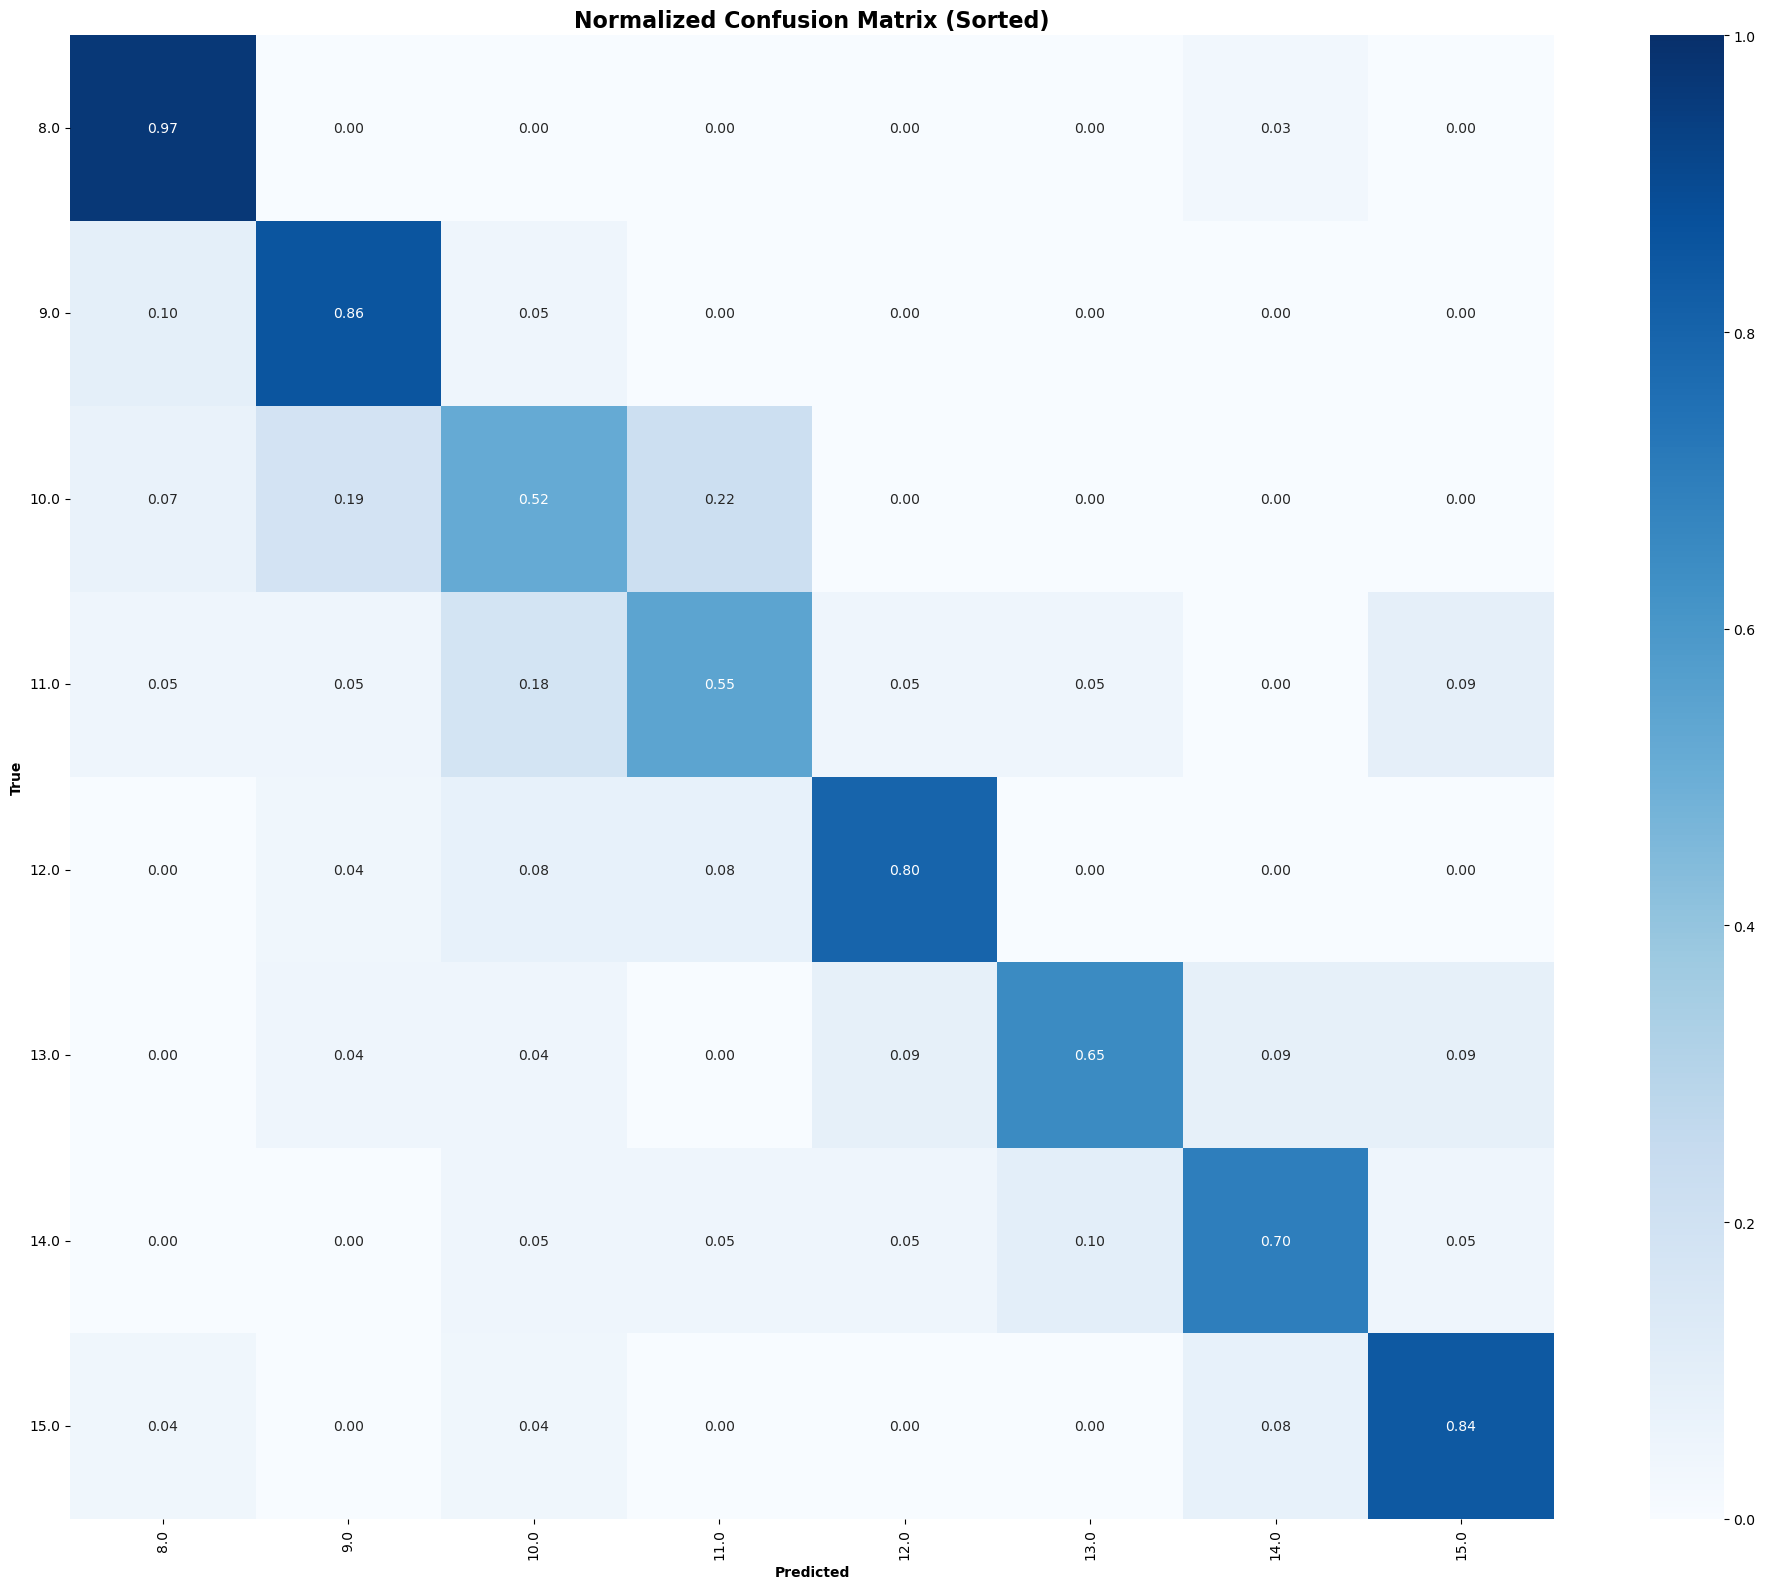

Test set Accuracy: 0.7396
Recall: 0.7396
F1 Score: 0.7352
Confusion Matrix:
[[28  0  0  0  0  0  1  0]
 [ 2 18  1  0  0  0  0  0]
 [ 2  5 14  6  0  0  0  0]
 [ 1  1  4 12  1  1  0  2]
 [ 0  1  2  2 20  0  0  0]
 [ 0  1  1  0  2 15  2  2]
 [ 0  0  1  1  1  2 14  1]
 [ 1  0  1  0  0  0  2 21]]
Testing on subject 30.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

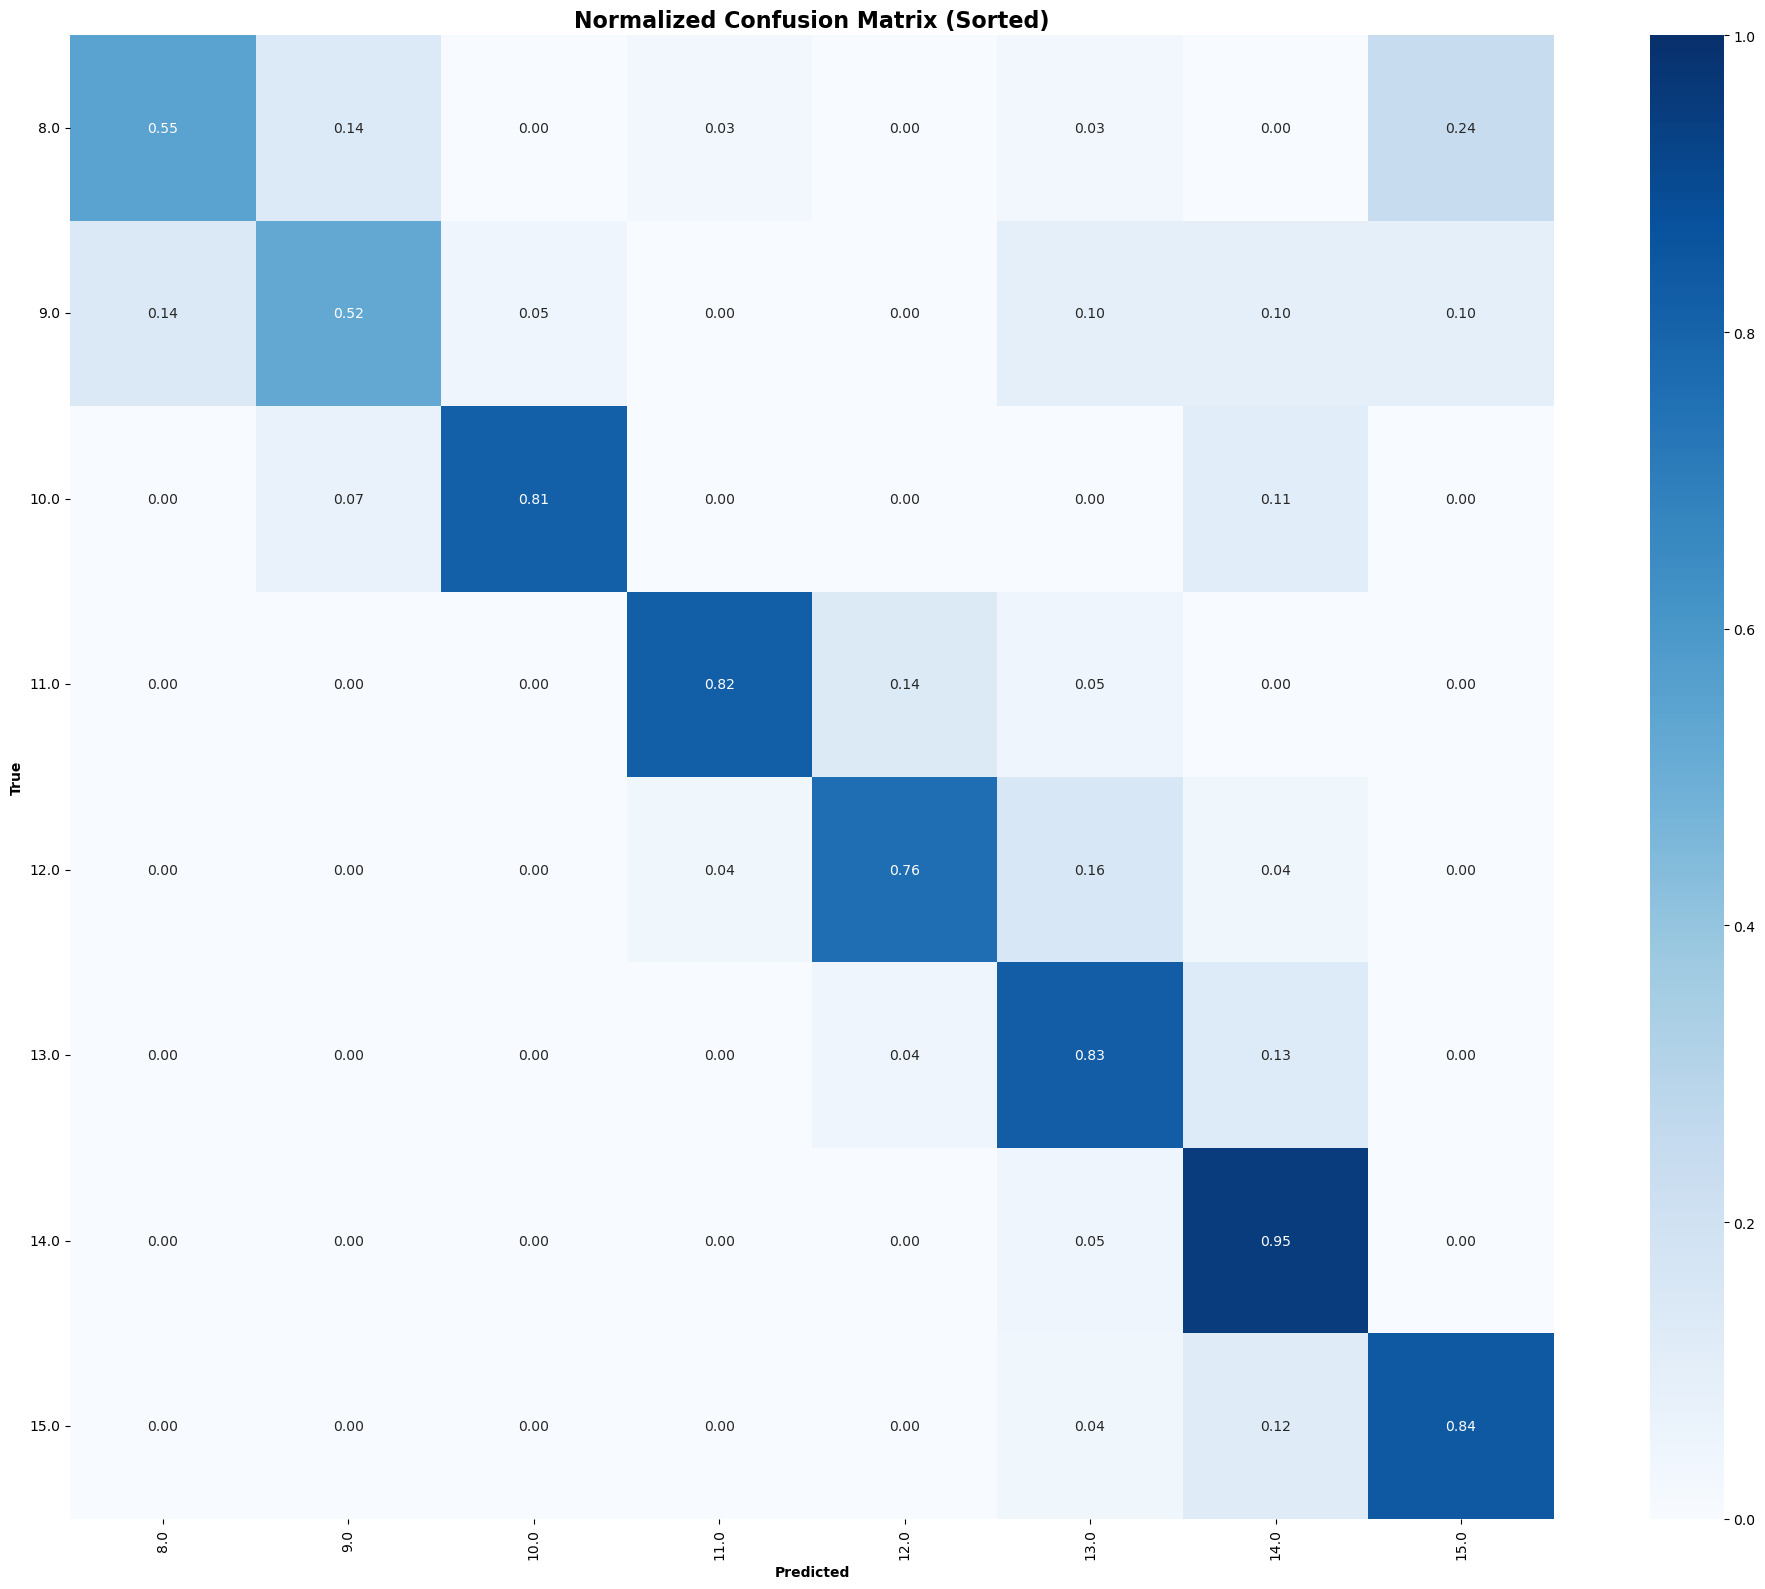

Test set Accuracy: 0.7552
Recall: 0.7552
F1 Score: 0.7536
Confusion Matrix:
[[16  4  0  1  0  1  0  7]
 [ 3 11  1  0  0  2  2  2]
 [ 0  2 22  0  0  0  3  0]
 [ 0  0  0 18  3  1  0  0]
 [ 0  0  0  1 19  4  1  0]
 [ 0  0  0  0  1 19  3  0]
 [ 0  0  0  0  0  1 19  0]
 [ 0  0  0  0  0  1  3 21]]
Testing on subject 31.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

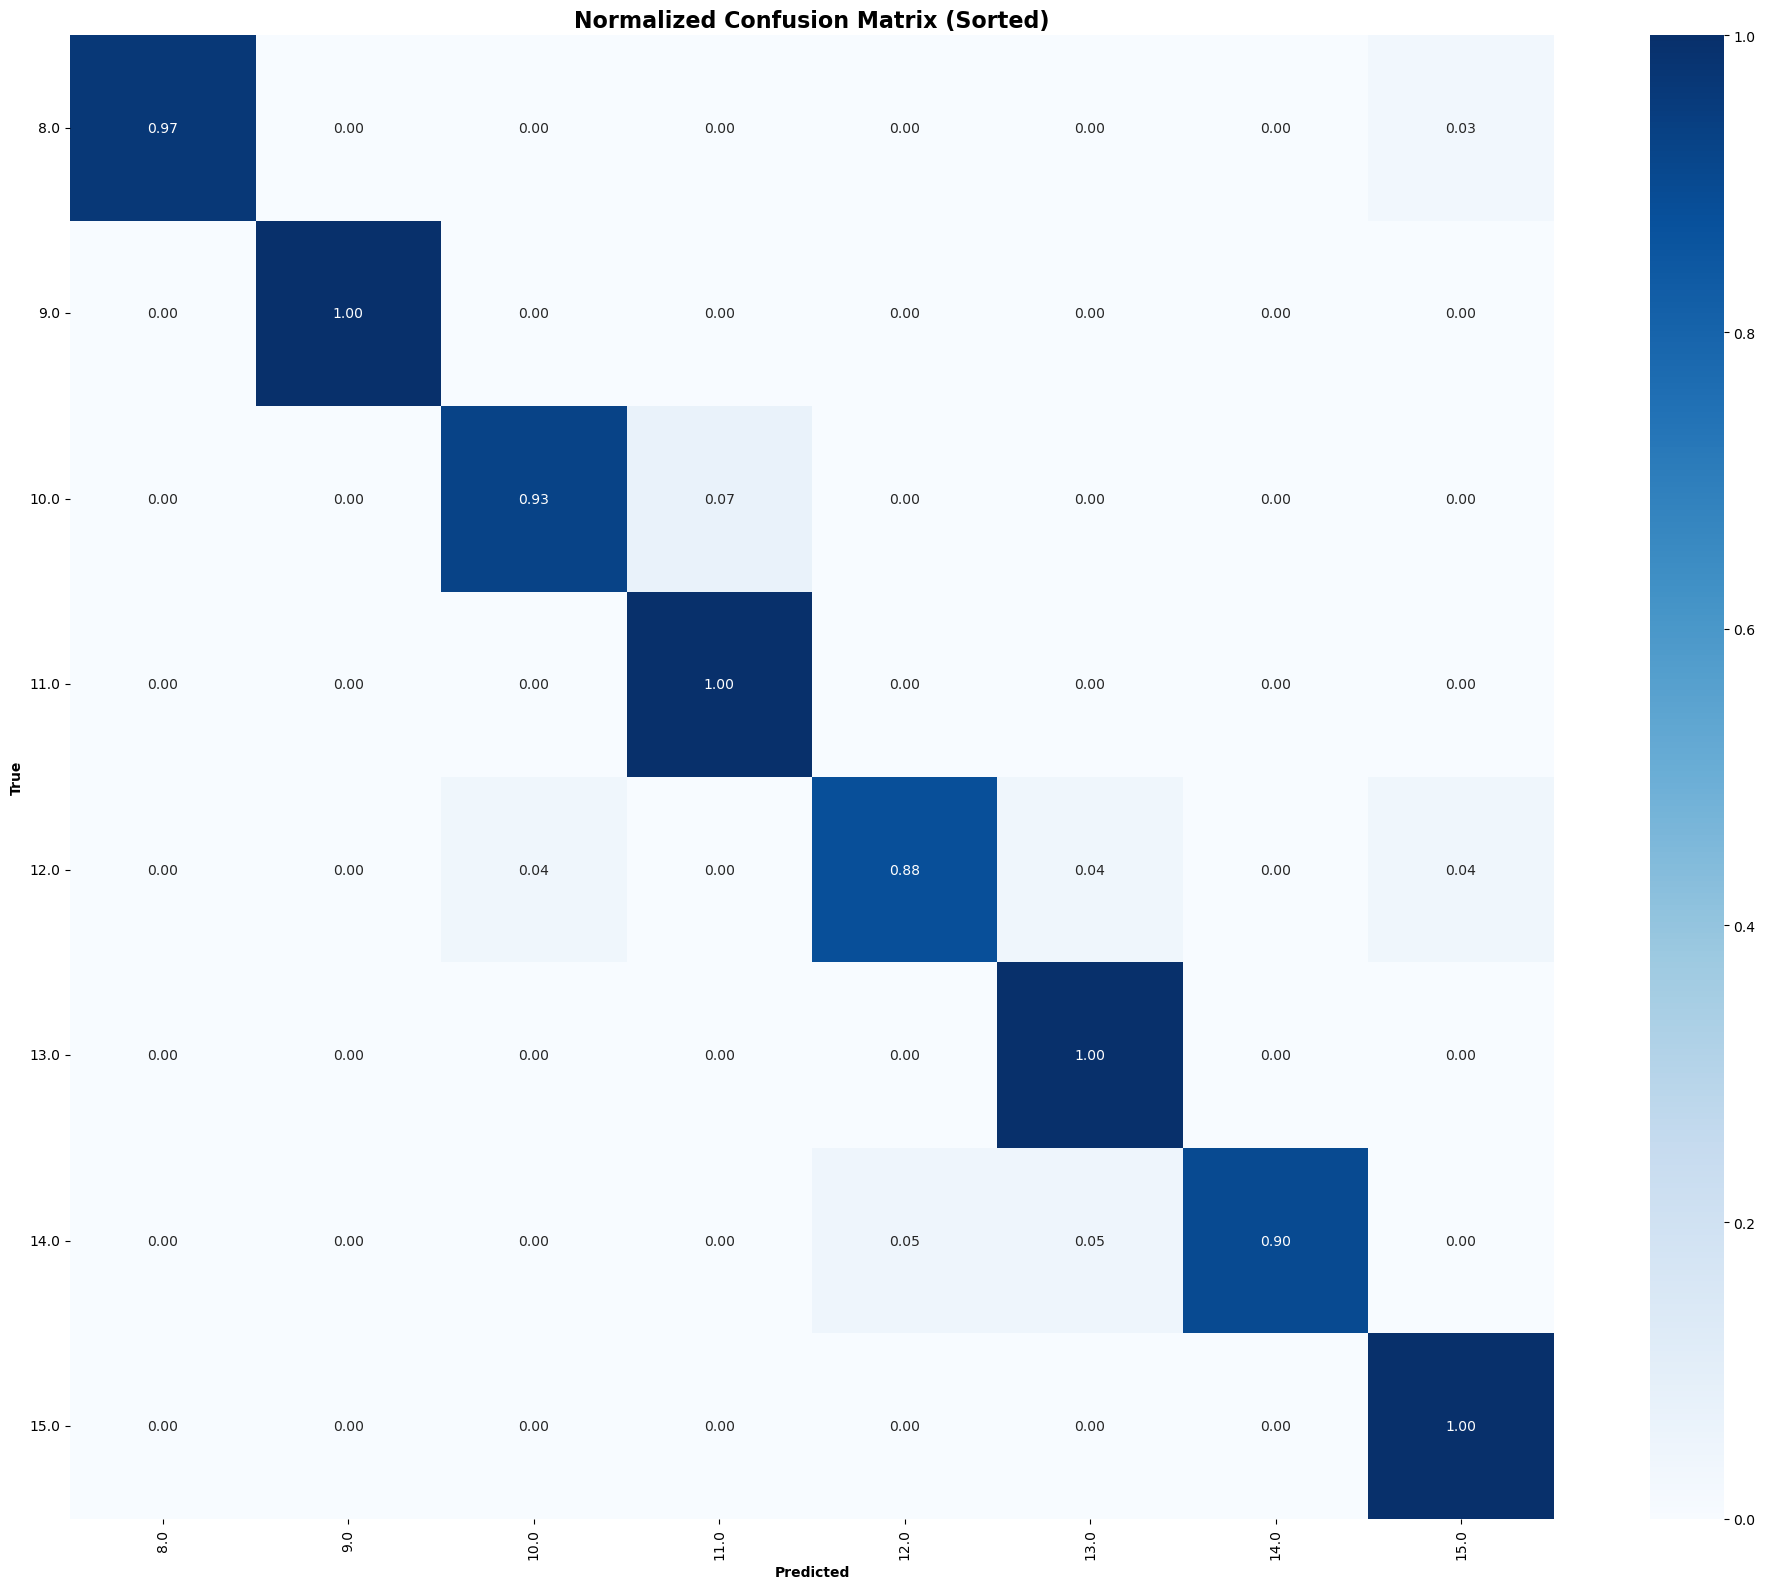

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9581
Confusion Matrix:
[[28  0  0  0  0  0  0  1]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 25  2  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  1  0 22  1  0  1]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  1  1 18  0]
 [ 0  0  0  0  0  0  0 25]]
Testing on subject 32.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

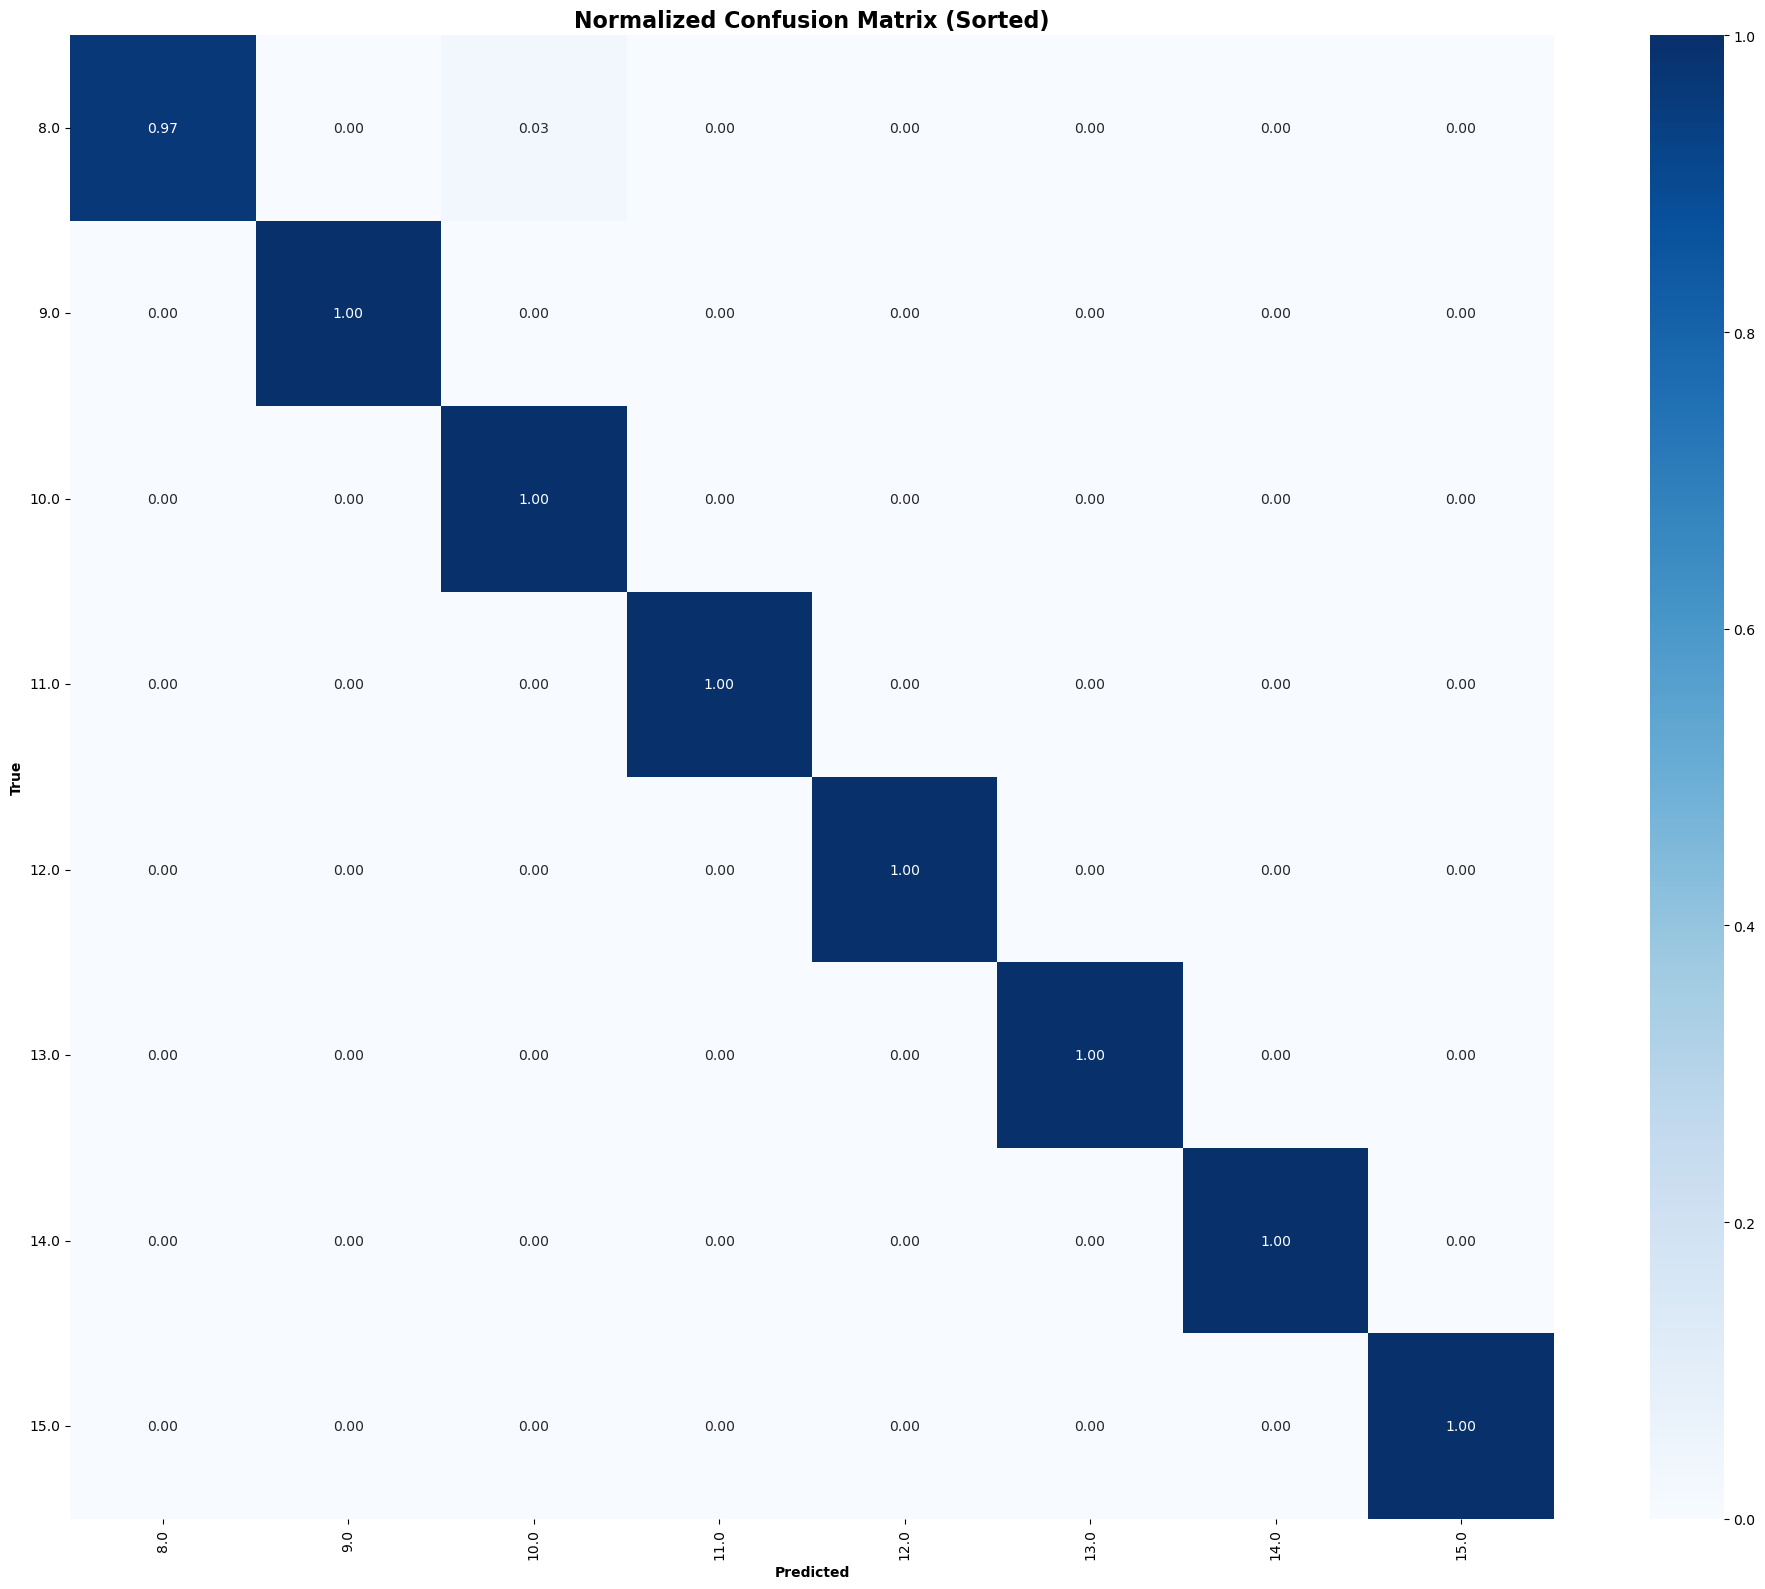

Test set Accuracy: 0.9948
Recall: 0.9948
F1 Score: 0.9948
Confusion Matrix:
[[28  0  1  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 27  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  0  0 25  0  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0 25]]
Testing on subject 33.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

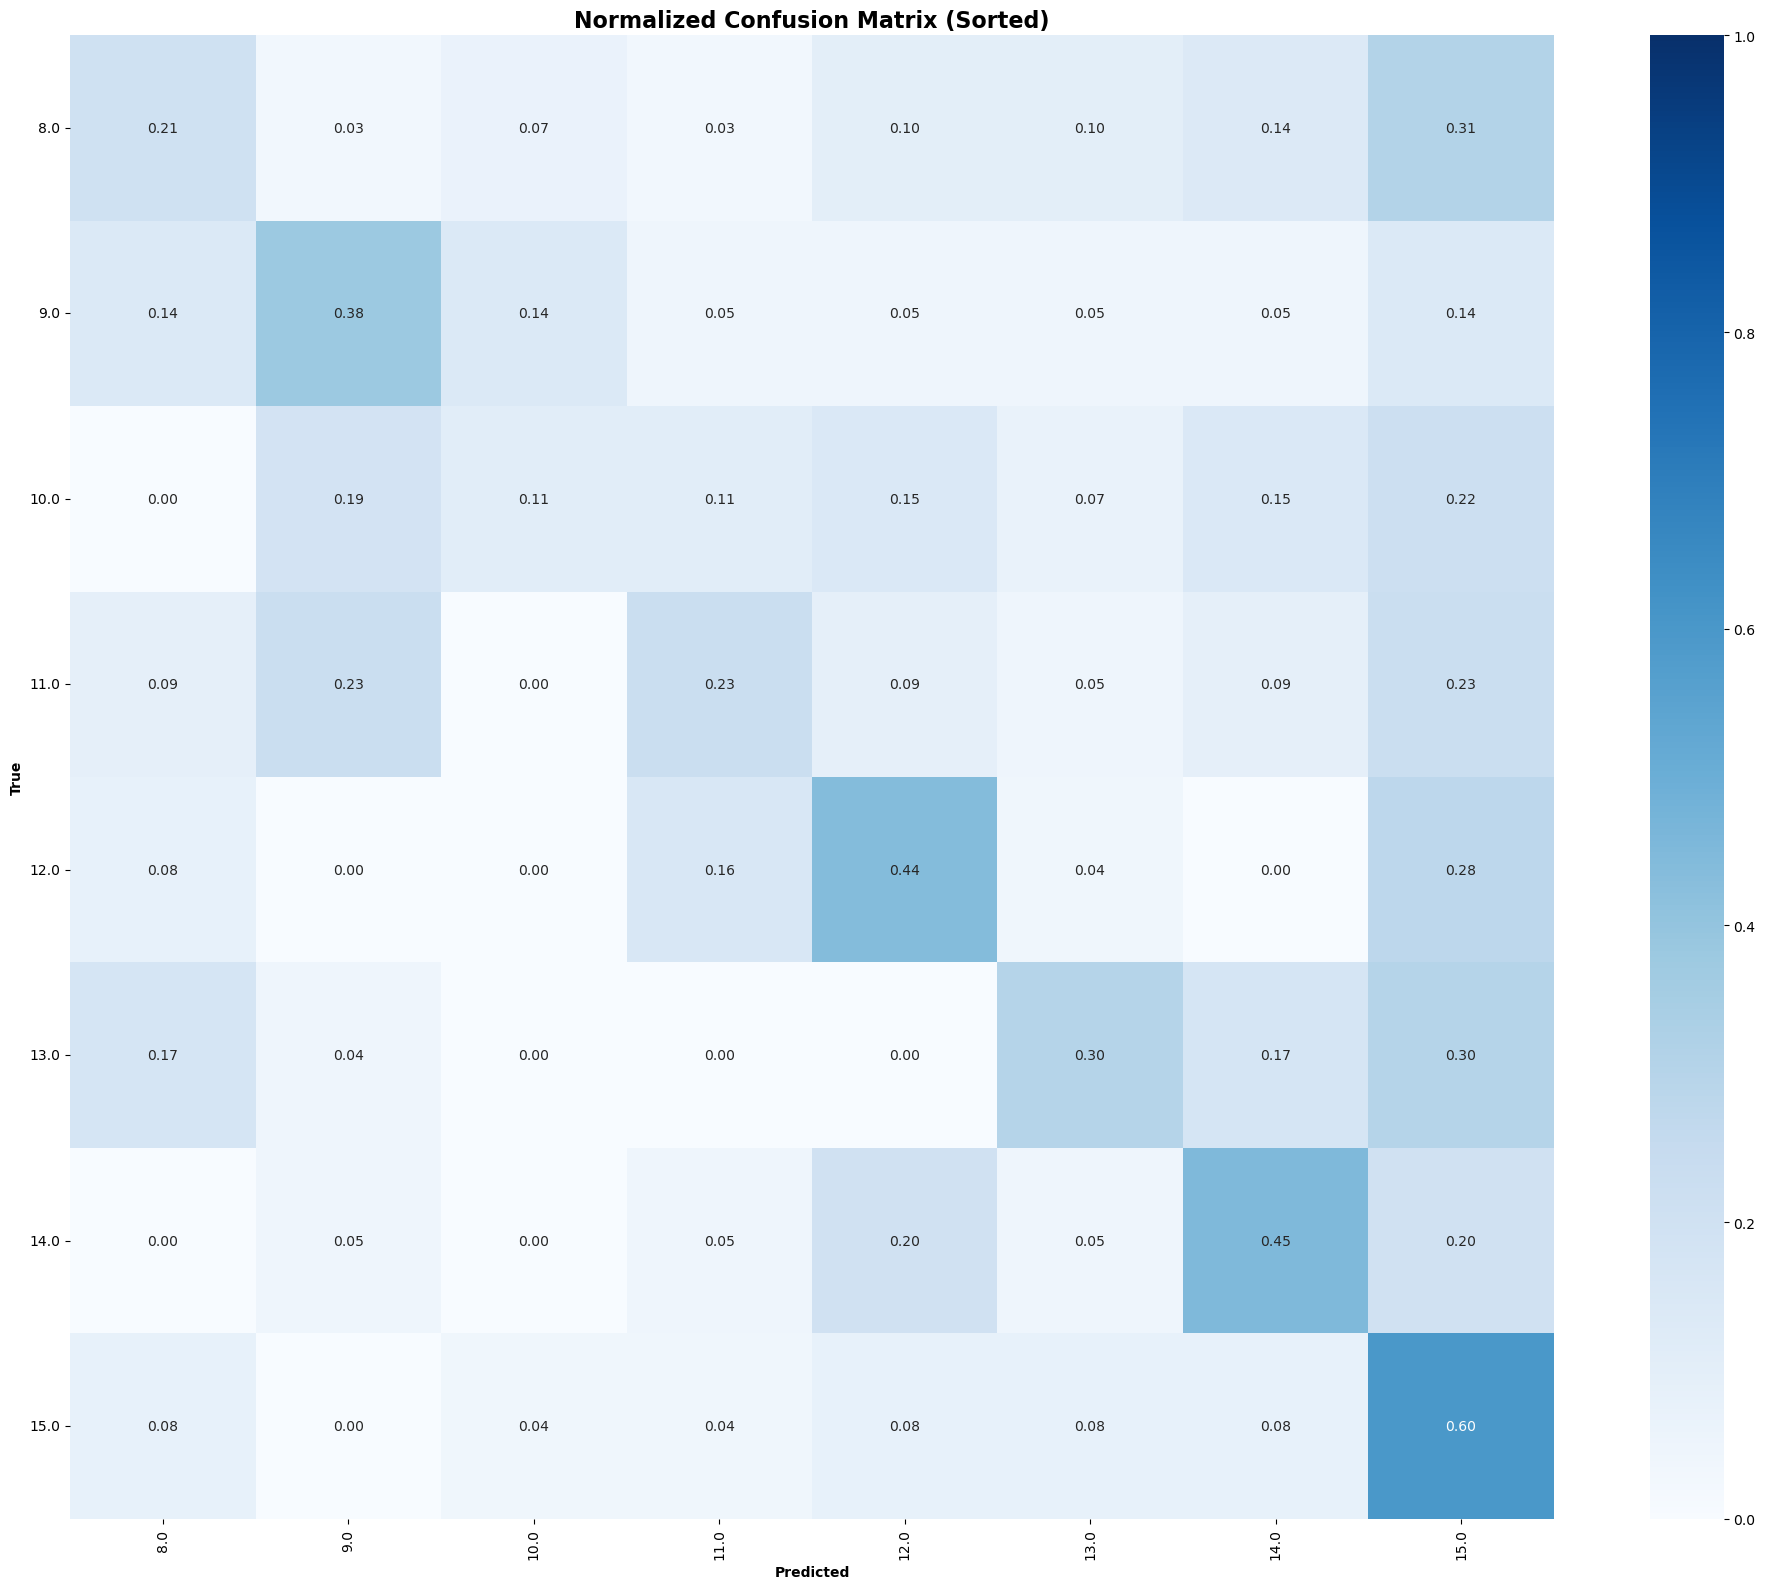

Test set Accuracy: 0.3333
Recall: 0.3333
F1 Score: 0.3180
Confusion Matrix:
[[ 6  1  2  1  3  3  4  9]
 [ 3  8  3  1  1  1  1  3]
 [ 0  5  3  3  4  2  4  6]
 [ 2  5  0  5  2  1  2  5]
 [ 2  0  0  4 11  1  0  7]
 [ 4  1  0  0  0  7  4  7]
 [ 0  1  0  1  4  1  9  4]
 [ 2  0  1  1  2  2  2 15]]
Testing on subject 34.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

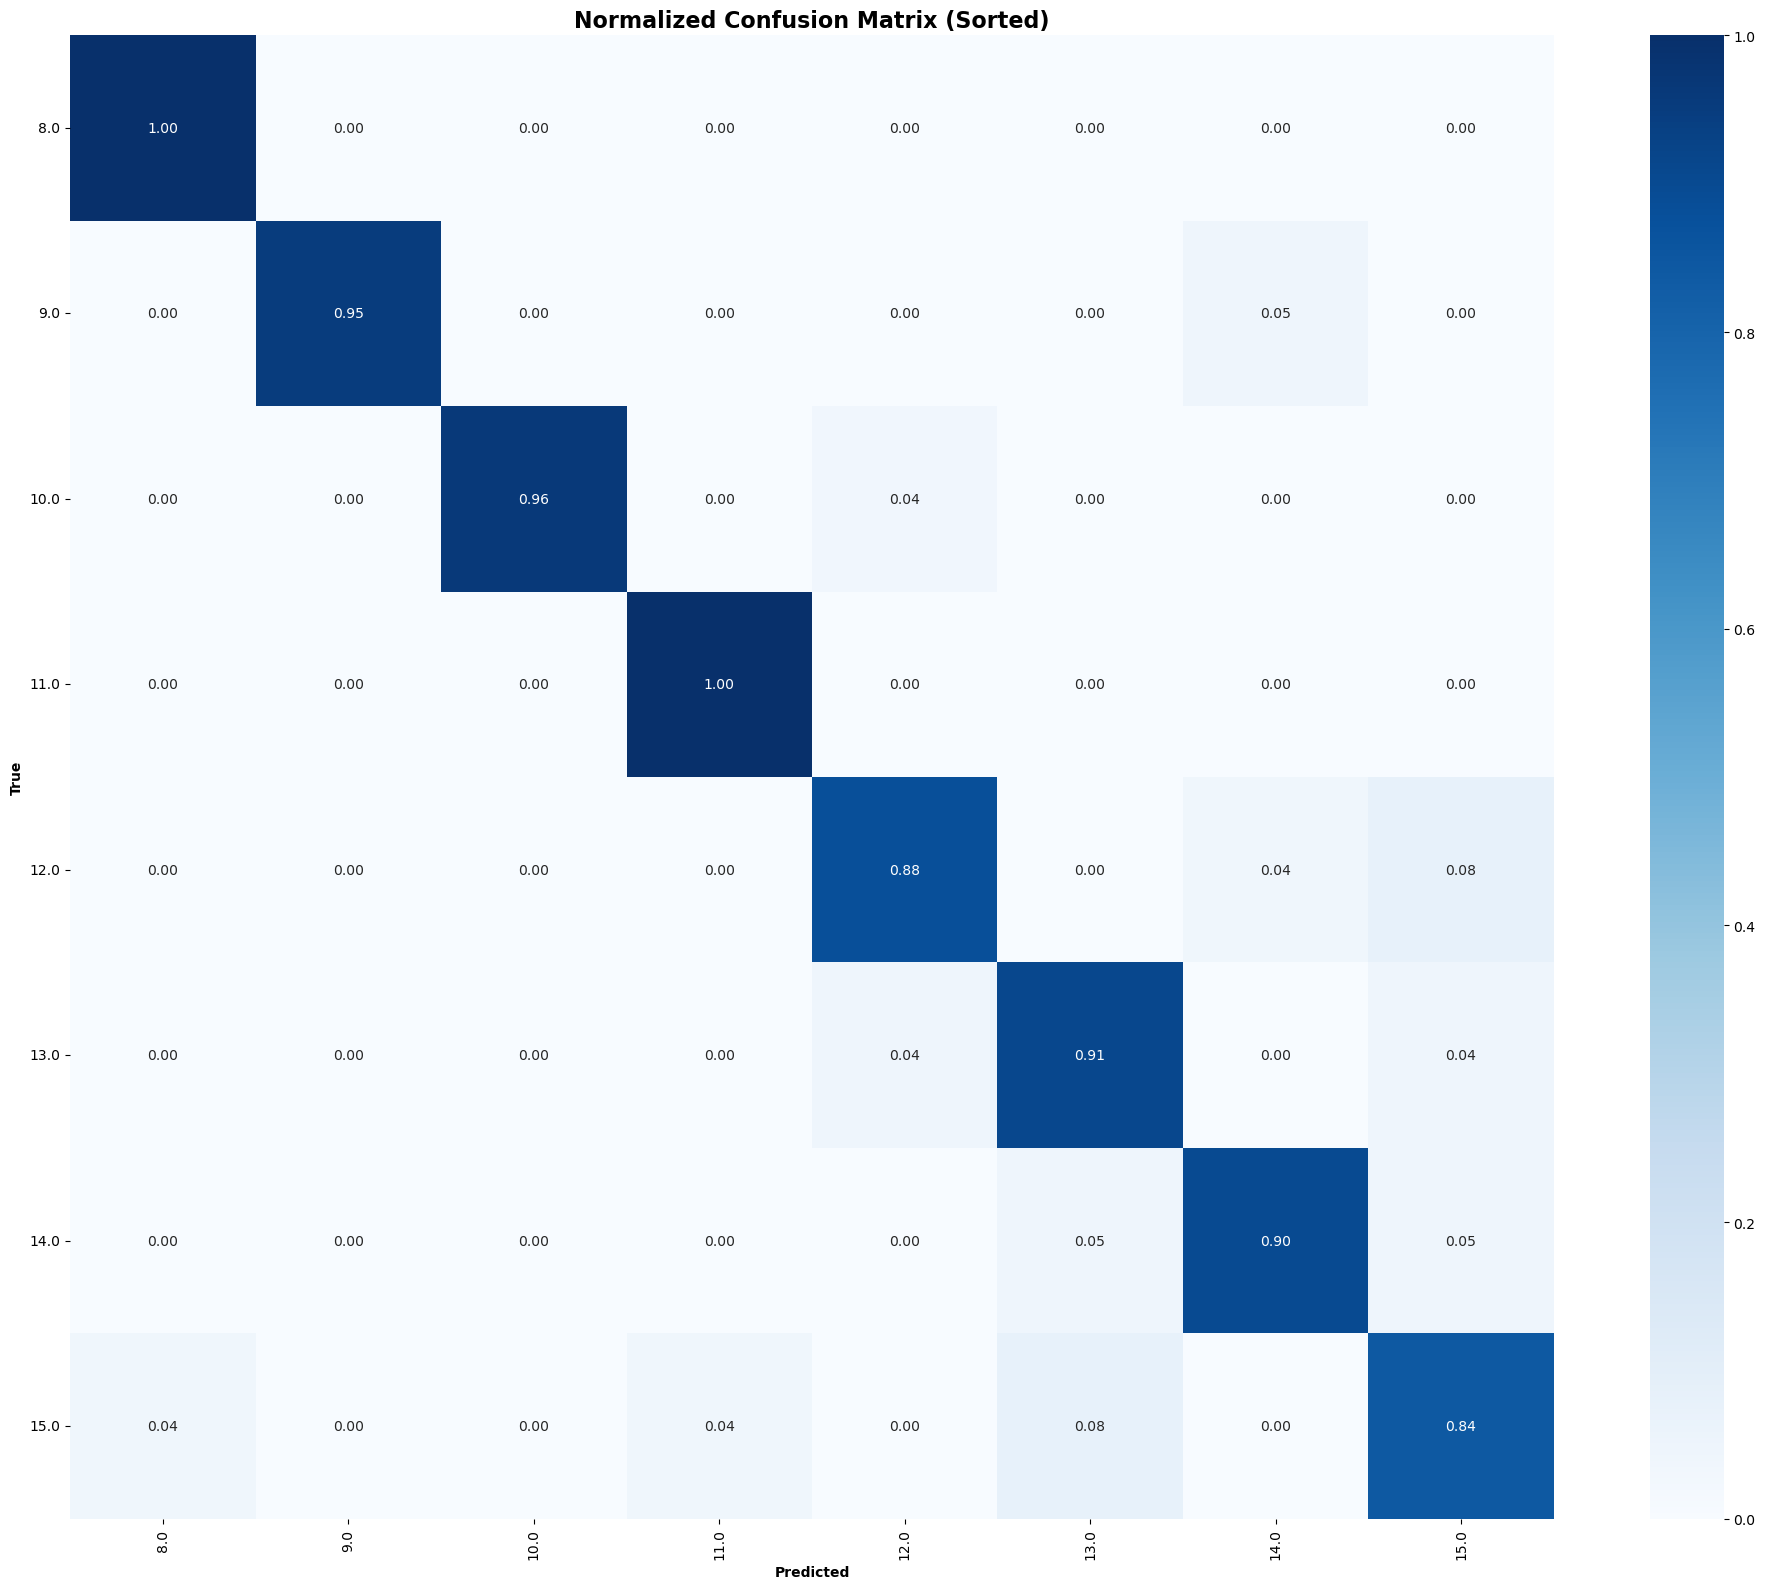

Test set Accuracy: 0.9323
Recall: 0.9323
F1 Score: 0.9323
Confusion Matrix:
[[29  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  1  0]
 [ 0  0 26  0  1  0  0  0]
 [ 0  0  0 22  0  0  0  0]
 [ 0  0  0  0 22  0  1  2]
 [ 0  0  0  0  1 21  0  1]
 [ 0  0  0  0  0  1 18  1]
 [ 1  0  0  1  0  2  0 21]]
Testing on subject 35.
Training dataset size: 8160
Validation dataset size: 48
Test dataset size: 192


C:\Users\machi\AppData\Local\Temp\ipykernel_24924\2336014469.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_save_path))

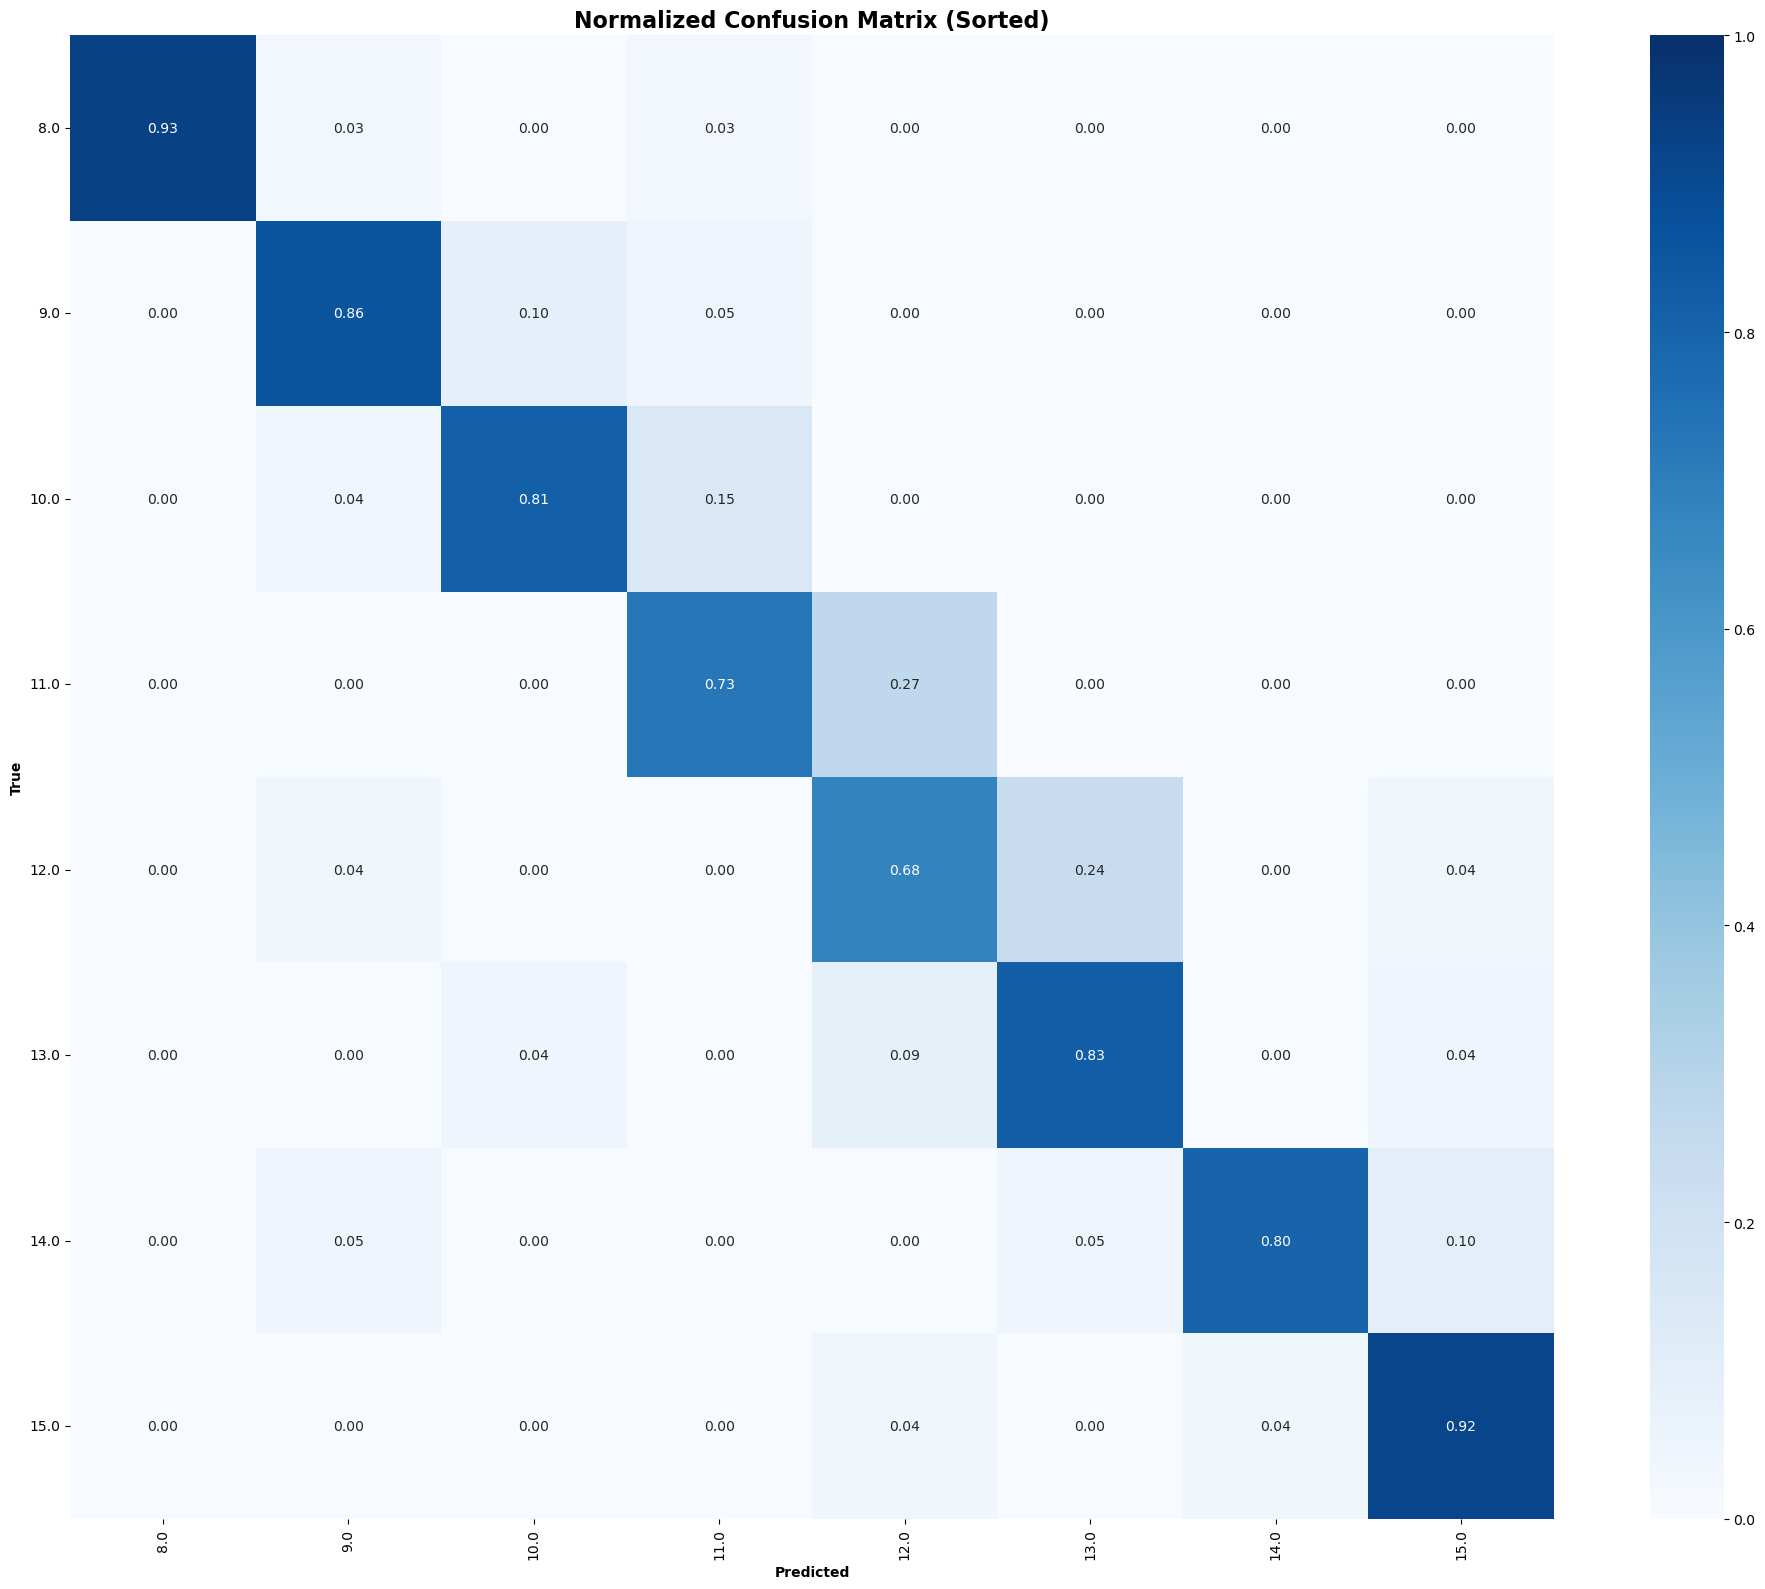

Test set Accuracy: 0.8229
Recall: 0.8229
F1 Score: 0.8245
Confusion Matrix:
[[27  1  0  1  0  0  0  0]
 [ 0 18  2  1  0  0  0  0]
 [ 0  1 22  4  0  0  0  0]
 [ 0  0  0 16  6  0  0  0]
 [ 0  1  0  0 17  6  0  1]
 [ 0  0  1  0  2 19  0  1]
 [ 0  1  0  0  0  1 16  2]
 [ 0  0  0  0  1  0  1 23]]


In [8]:
result = {}
for i in range(0, 35):
    result[f"S{i+1}"] = eval_subject(i, signals, labels, selected_freqs)

In [14]:
result

{'S1': {'accuracy': array(0.42916667),
  'recall': array(0.42916667),
  'f1_score': array(0.41185751)},
 'S2': {'accuracy': array(0.01979167),
  'recall': array(0.01979167),
  'f1_score': array(0.00076822)},
 'S3': {'accuracy': array(0.021875),
  'recall': array(0.021875),
  'f1_score': array(0.00093654)},
 'S4': {'accuracy': array(0.01979167),
  'recall': array(0.01979167),
  'f1_score': array(0.00076822)},
 'S5': {'accuracy': array(0.01979167),
  'recall': array(0.01979167),
  'f1_score': array(0.00076822)},
 'S6': {'accuracy': array(0.01979167),
  'recall': array(0.01979167),
  'f1_score': array(0.00076822)},
 'S7': {'accuracy': array(0.01979167),
  'recall': array(0.01979167),
  'f1_score': array(0.00076822)},
 'S8': {'accuracy': array(0.01979167),
  'recall': array(0.01979167),
  'f1_score': array(0.00076822)},
 'S9': {'accuracy': array(0.01979167),
  'recall': array(0.01979167),
  'f1_score': array(0.00076822)},
 'S10': {'accuracy': array(0.021875),
  'recall': array(0.021875),
 

In [ ]:
df = pd.DataFrame.from_dict(result, orient="index")

df.to_csv(
    "best_trained_raw_models/cross_subject/40freq/results_cnn1d_cross_subj_40_freqs_tests.csv"
)